This notebook will discuss how to measure the magnitude of discharge events. 

In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

In [2]:
# importing waveform files 
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T000810Z_tier_raw.lh5'

In [3]:
#importing JSON file which describes each detector
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "bege"

# Iterate through cmap to find the key for the desired_type
matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
# Character to add
ch = "ch"

# Use list comprehension to add ch to each element in the array
detectors_bege = [ch+element for element in matching_bege]

**Initial Imports**

In this section I import all the data and form dictionaries so the data can easily be acsessed throughout the notebook.

In [6]:
tb_data_dict = {}  # Dictionary to store tb_data for each detector
wfs_all_dict = {}  # Dictionary to store wfs_all for each detector

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

**Minimum value determination**

Determining the minimum values of the waveforms.

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]
    
    # Initialize empty lists to store min and max values
    min_values = []
    
    # Loop through all waveforms to find the min and max values
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

**Initial cuts**

Discharges typically have a smaller minimum value than calibration events and hence it is easier to remove baselines and testing data.

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    # Calculate Z-scores for the minimum values
    min_z_scores = zscore(min_values)
    
    # Initialize empty list to store filtered min values
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    # Loop through Z-scores and filter out anomalies
    for i, z_score in enumerate(min_z_scores):
        # Check if the Z-score for the min value is beyond the threshold
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            # If beyond the threshold, skip this iteration
            continue
        
        # Append the min value to the filtered list
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1 #one standard deviation 
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

Introducing a parameter which will tell how many waveforms were correctly removed.

Another cut but now for the maximal value 

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    # Loop through all waveforms to find the min and max values
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        # Append min and max values to the lists
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    # Calculate Z-scores for the maximum values
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    # Initialize empty lists to store filtered and skipped max values, as well as their corresponding indices
    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    # Loop through Z-scores and filter out anomalies
    for i, z_score in enumerate(max_z_scores):
        # Check if the Z-score for the max value is beyond the threshold
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            # If beyond the threshold, skip this iteration
            continue
        
        # Append the max value to the filtered list
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

Here we have added in another selection criteria. Essentially what this means is if the length of the 1st cut is smaller than 20 we dont proceed with the next cut. 
This is done such that if the first cut was sufficient ie we had extracted all of the discharges in the first cut then the second would be too much ie it would remove incorrect waveforms. 

In [14]:
threshold =1 #one standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

This detector ch1107202 doesn't have any discharges
Skipped waveforms for detector ch1110402: [1130, 1177, 1361]
Percentage of discharges present: 0.21246458923512845%


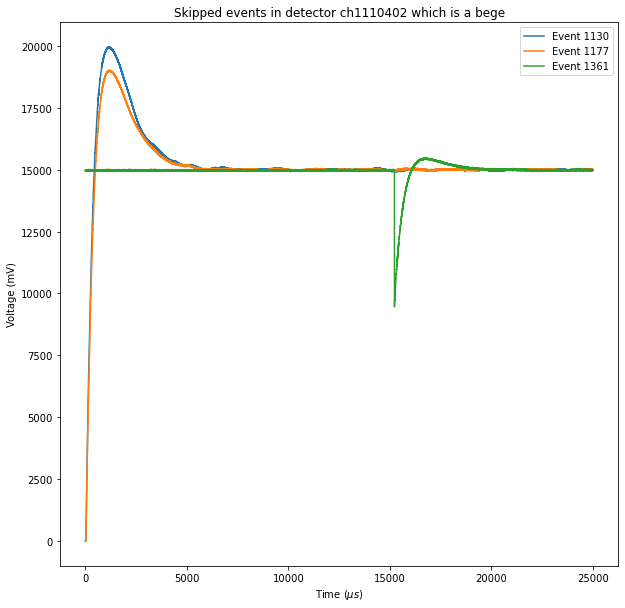

Skipped waveforms for detector ch1110403: [51, 393]
Percentage of discharges present: 0.14164305949008194%


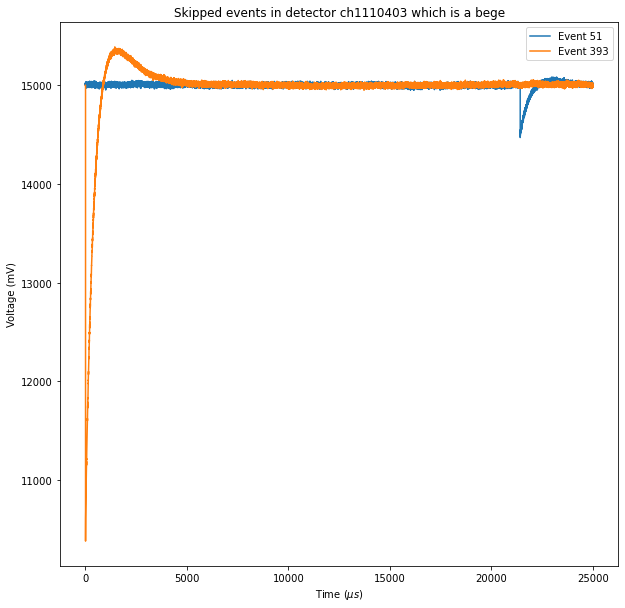

This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [37, 88, 130, 467, 827, 962, 1317]
Percentage of discharges present: 0.4957507082152923%


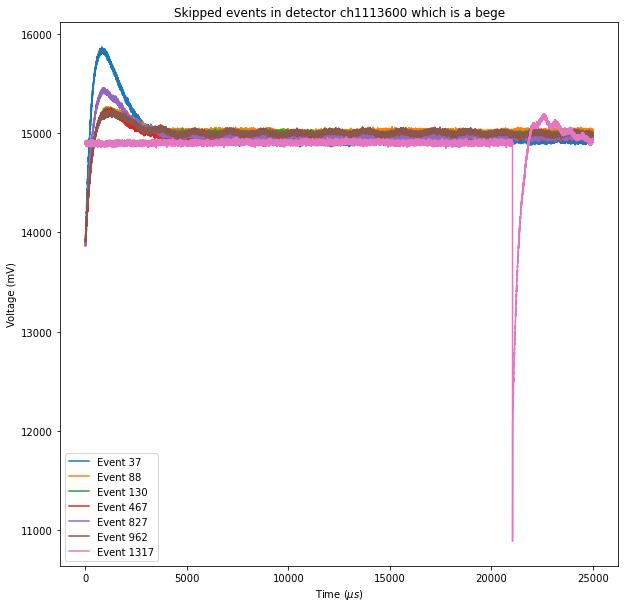

Skipped waveforms for detector ch1113601: [37, 88, 130, 467, 858, 962]
Percentage of discharges present: 0.4249291784702569%


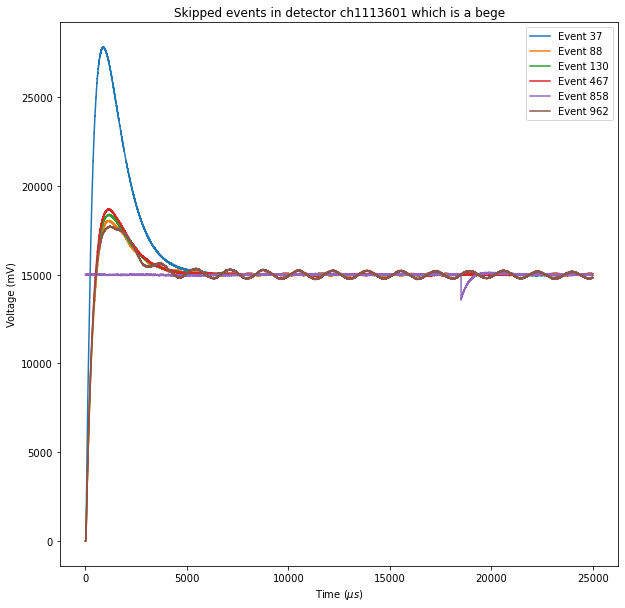

Skipped waveforms for detector ch1113602: [139, 858, 978, 1265, 1272, 1292]
Percentage of discharges present: 0.4249291784702569%


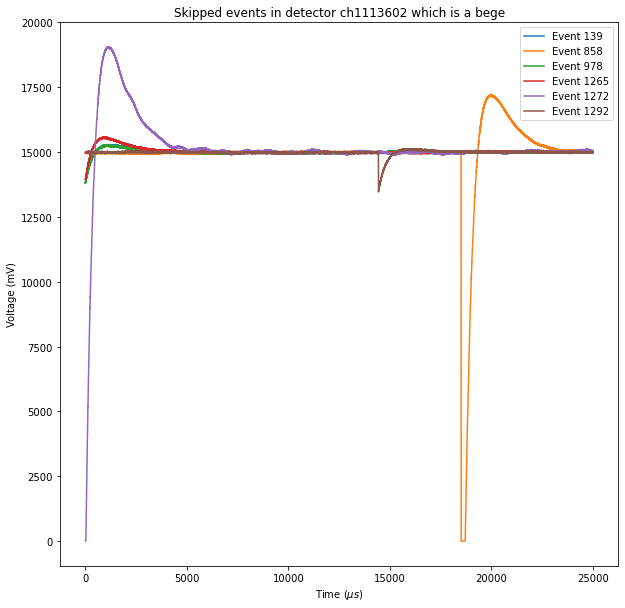

Skipped waveforms for detector ch1113603: [139, 978]
Percentage of discharges present: 0.14164305949008194%


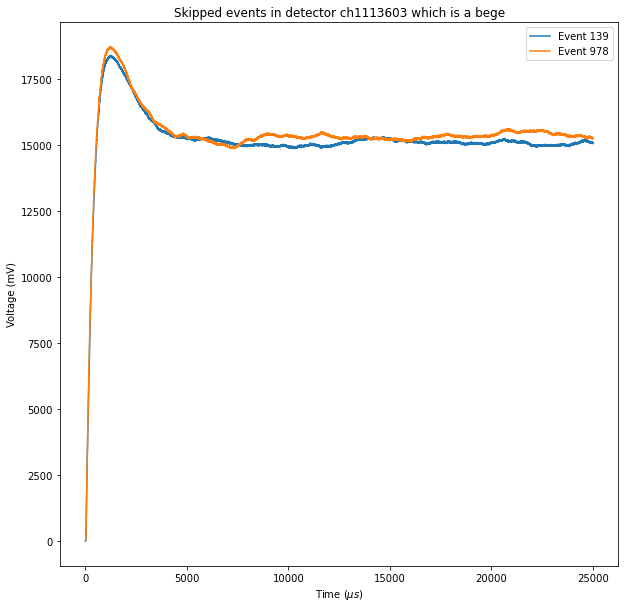

Skipped waveforms for detector ch1113604: [514, 1161]
Percentage of discharges present: 0.14164305949008194%


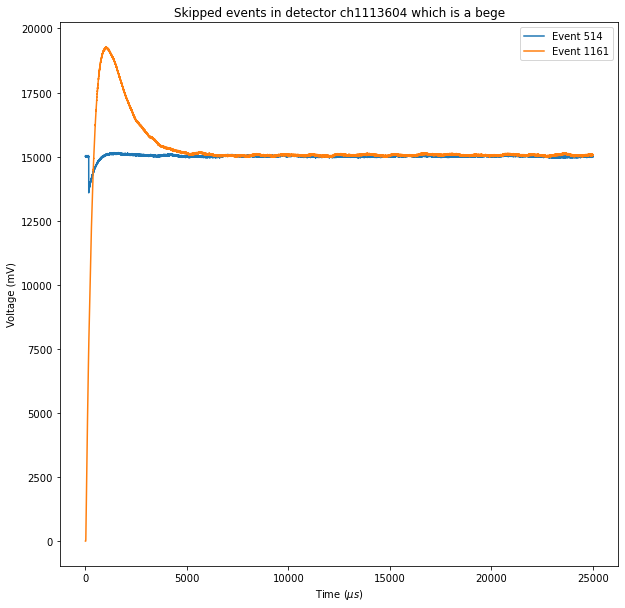

This detector ch1113605 doesn't have any discharges
Skipped waveforms for detector ch1120003: [62, 210, 456, 478, 532, 546, 672, 982, 1200, 1405]
Percentage of discharges present: 0.7082152974504208%


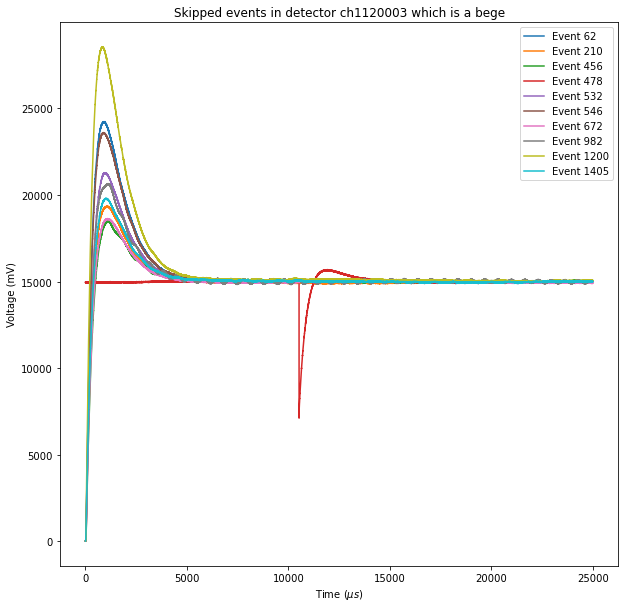

Skipped waveforms for detector ch1120004: [389, 397, 761, 1227]
Percentage of discharges present: 0.283286118980175%


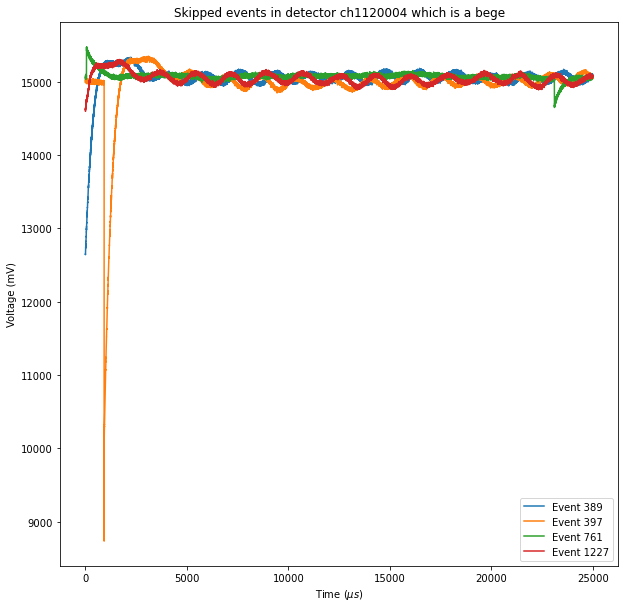

This detector ch1078405 doesn't have any discharges
Skipped waveforms for detector ch1080000: [494, 501, 1097, 1303]
Percentage of discharges present: 0.283286118980175%


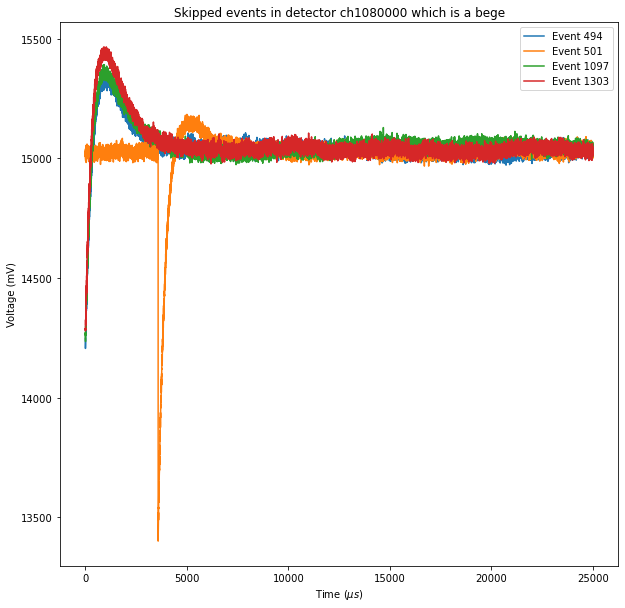

Skipped waveforms for detector ch1080001: [494, 1097, 1303]
Percentage of discharges present: 0.21246458923512845%


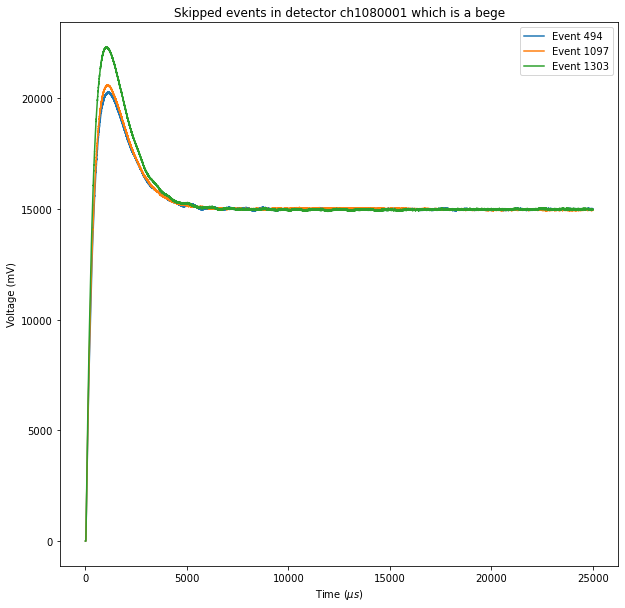

This detector ch1080002 doesn't have any discharges
This detector ch1083200 doesn't have any discharges
Skipped waveforms for detector ch1083201: [85, 430, 448, 506, 850, 906, 1094]
Percentage of discharges present: 0.4957507082152923%


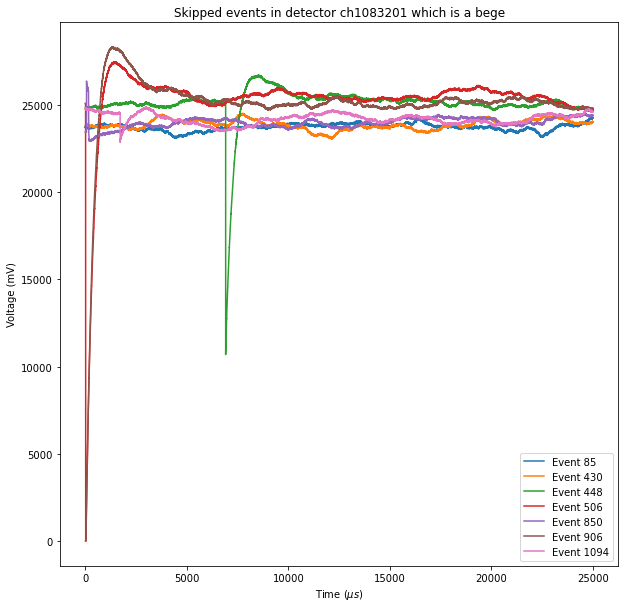

Skipped waveforms for detector ch1083202: [474, 506, 1160, 1402]
Percentage of discharges present: 0.283286118980175%


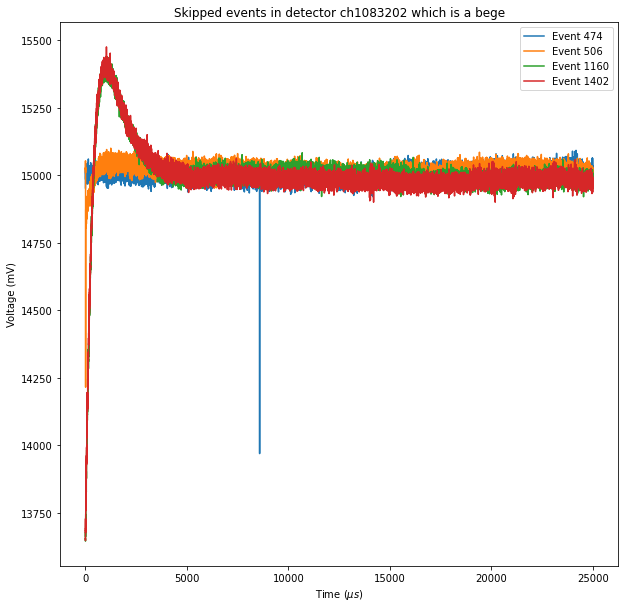

Skipped waveforms for detector ch1083203: [32, 437, 573, 1160, 1224, 1402]
Percentage of discharges present: 0.4249291784702569%


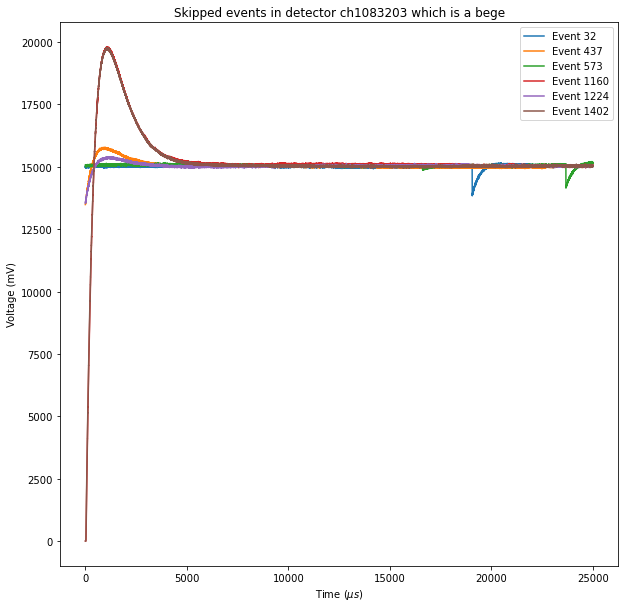

Skipped waveforms for detector ch1083204: [437, 474, 1224]
Percentage of discharges present: 0.21246458923512845%


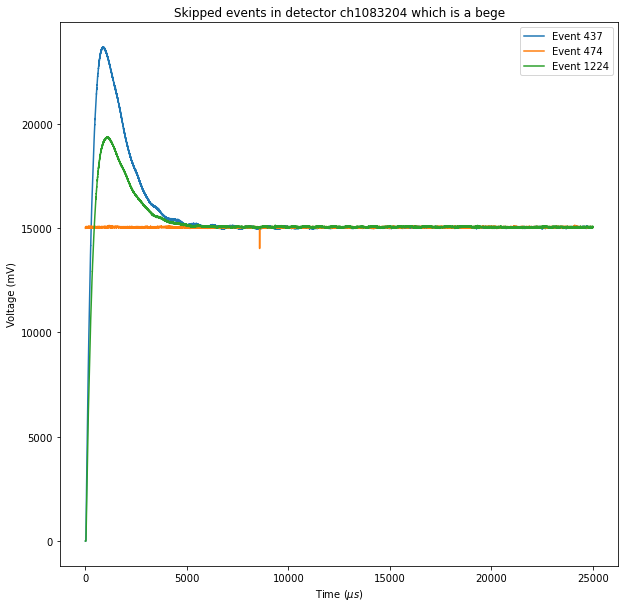

Skipped waveforms for detector ch1083205: [408, 474, 506, 1313]
Percentage of discharges present: 0.283286118980175%


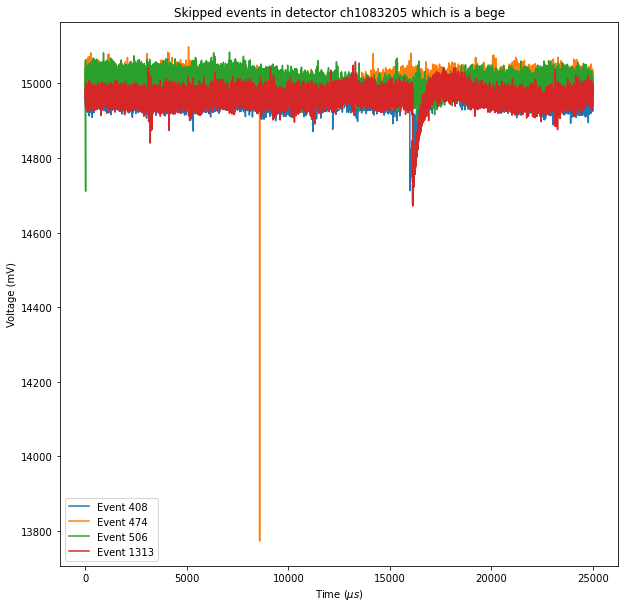

Skipped waveforms for detector ch1084800: [408, 444, 474, 481, 1129]
Percentage of discharges present: 0.3541076487252104%


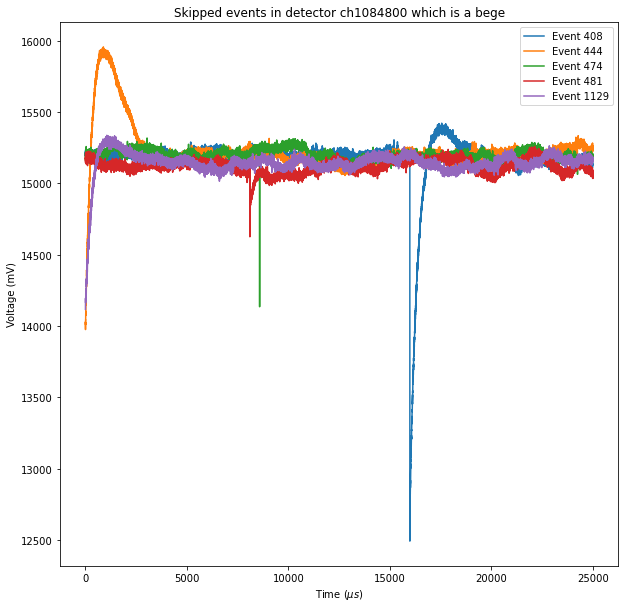

Skipped waveforms for detector ch1084801: [444, 474, 481, 791, 1129]
Percentage of discharges present: 0.3541076487252104%


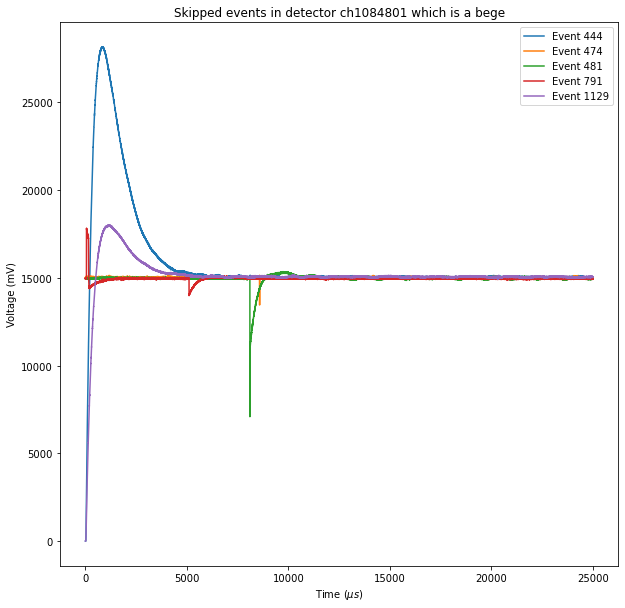

Skipped waveforms for detector ch1084802: [474, 495]
Percentage of discharges present: 0.14164305949008194%


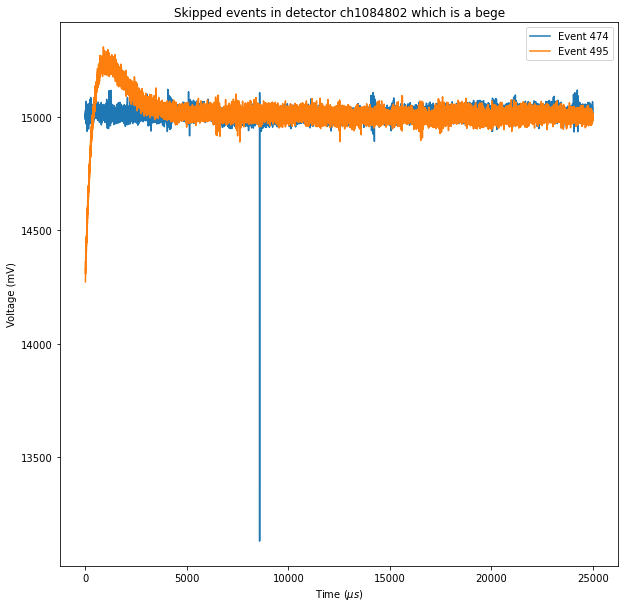

This detector ch1086403 doesn't have any discharges
This detector ch1086404 doesn't have any discharges
Skipped waveforms for detector ch1086405: [163]
Percentage of discharges present: 0.07082152974504652%


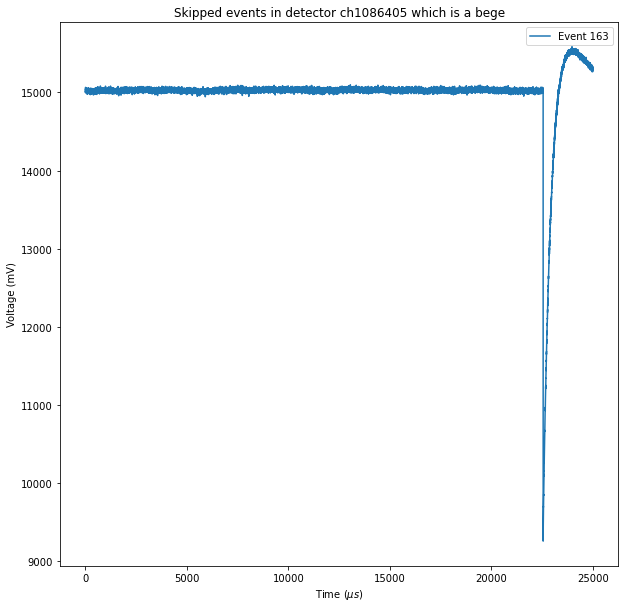

In [15]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1  # Store all skipped indices for the detector
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform

        # Customize plot
        plt.xlabel('Time ($\mu s$)')
        plt.ylabel('Voltage (mV)')
        plt.title(f'Skipped events in detector {j} which is a {test}')
        plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Another selection criteria which states that if the size of the skipped indices is larger than 20, after the 2 cuts, this suggests we have no discharges.

DISCHARGE
Maximum difference: 436.8, 5624.8
Next maximum difference: 6610.400000000001, 6879.200000000001


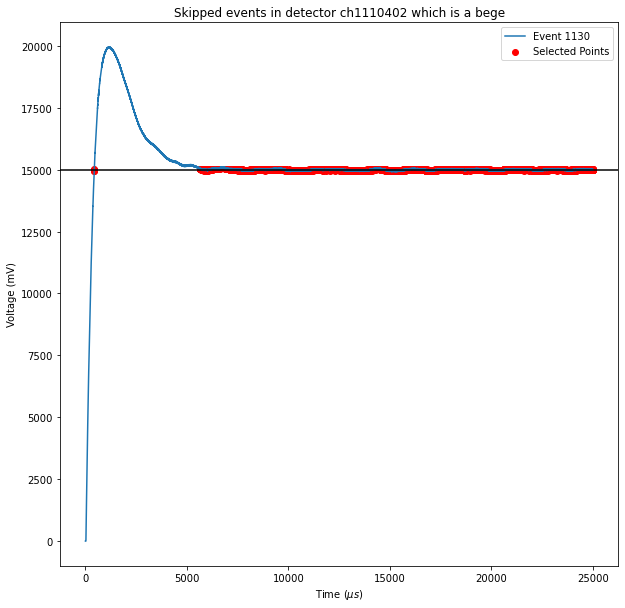

DISCHARGE
Maximum difference: 496.8, 5360.8
Next maximum difference: 8828.800000000001, 8840.800000000001


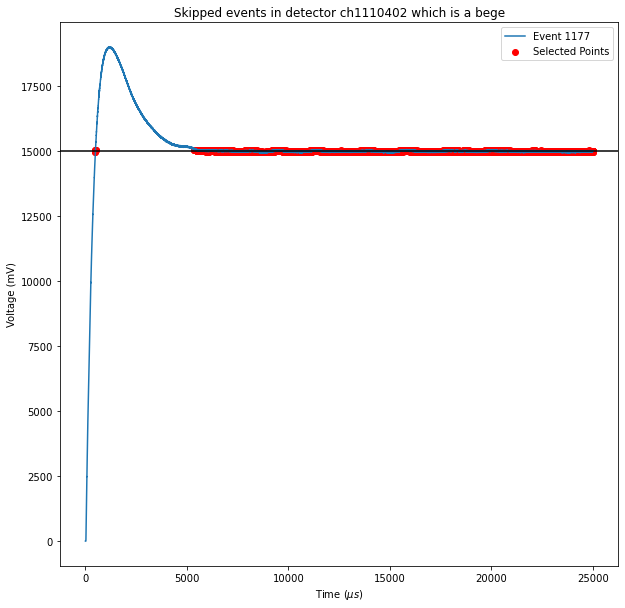

MICRODISCHARGE
Maximum difference: 16102.400000000001, 19123.2
Next Maximum difference: 15227.2, 16040.0


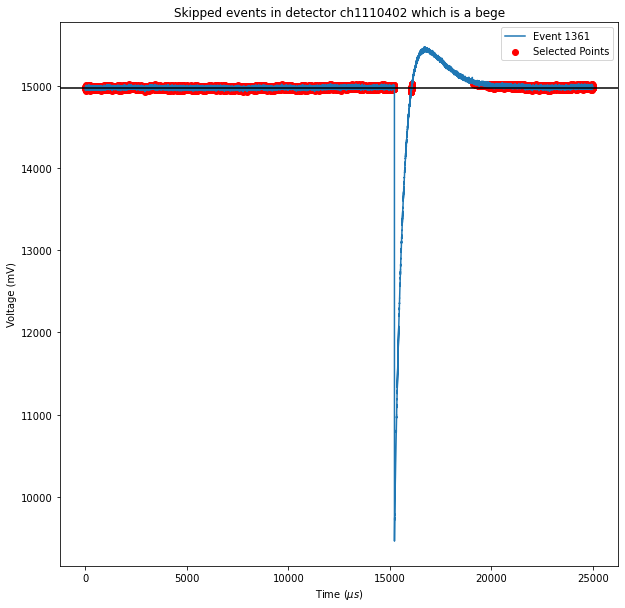

MICRODISCHARGE
Maximum difference: 21425.600000000002, 22080.800000000003
Next Maximum difference: 22080.800000000003, 22100.0


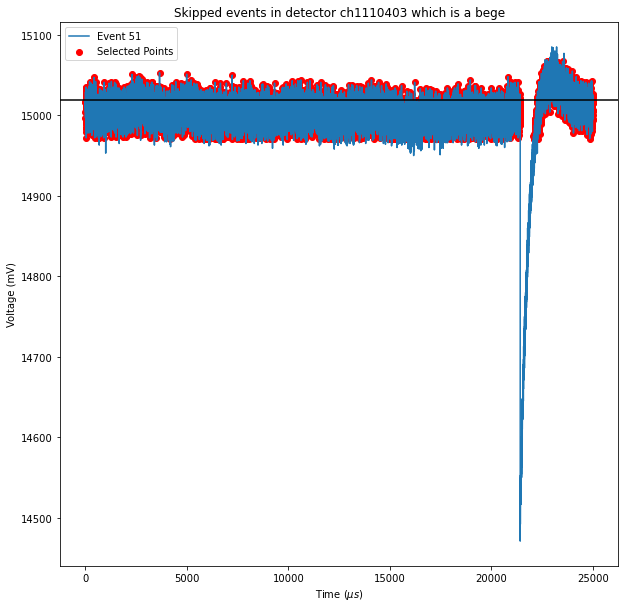

MICRODISCHARGE
Maximum difference: 932.8000000000001, 3331.2000000000003
Next Maximum difference: 4.0, 833.6


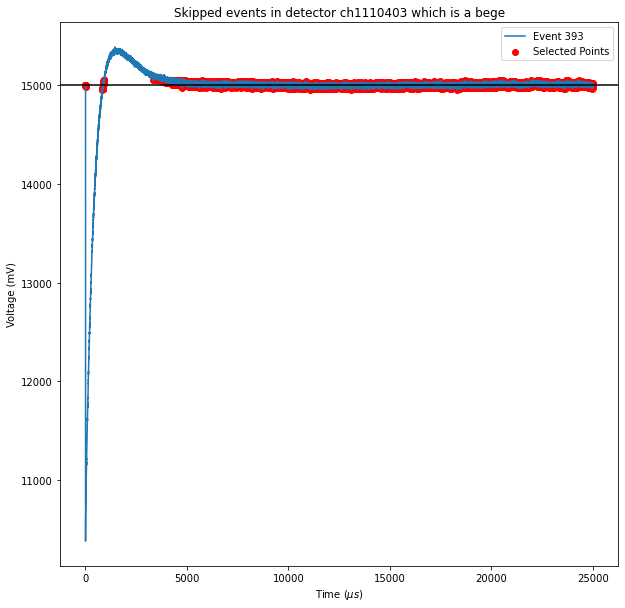

MICRODISCHARGE
Maximum difference: 215.20000000000002, 3340.0
Next Maximum difference: 3340.0, 3432.0


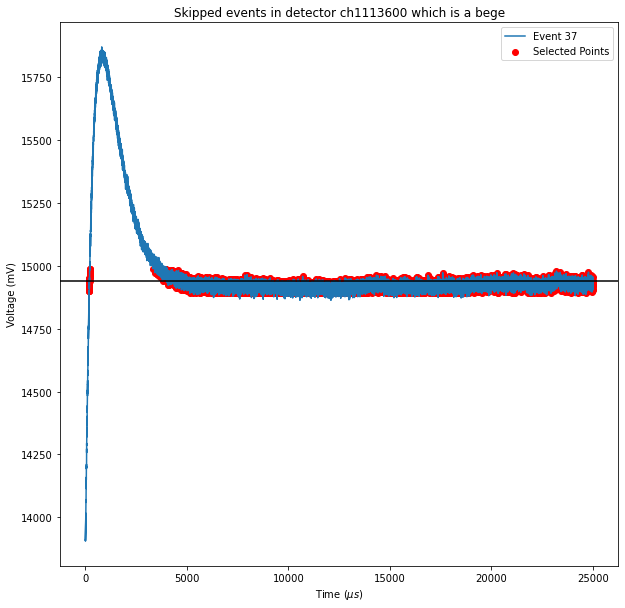

MICRODISCHARGE
Maximum difference: 629.6, 2364.8
Next Maximum difference: 2488.8, 2520.0


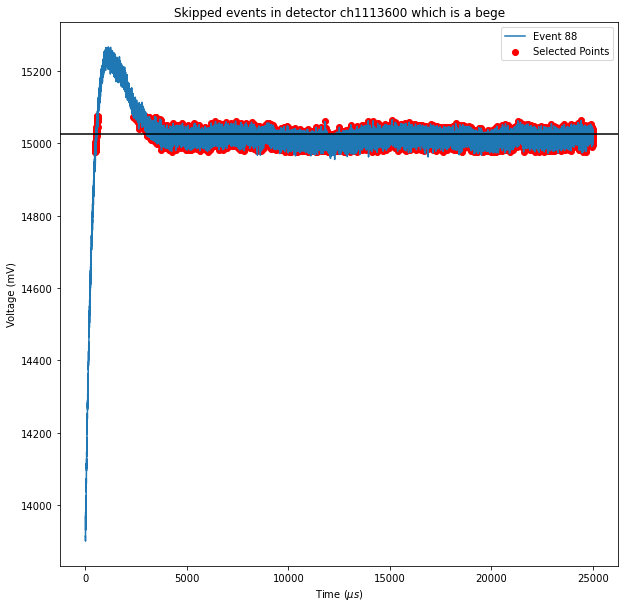

MICRODISCHARGE
Maximum difference: 573.6, 2528.8
Next Maximum difference: 2528.8, 2672.0


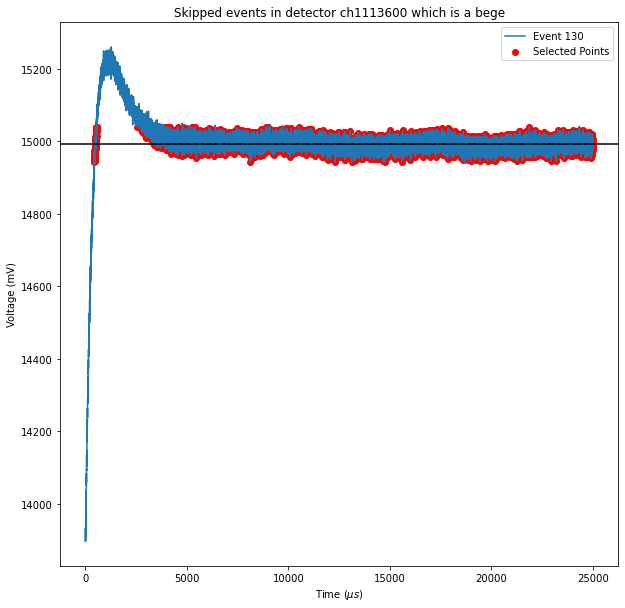

MICRODISCHARGE
Maximum difference: 582.4, 2439.2000000000003
Next Maximum difference: 2533.6000000000004, 2568.8


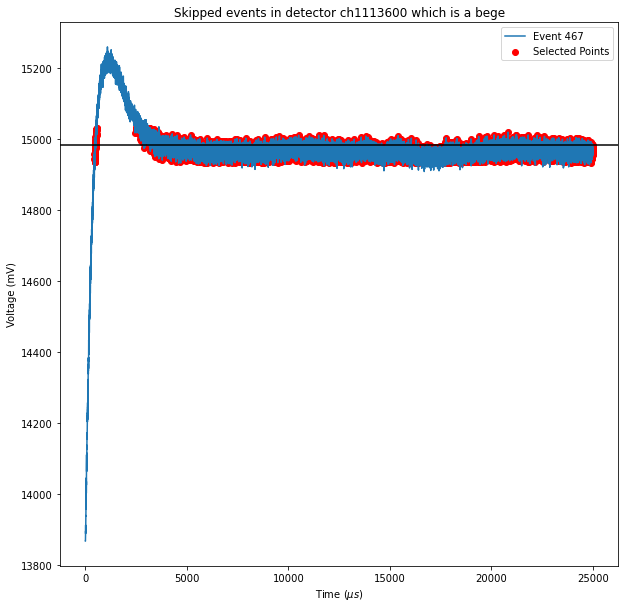

MICRODISCHARGE
Maximum difference: 374.40000000000003, 2836.0
Next Maximum difference: 2836.0, 2912.0


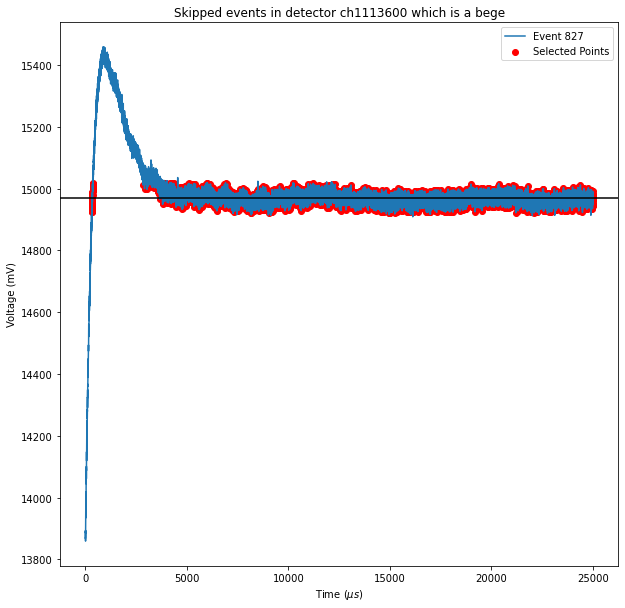

MICRODISCHARGE
Maximum difference: 588.0, 2531.2000000000003
Next Maximum difference: 2540.8, 2588.0


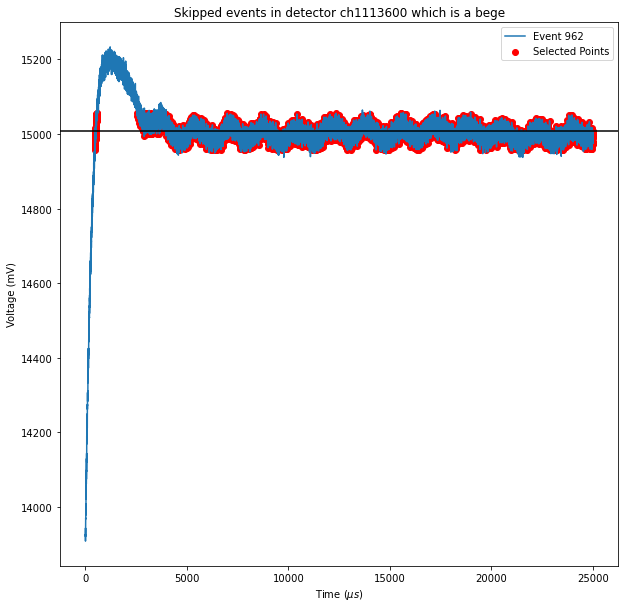

MICRODISCHARGE
Maximum difference: 21937.600000000002, 23488.0
Next Maximum difference: 21048.0, 21819.2


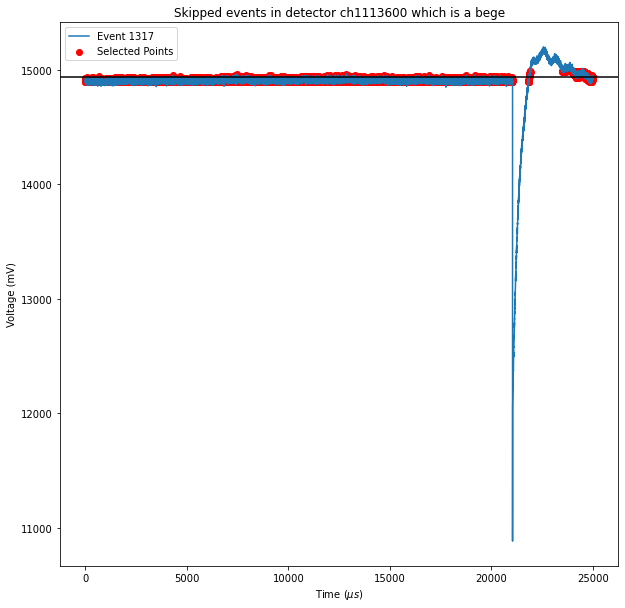

DISCHARGE
Maximum difference: 228.8, 5776.8
Next maximum difference: 5776.8, 5816.0


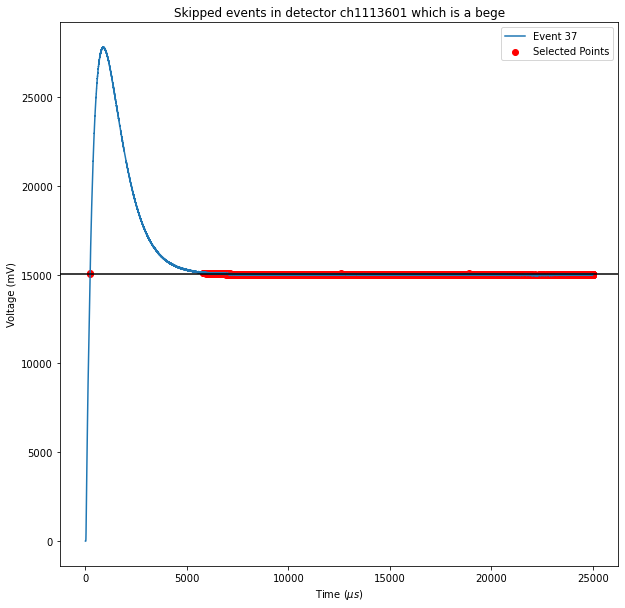

DISCHARGE
Maximum difference: 564.8000000000001, 4800.0
Next maximum difference: 5319.200000000001, 5485.6


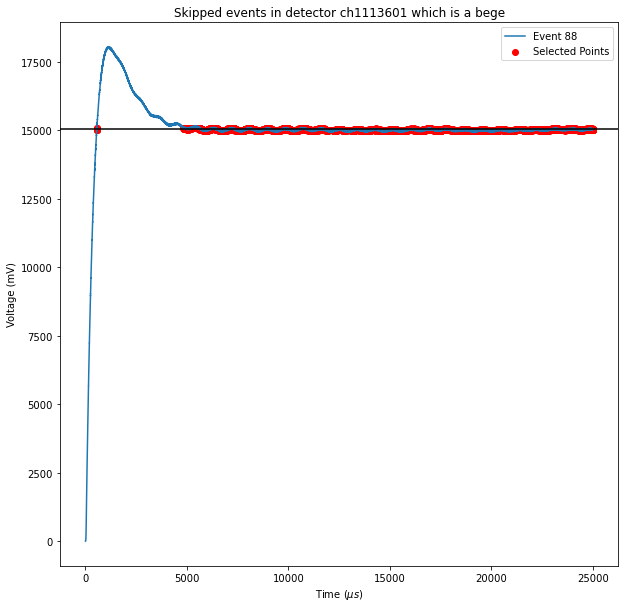

DISCHARGE
Maximum difference: 516.8000000000001, 5583.200000000001
Next maximum difference: 5674.400000000001, 5818.400000000001


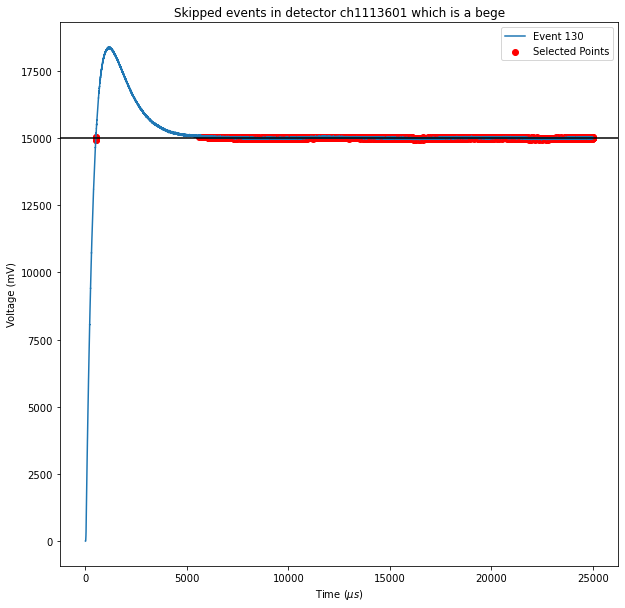

DISCHARGE
Maximum difference: 494.40000000000003, 5104.8
Next maximum difference: 5201.6, 5409.6


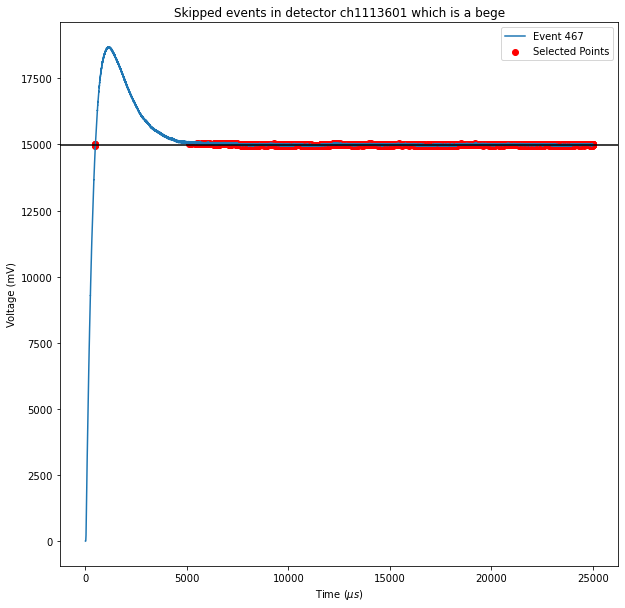

MICRODISCHARGE
Maximum difference: 19552.8, 20797.600000000002
Next Maximum difference: 18511.2, 19169.600000000002


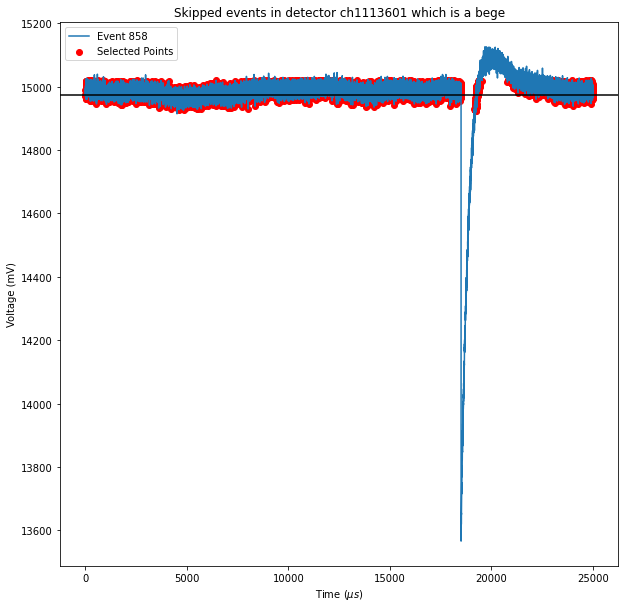

DISCHARGE
Maximum difference: 519.2, 4504.0
Next maximum difference: 4780.0, 6068.0


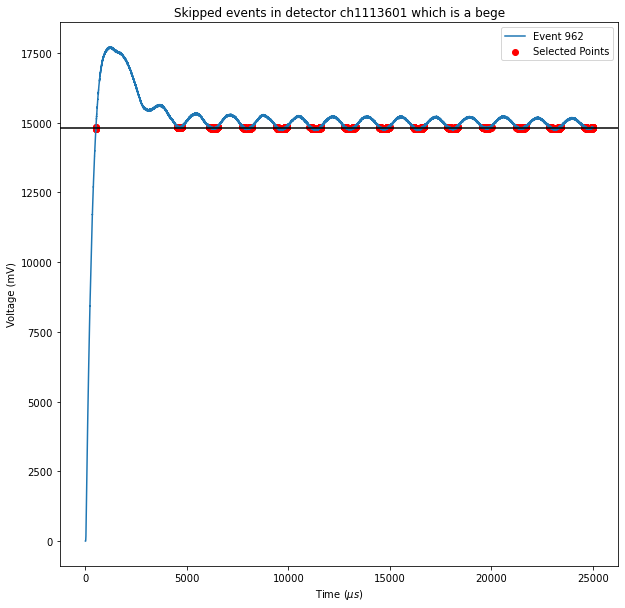

MICRODISCHARGE
Maximum difference: 524.8000000000001, 3255.2000000000003
Next Maximum difference: 3320.8, 3376.0


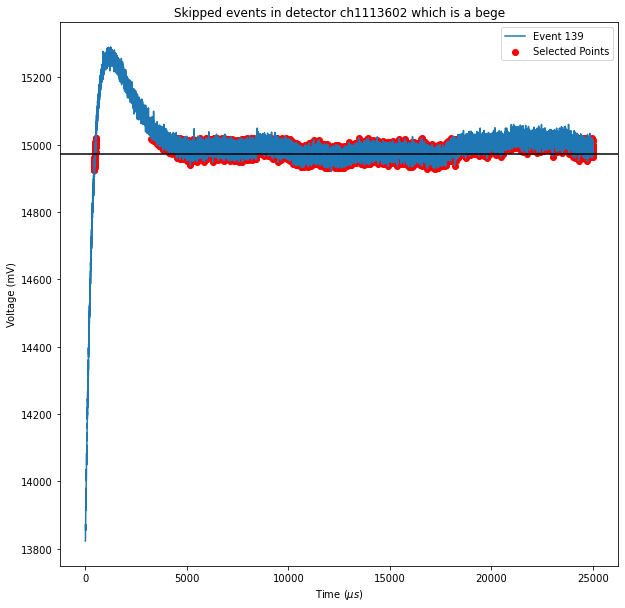

DISCHARGE
Maximum difference: 19338.4, 23211.2
Next maximum difference: 18510.4, 19328.0


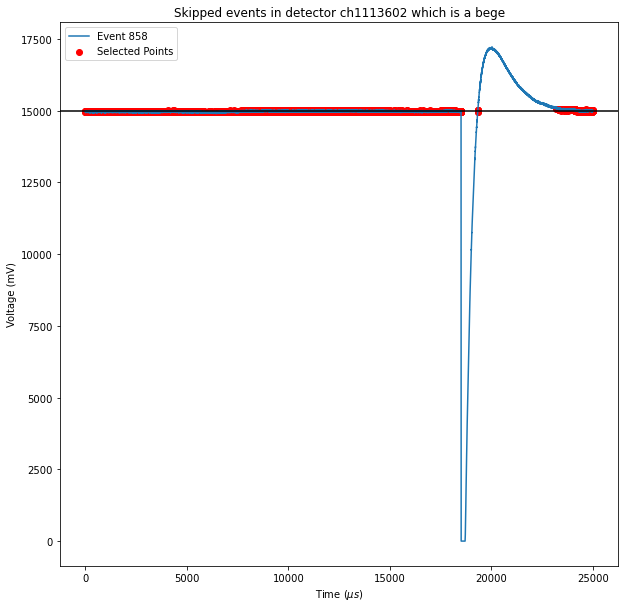

MICRODISCHARGE
Maximum difference: 556.8000000000001, 2839.2000000000003
Next Maximum difference: 2873.6000000000004, 2939.2000000000003


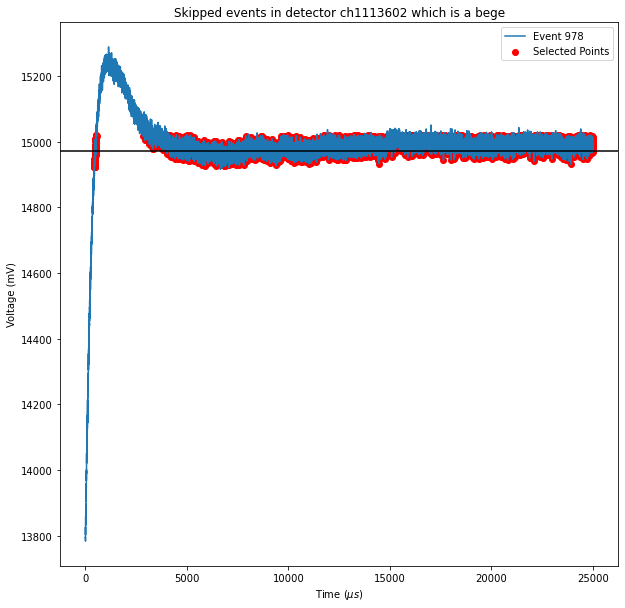

MICRODISCHARGE
Maximum difference: 330.40000000000003, 3051.2000000000003
Next Maximum difference: 3083.2000000000003, 3142.4


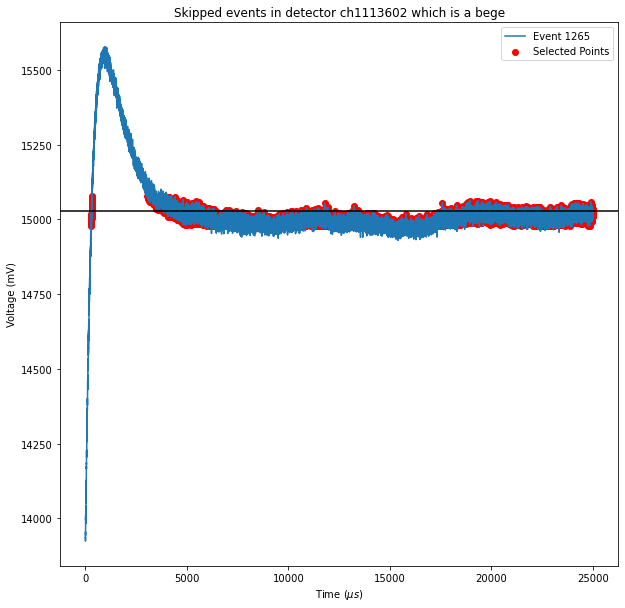

DISCHARGE
Maximum difference: 476.0, 4910.400000000001
Next maximum difference: 14896.0, 15537.6


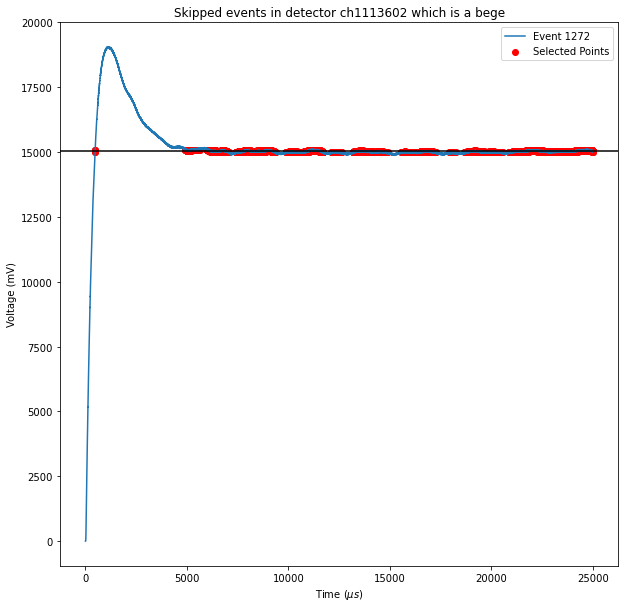

MICRODISCHARGE
Maximum difference: 15434.400000000001, 16899.2
Next Maximum difference: 14439.2, 15139.2


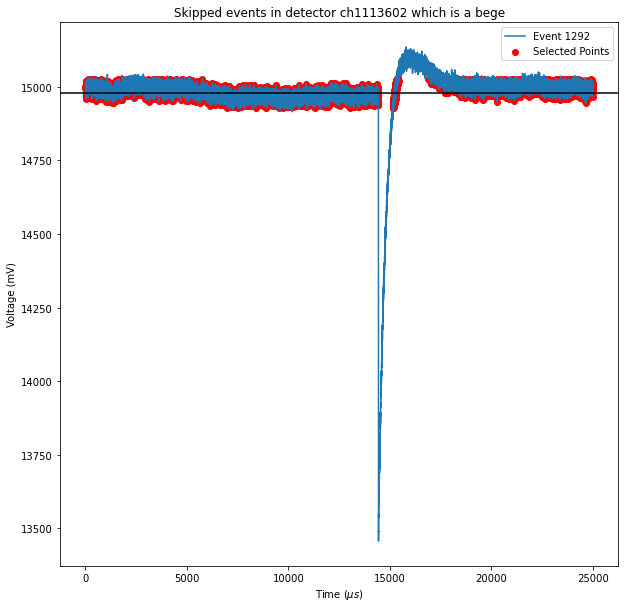

DISCHARGE
Maximum difference: 556.0, 6604.0
Next maximum difference: 8702.4, 11048.800000000001


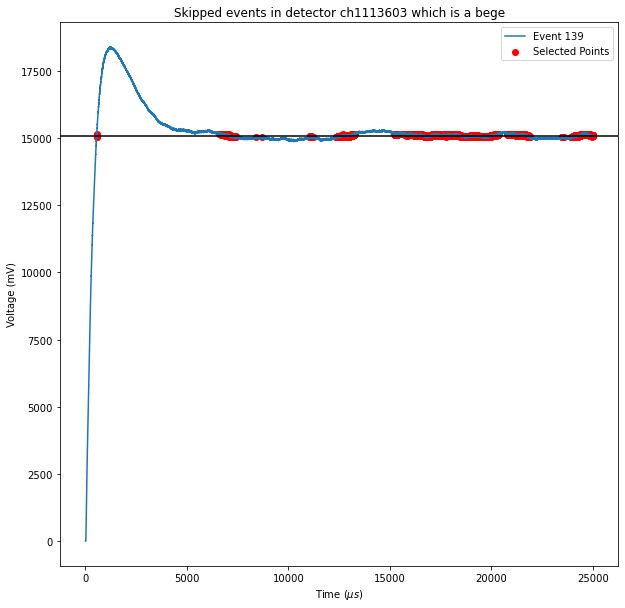

DISCHARGE
Maximum difference: 19676.0, 23950.4
Next maximum difference: 549.6, 4424.8


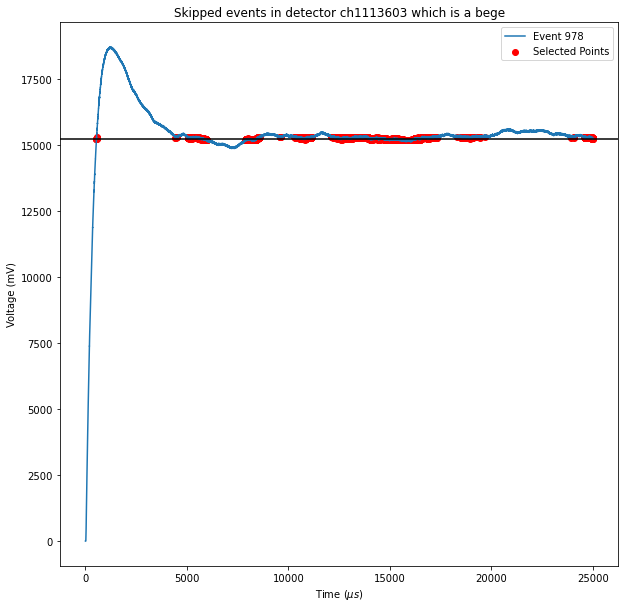

MICRODISCHARGE
Maximum difference: 1112.8, 1840.0
Next Maximum difference: 161.60000000000002, 768.0


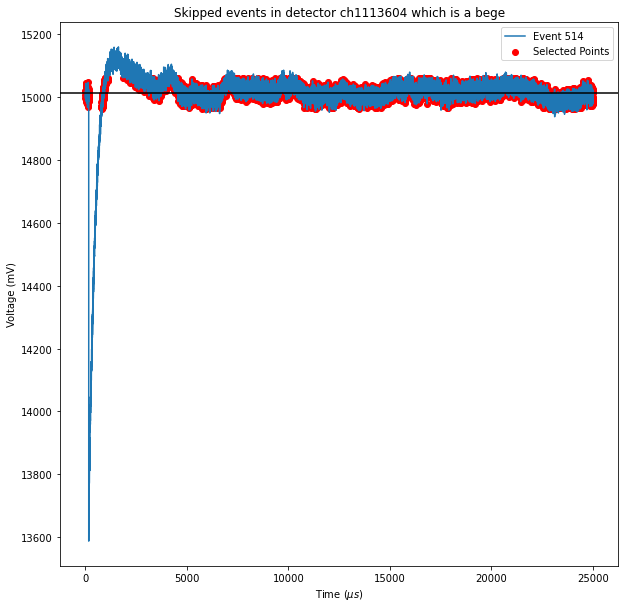

DISCHARGE
Maximum difference: 417.6, 4788.8
Next maximum difference: 4788.8, 4879.2


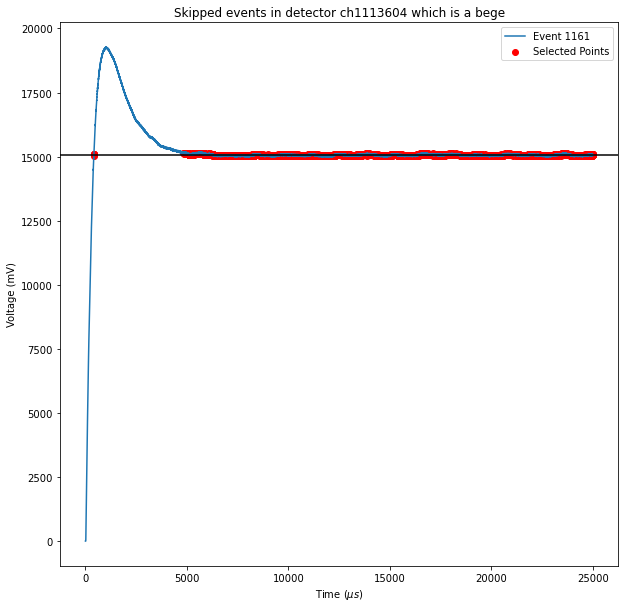

DISCHARGE
Maximum difference: 271.2, 5964.8
Next maximum difference: 7210.400000000001, 7345.6


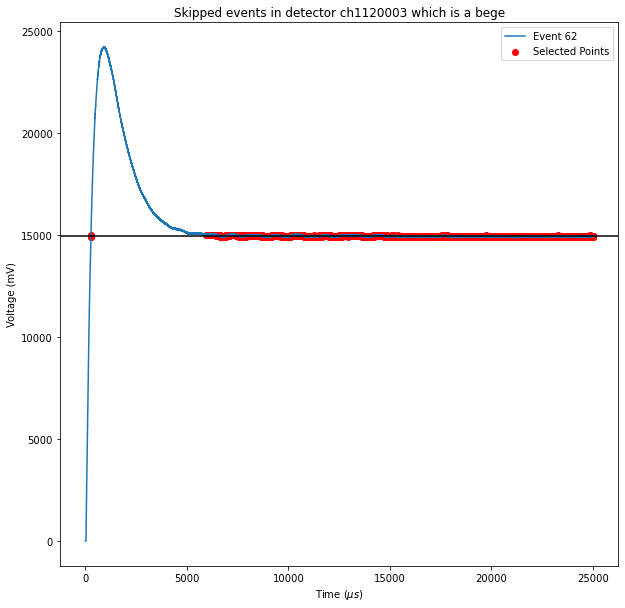

DISCHARGE
Maximum difference: 422.40000000000003, 5101.6
Next maximum difference: 5101.6, 5250.400000000001


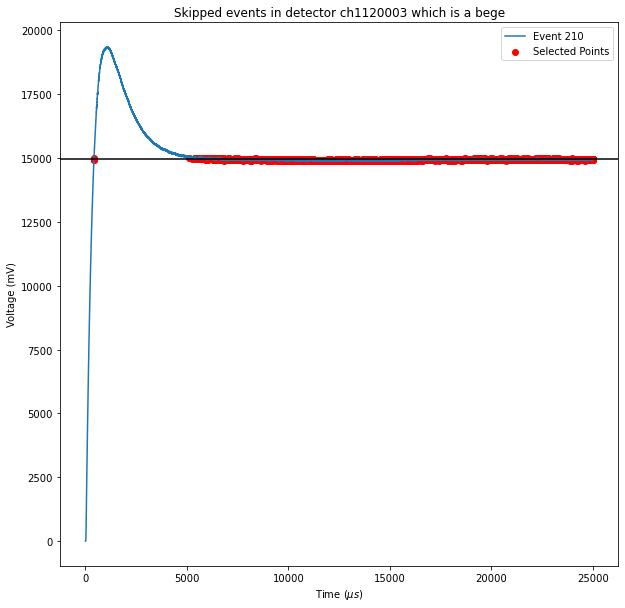

DISCHARGE
Maximum difference: 500.8, 4912.8
Next maximum difference: 5161.6, 5547.200000000001


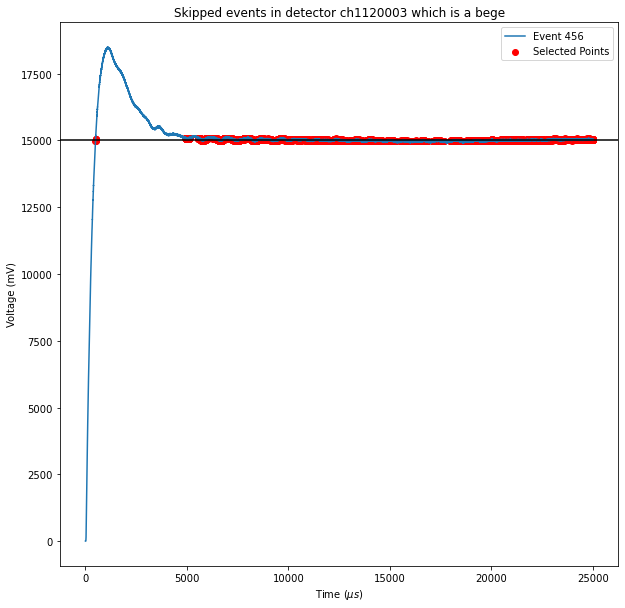

MICRODISCHARGE
Maximum difference: 11298.400000000001, 14156.800000000001
Next Maximum difference: 10527.2, 11256.800000000001


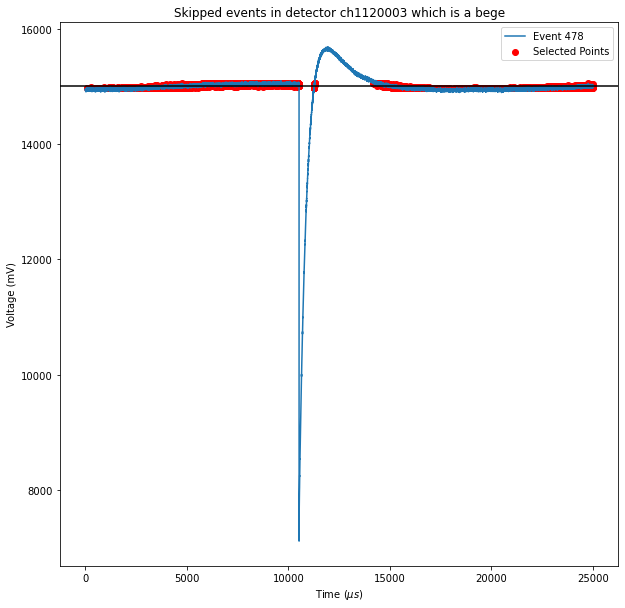

DISCHARGE
Maximum difference: 351.20000000000005, 5303.200000000001
Next maximum difference: 5303.200000000001, 5916.0


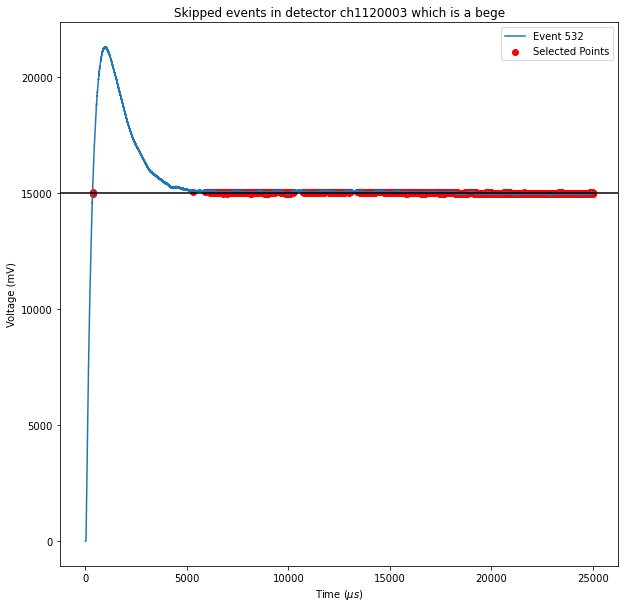

DISCHARGE
Maximum difference: 280.0, 5483.200000000001
Next maximum difference: 5744.0, 5940.0


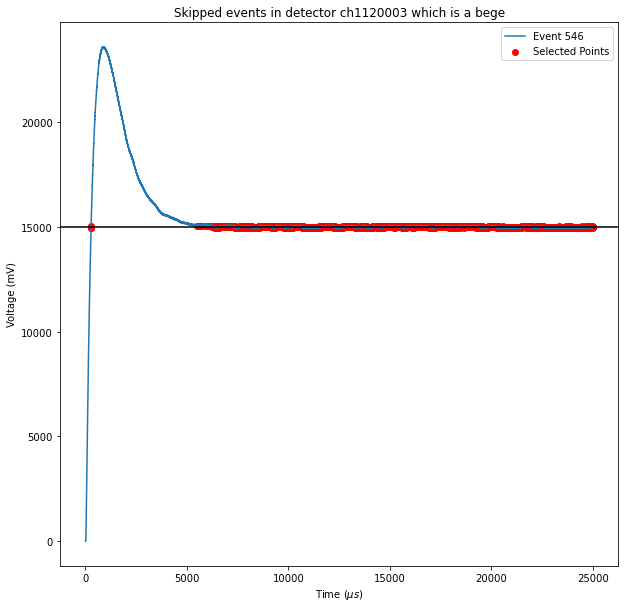

DISCHARGE
Maximum difference: 465.6, 5807.200000000001
Next maximum difference: 13029.6, 17651.2


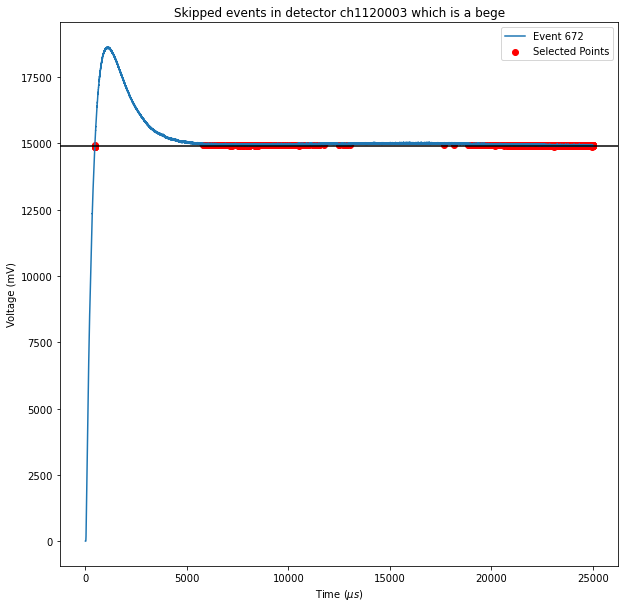

DISCHARGE
Maximum difference: 373.6, 4728.0
Next maximum difference: 24452.800000000003, 24784.800000000003


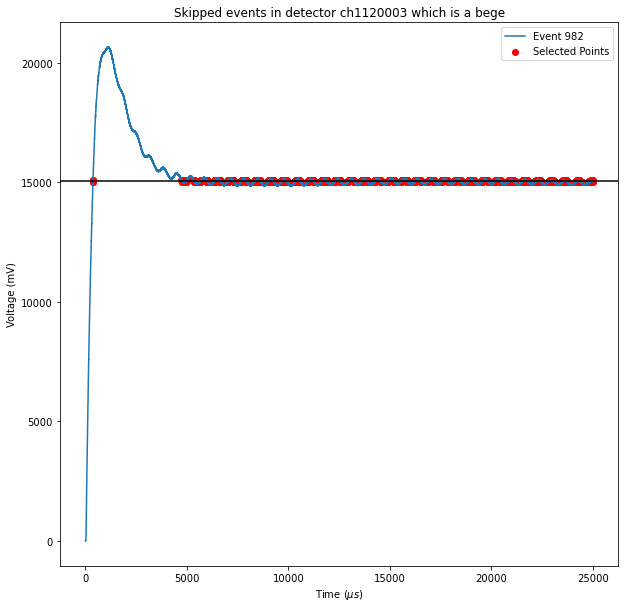

DISCHARGE
Maximum difference: 209.60000000000002, 6356.0
Next maximum difference: 12633.6, 13365.6


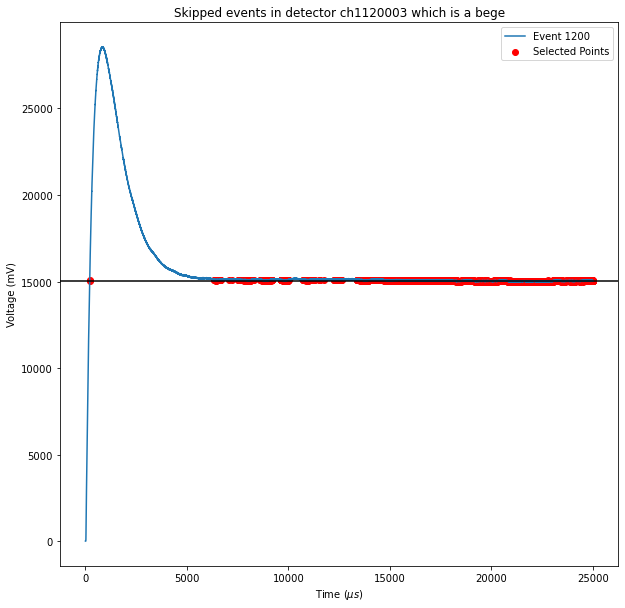

DISCHARGE
Maximum difference: 402.40000000000003, 5644.0
Next maximum difference: 5644.0, 6073.6


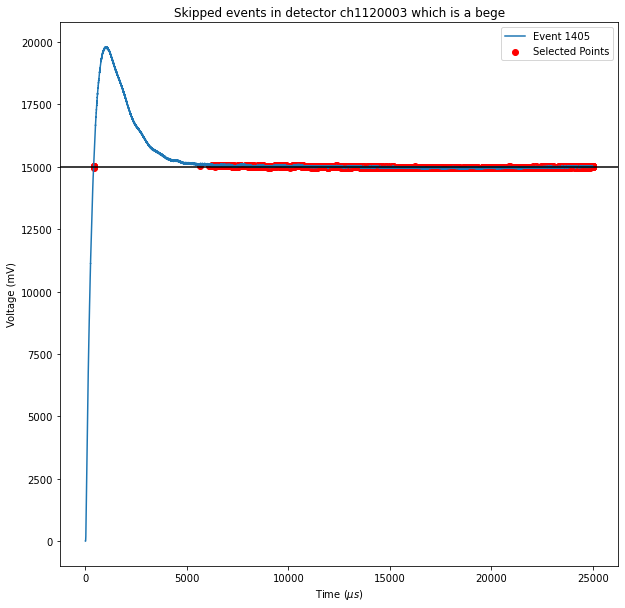

MICRODISCHARGE
Maximum difference: 748.0, 2736.0
Next Maximum difference: 8246.4, 8860.0


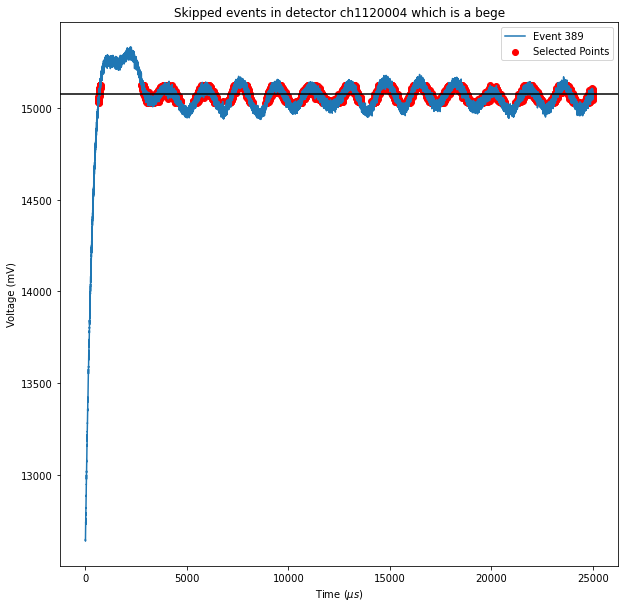

MICRODISCHARGE
Maximum difference: 1836.8000000000002, 3873.6000000000004
Next Maximum difference: 12547.2, 13691.2


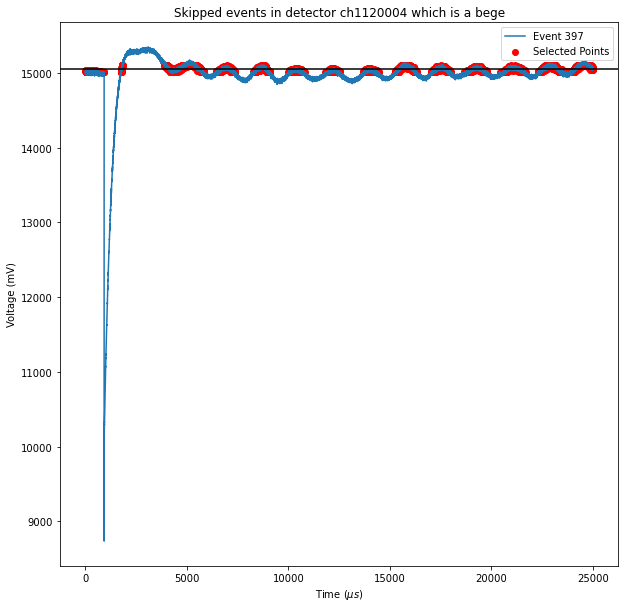

MICRODISCHARGE
Maximum difference: 48.800000000000004, 936.8000000000001
Next Maximum difference: 23109.600000000002, 23672.800000000003


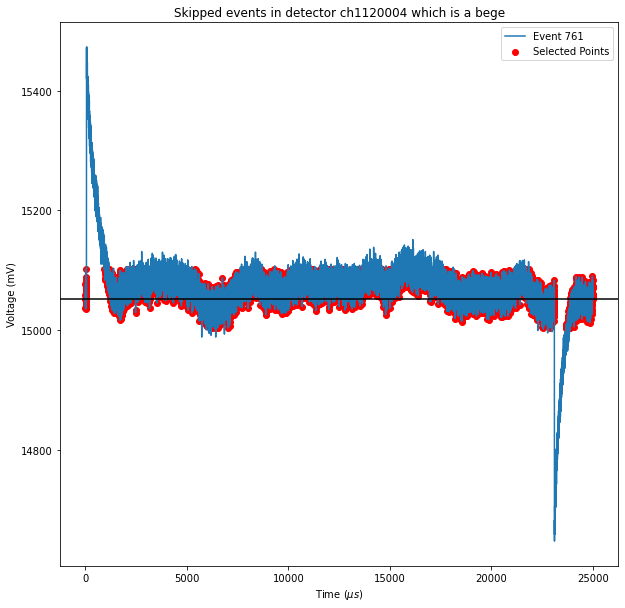

MICRODISCHARGE
Maximum difference: 389.6, 2218.4
Next Maximum difference: 21860.0, 22748.800000000003


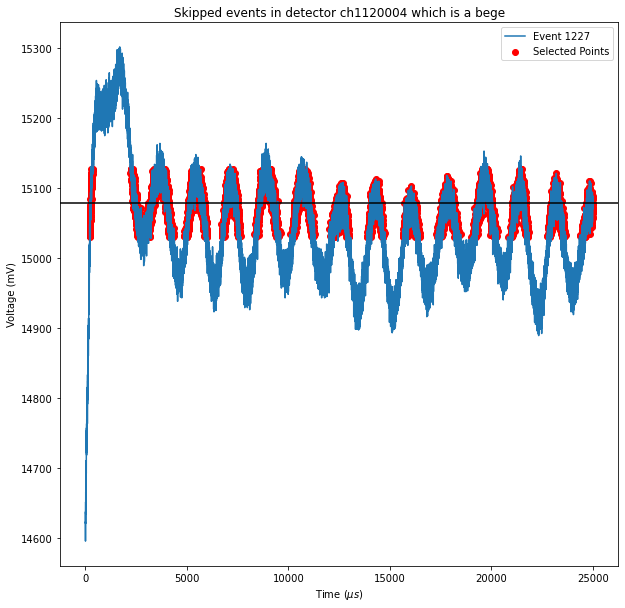

MICRODISCHARGE
Maximum difference: 424.0, 2700.8
Next Maximum difference: 2728.8, 2777.6000000000004


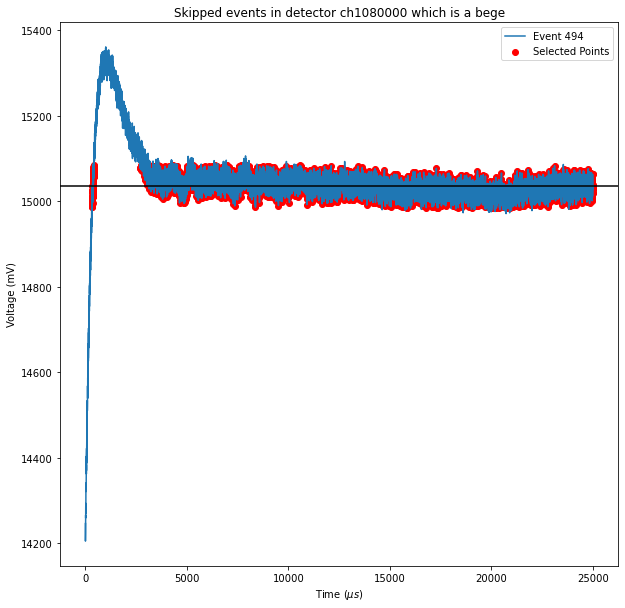

MICRODISCHARGE
Maximum difference: 4725.6, 5839.200000000001
Next Maximum difference: 3580.8, 4268.0


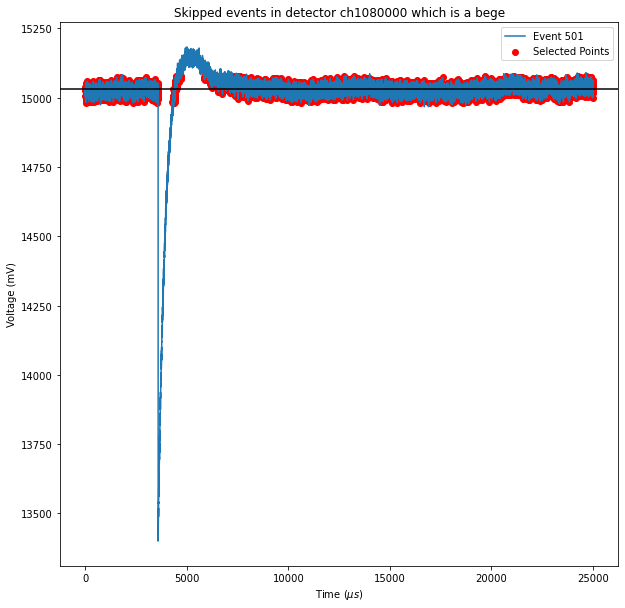

MICRODISCHARGE
Maximum difference: 398.40000000000003, 2816.8
Next Maximum difference: 2917.6000000000004, 2946.4


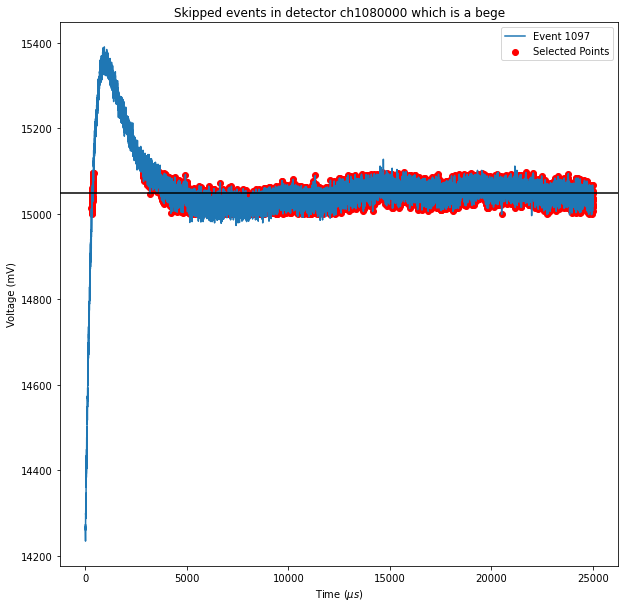

MICRODISCHARGE
Maximum difference: 300.8, 3108.0
Next Maximum difference: 3210.4, 3436.8


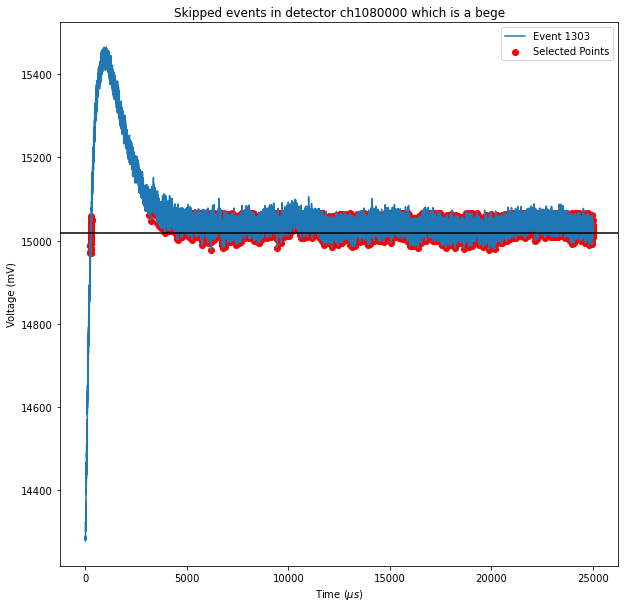

DISCHARGE
Maximum difference: 425.6, 5518.400000000001
Next maximum difference: 6115.200000000001, 6244.0


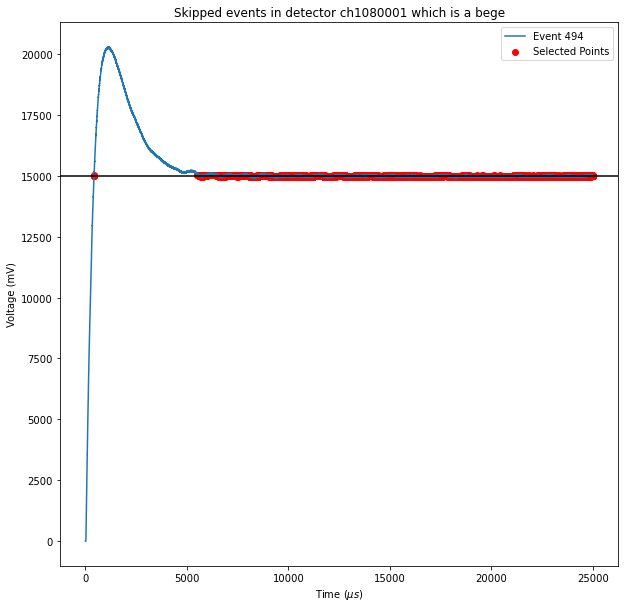

DISCHARGE
Maximum difference: 406.40000000000003, 6316.0
Next maximum difference: 10240.800000000001, 10453.6


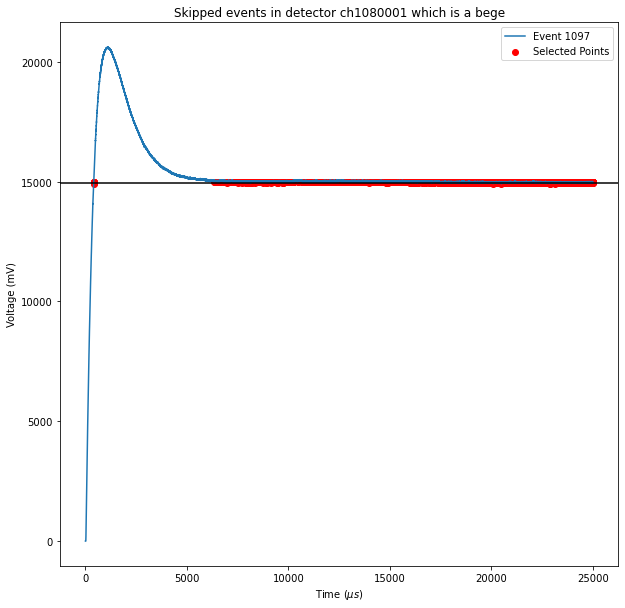

DISCHARGE
Maximum difference: 344.8, 5742.400000000001
Next maximum difference: 5759.200000000001, 6389.6


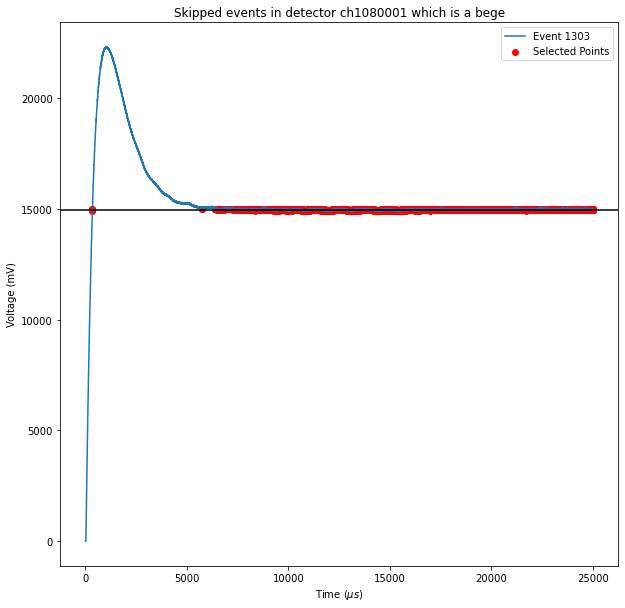

MICRODISCHARGE
Maximum difference: 24867.2, 24878.4
Next Maximum difference: 24859.2, 24864.0


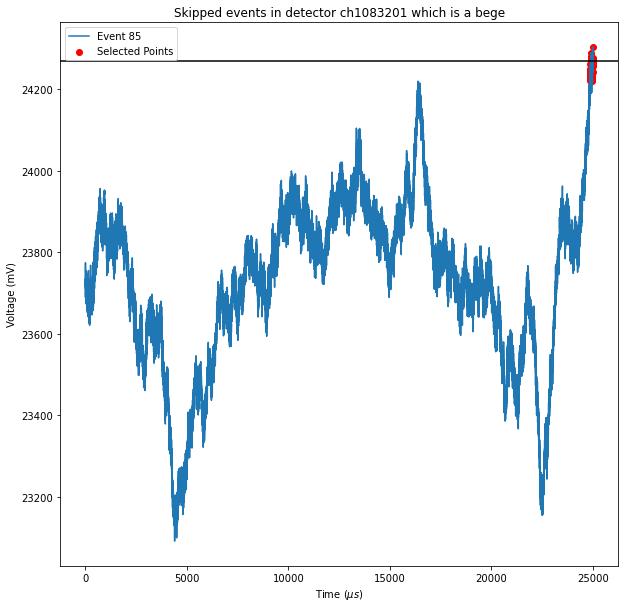

MICRODISCHARGE
Maximum difference: 9763.2, 19133.600000000002
Next Maximum difference: 21744.0, 23741.600000000002


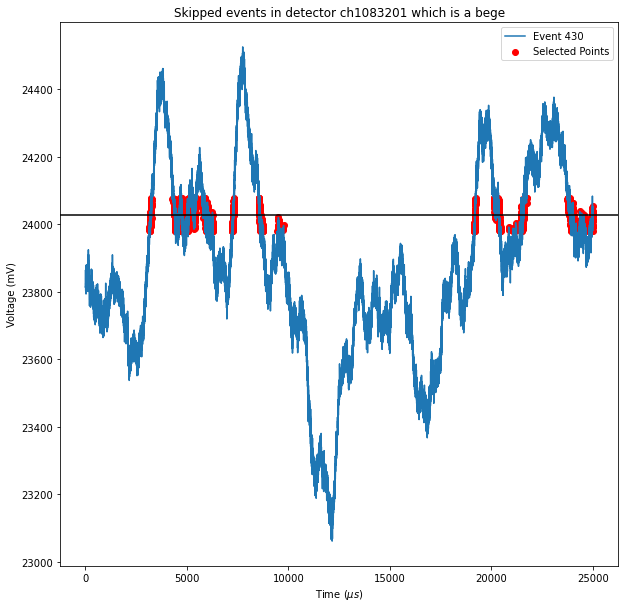

MICRODISCHARGE
Maximum difference: 7664.8, 17956.8
Next Maximum difference: 4239.2, 7650.400000000001


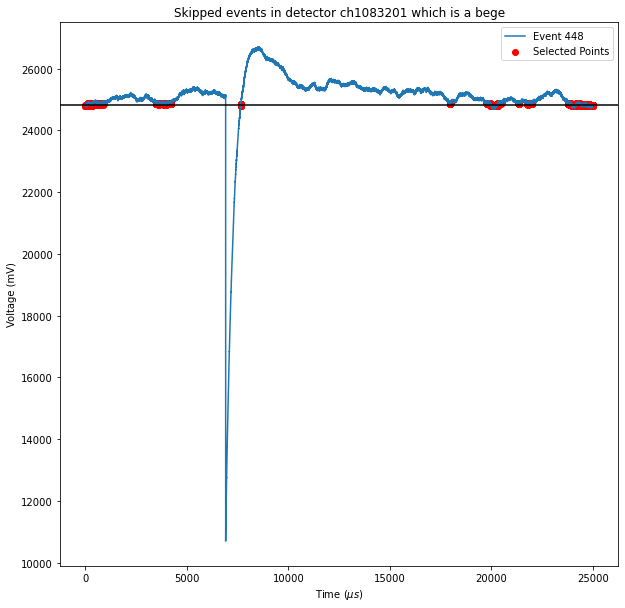

DISCHARGE
Maximum difference: 787.2, 24161.600000000002
Next maximum difference: 24480.0, 24611.2


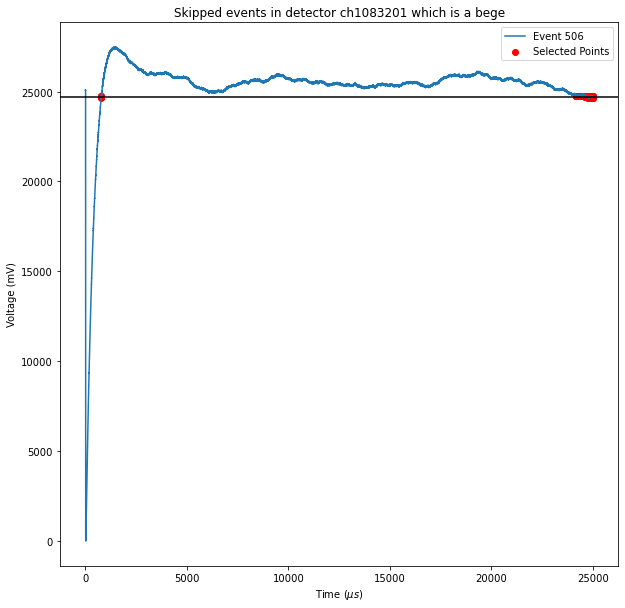

MICRODISCHARGE
Maximum difference: 155.20000000000002, 17316.8
Next Maximum difference: 18533.600000000002, 23208.800000000003


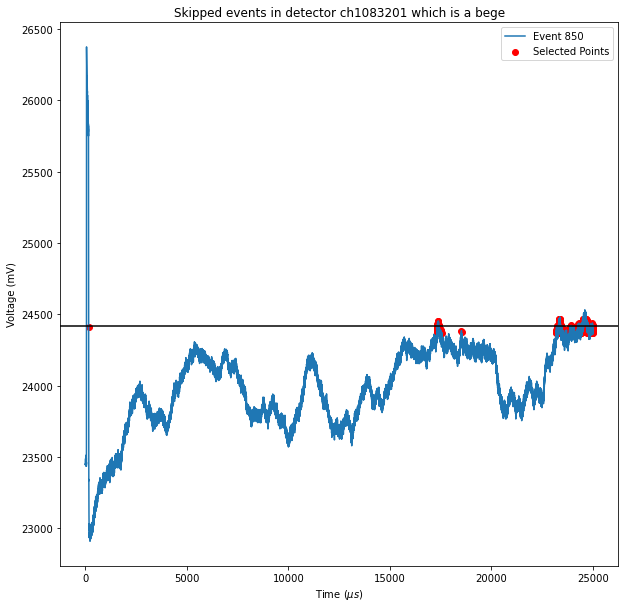

DISCHARGE
Maximum difference: 696.0, 24928.0
Next maximum difference: 24929.600000000002, 24939.2


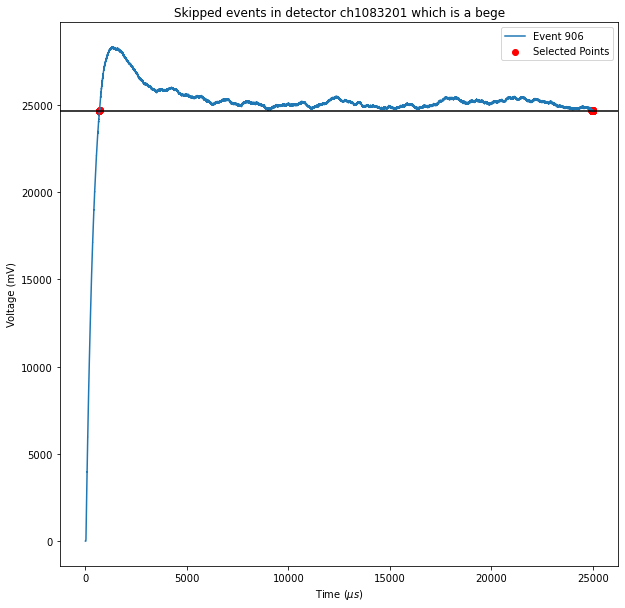

MICRODISCHARGE
Maximum difference: 13076.0, 22756.800000000003
Next Maximum difference: 3427.2000000000003, 11105.6


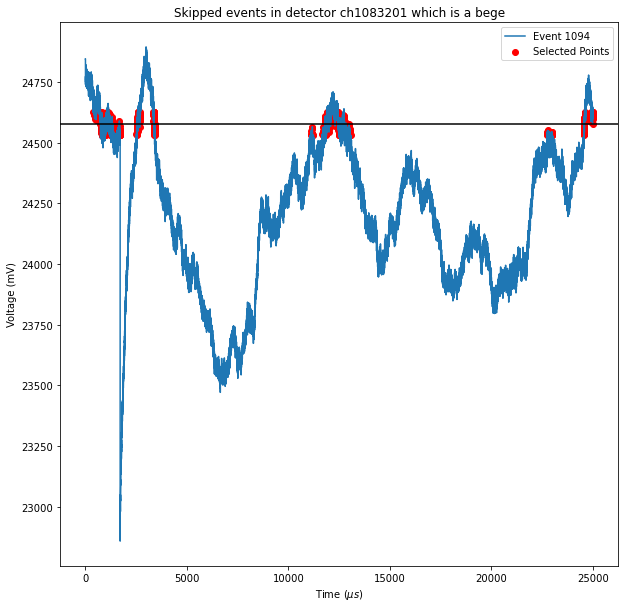

MICRODISCHARGE
Maximum difference: 8588.0, 8592.0
Next Maximum difference: 9317.6, 9320.800000000001


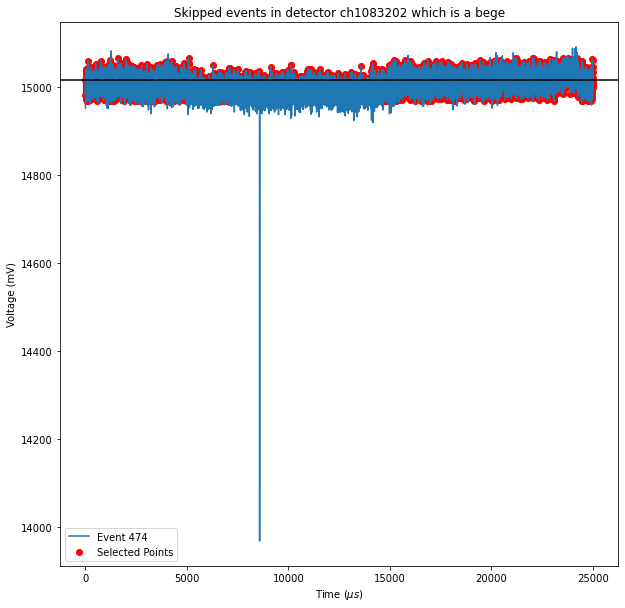

MICRODISCHARGE
Maximum difference: 7.2, 199.20000000000002
Next Maximum difference: 199.20000000000002, 217.60000000000002


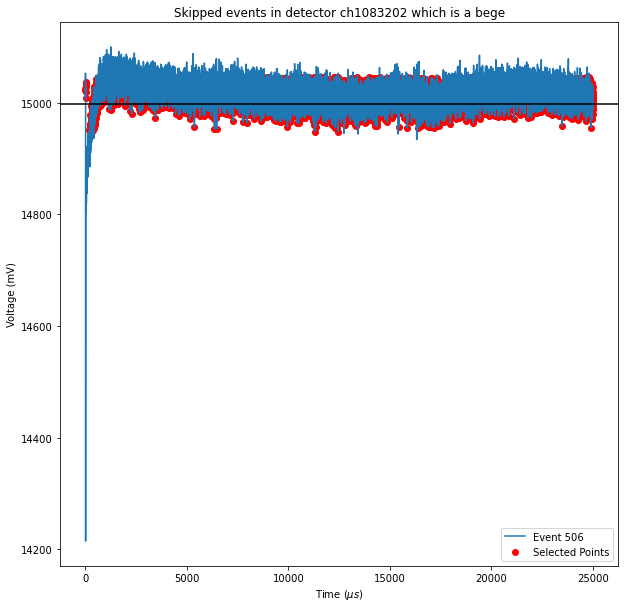

MICRODISCHARGE
Maximum difference: 448.8, 2649.6000000000004
Next Maximum difference: 2649.6000000000004, 2881.6000000000004


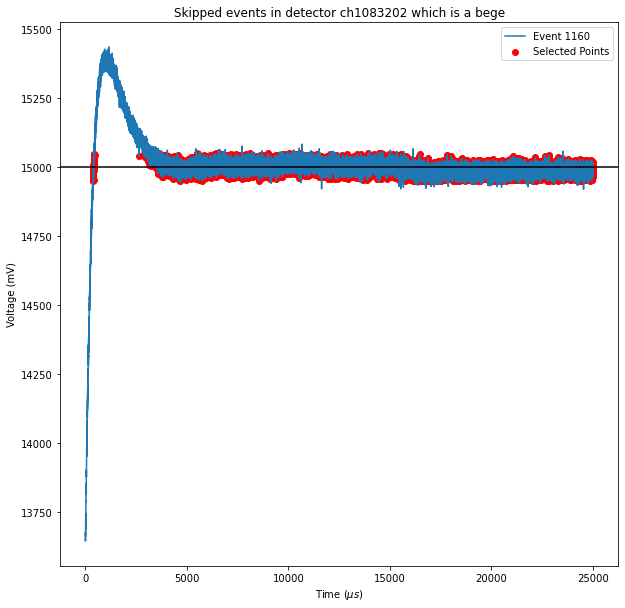

MICRODISCHARGE
Maximum difference: 432.8, 3021.6000000000004
Next Maximum difference: 3021.6000000000004, 3132.8


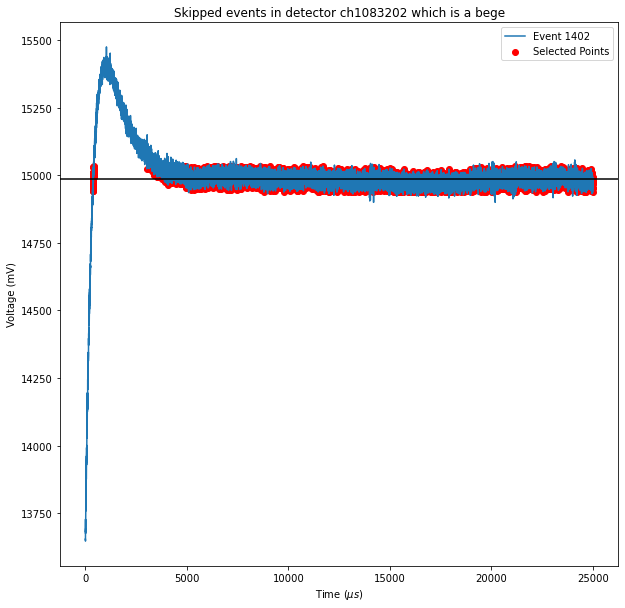

MICRODISCHARGE
Maximum difference: 19057.600000000002, 19742.4
Next Maximum difference: 20357.600000000002, 20439.2


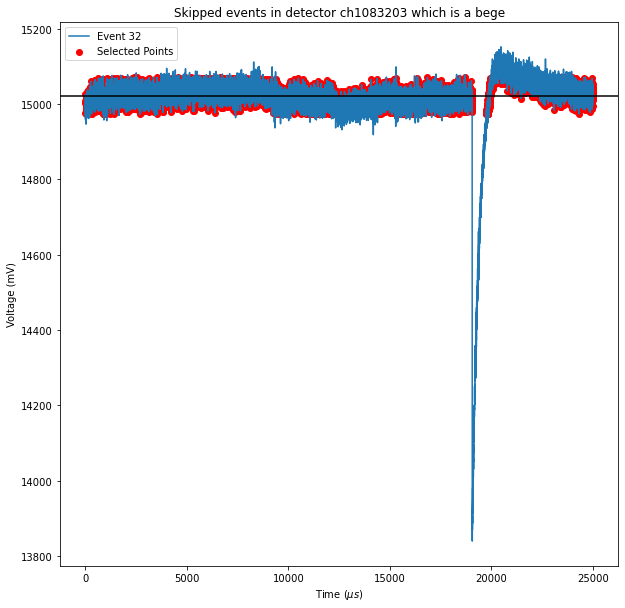

MICRODISCHARGE
Maximum difference: 337.6, 3246.4
Next Maximum difference: 3246.4, 3490.4


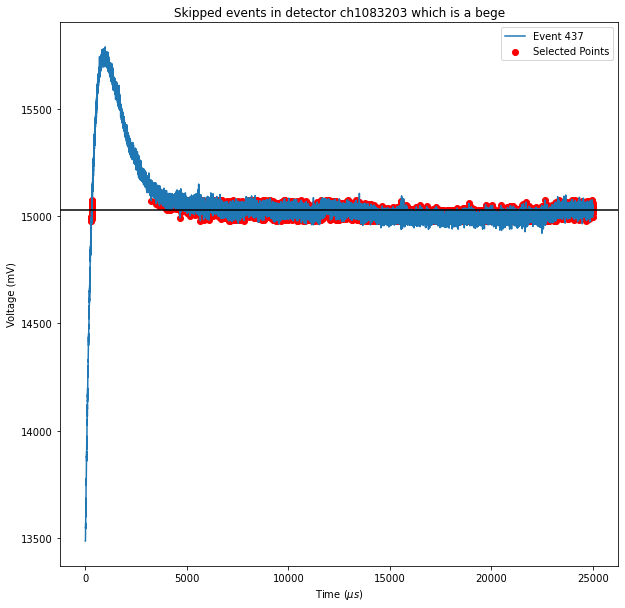

MICRODISCHARGE
Maximum difference: 9403.2, 18004.8
Next Maximum difference: 18004.8, 19899.2


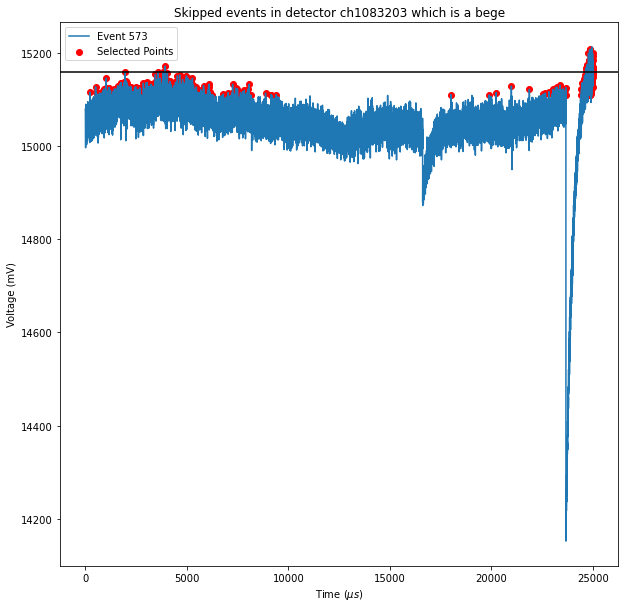

DISCHARGE
Maximum difference: 429.6, 5228.8
Next maximum difference: 5448.0, 5535.200000000001


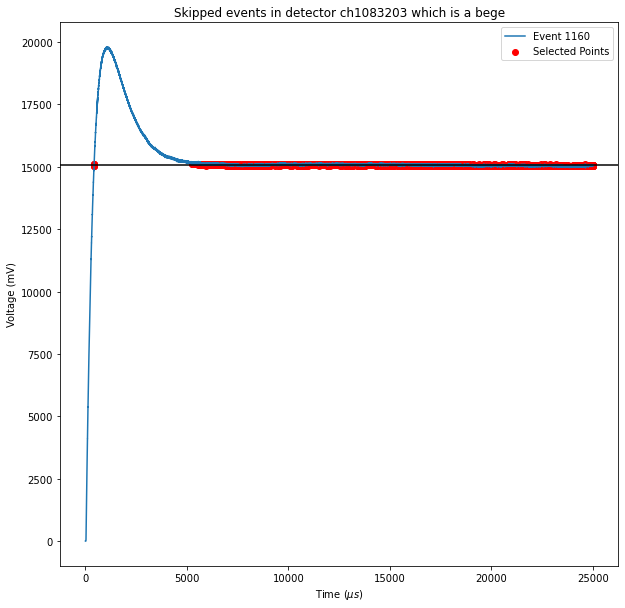

MICRODISCHARGE
Maximum difference: 524.8000000000001, 2720.0
Next Maximum difference: 2720.0, 2821.6000000000004


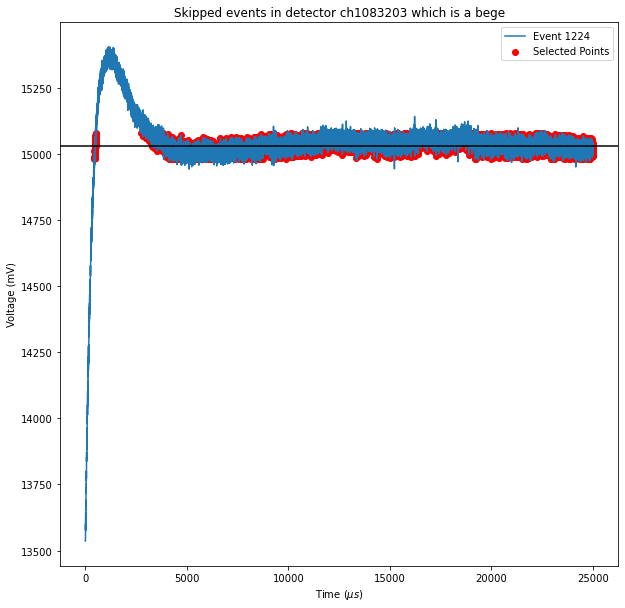

DISCHARGE
Maximum difference: 422.40000000000003, 5320.8
Next maximum difference: 5339.200000000001, 5386.400000000001


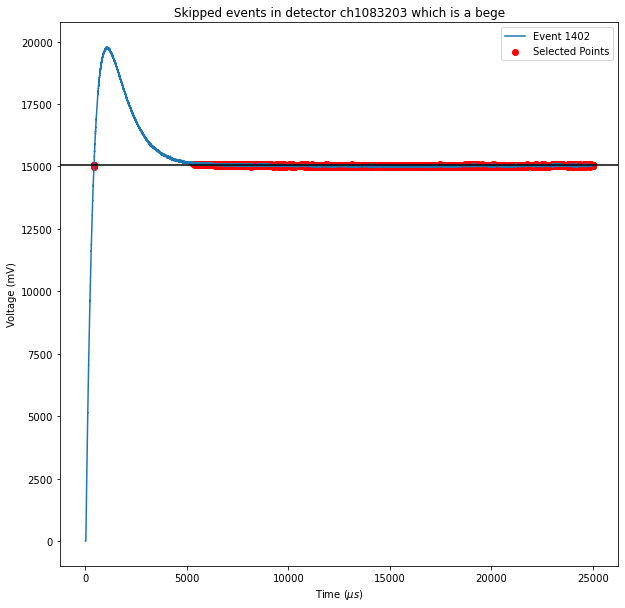

DISCHARGE
Maximum difference: 283.2, 5631.200000000001
Next maximum difference: 6166.400000000001, 6417.6


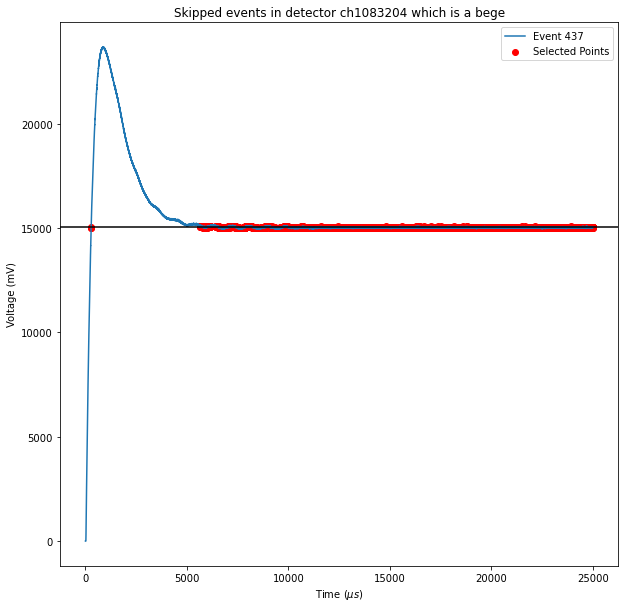

MICRODISCHARGE
Maximum difference: 6004.8, 6007.200000000001
Next Maximum difference: 8583.2, 8585.6


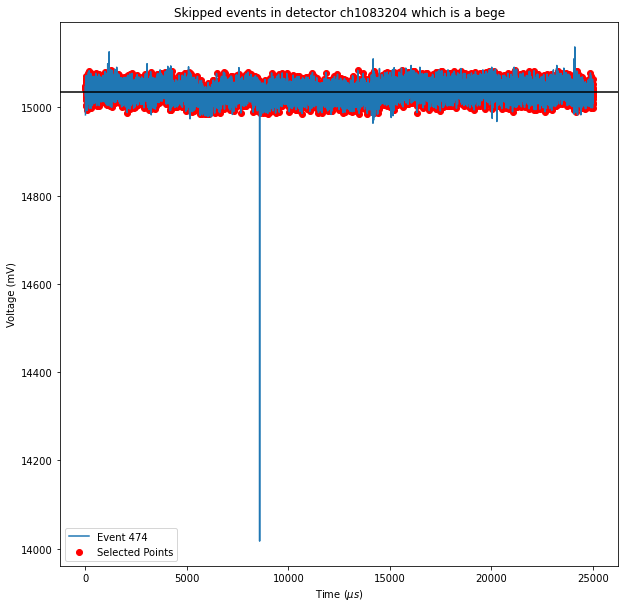

DISCHARGE
Maximum difference: 440.8, 4830.400000000001
Next maximum difference: 4830.400000000001, 4912.0


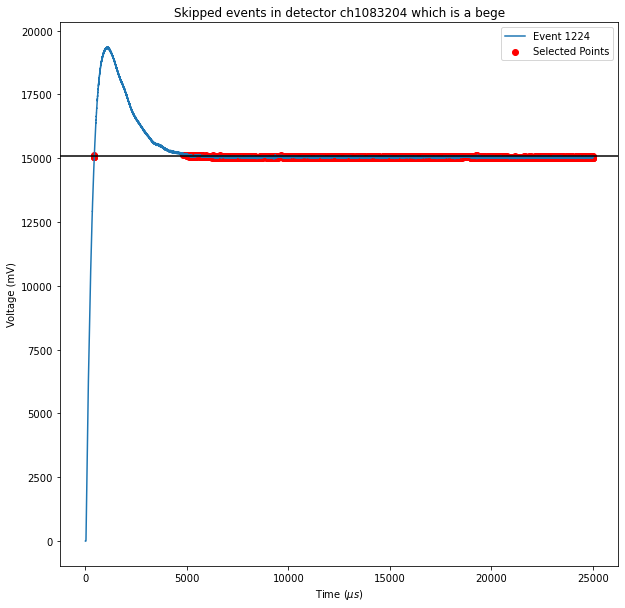

MICRODISCHARGE
Maximum difference: 15985.6, 16170.400000000001
Next Maximum difference: 16199.2, 16261.6


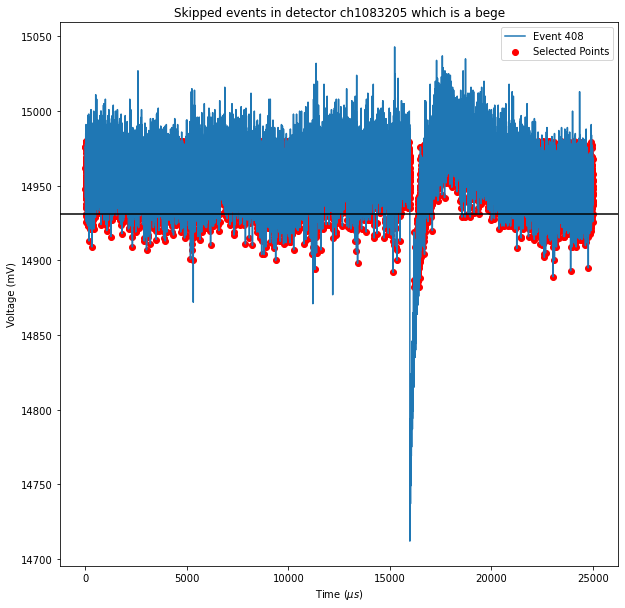

MICRODISCHARGE
Maximum difference: 8598.4, 8608.800000000001
Next Maximum difference: 8628.800000000001, 8639.2


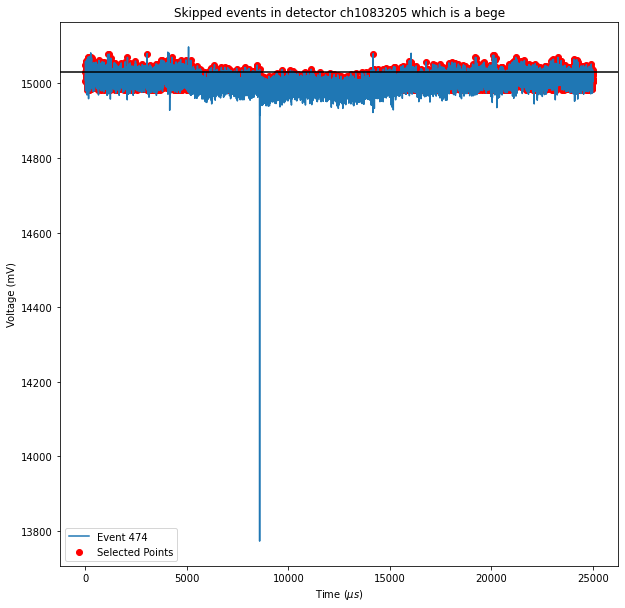

MICRODISCHARGE
Maximum difference: 6379.200000000001, 6382.400000000001
Next Maximum difference: 16423.2, 16425.600000000002


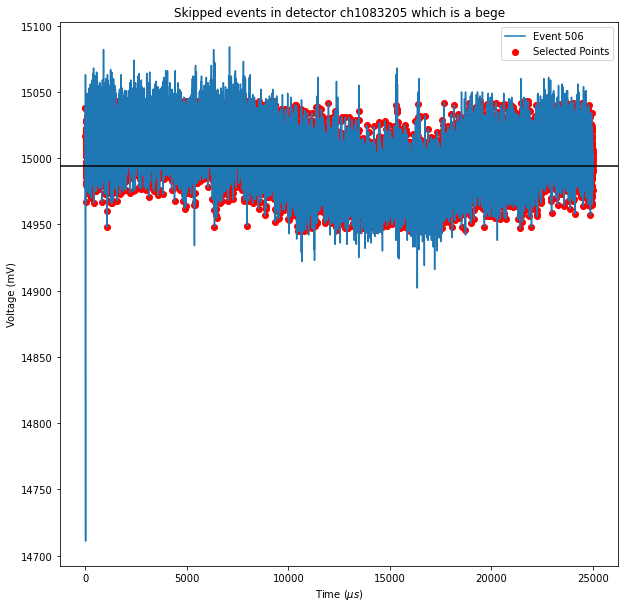

MICRODISCHARGE
Maximum difference: 16120.800000000001, 16469.600000000002
Next Maximum difference: 16469.600000000002, 16485.600000000002


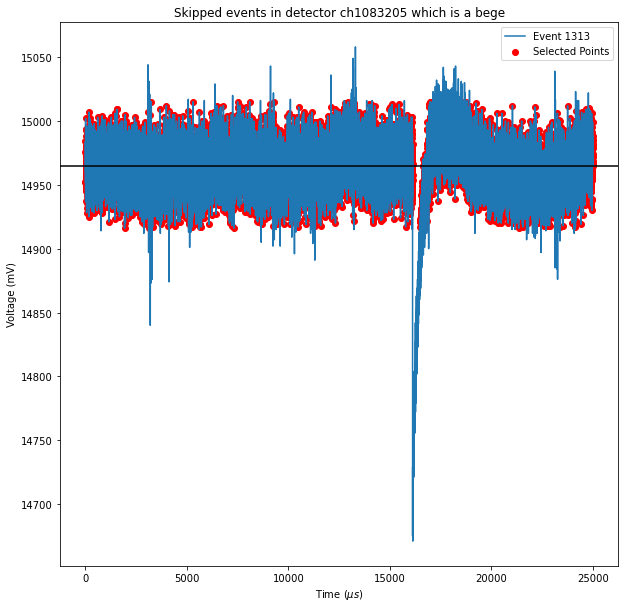

MICRODISCHARGE
Maximum difference: 16869.600000000002, 19329.600000000002
Next Maximum difference: 7910.400000000001, 9952.800000000001


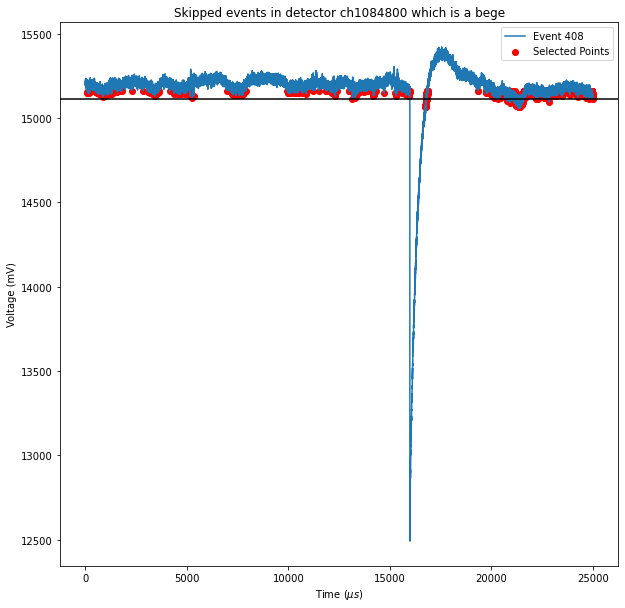

MICRODISCHARGE
Maximum difference: 294.40000000000003, 2526.4
Next Maximum difference: 11716.800000000001, 13830.400000000001


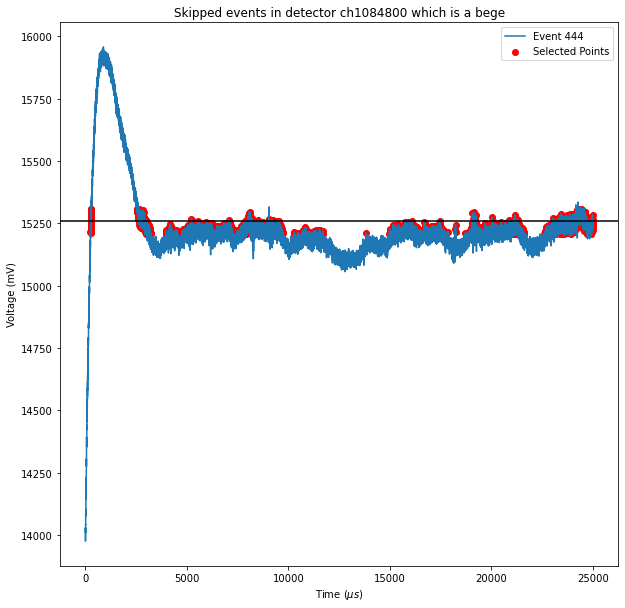

MICRODISCHARGE
Maximum difference: 10134.400000000001, 10517.6
Next Maximum difference: 1353.6000000000001, 1540.8000000000002


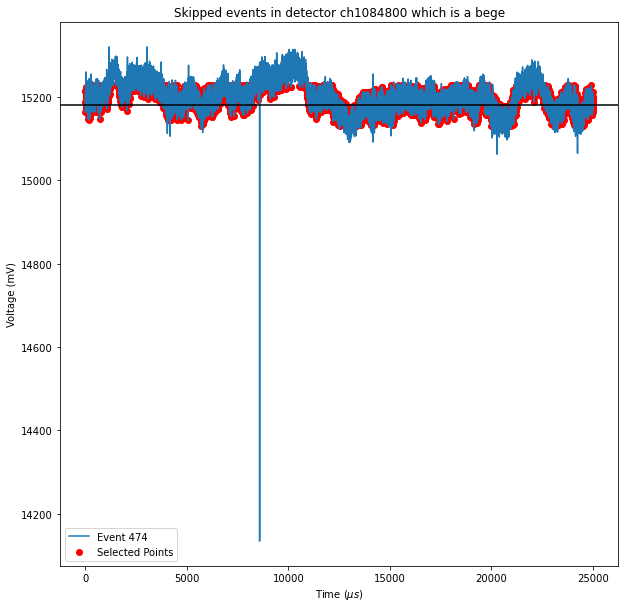

MICRODISCHARGE
Maximum difference: 15802.400000000001, 18864.0
Next Maximum difference: 4298.400000000001, 7272.8


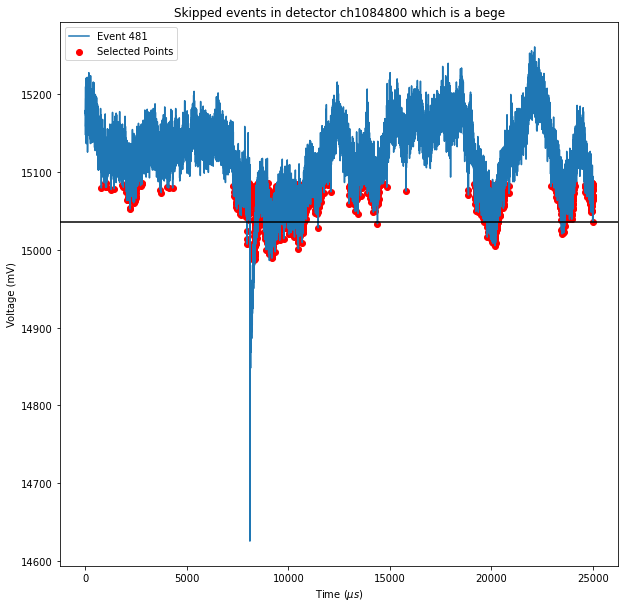

MICRODISCHARGE
Maximum difference: 780.0, 1725.6000000000001
Next Maximum difference: 6400.8, 7000.0


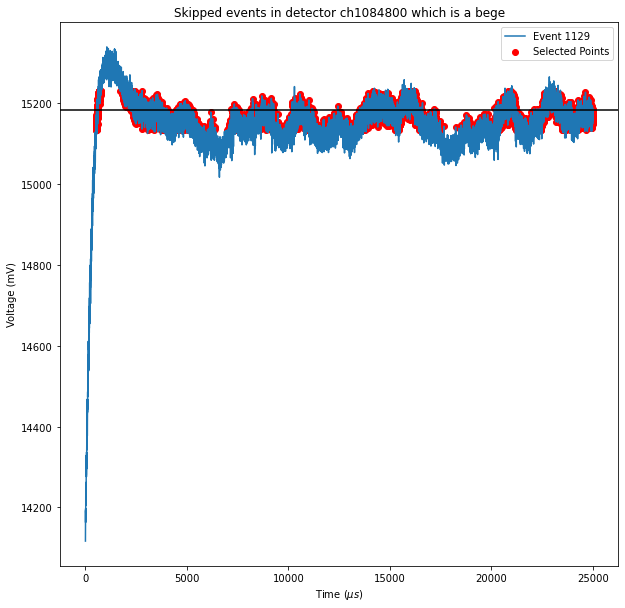

DISCHARGE
Maximum difference: 212.8, 5916.8
Next maximum difference: 6499.200000000001, 6547.200000000001


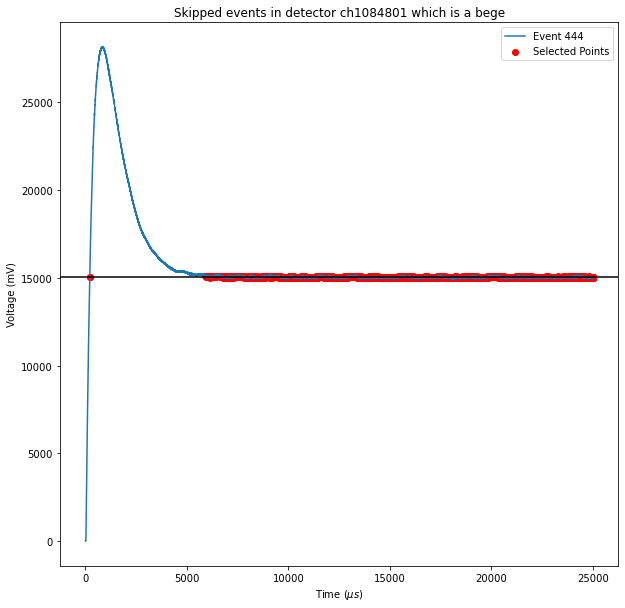

MICRODISCHARGE
Maximum difference: 1165.6000000000001, 1170.4
Next Maximum difference: 1095.2, 1099.2


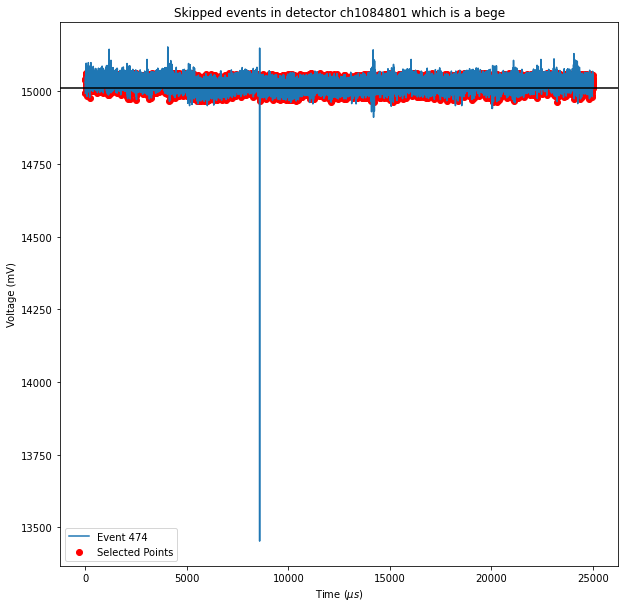

MICRODISCHARGE
Maximum difference: 8893.6, 11600.800000000001
Next Maximum difference: 8102.400000000001, 8766.4


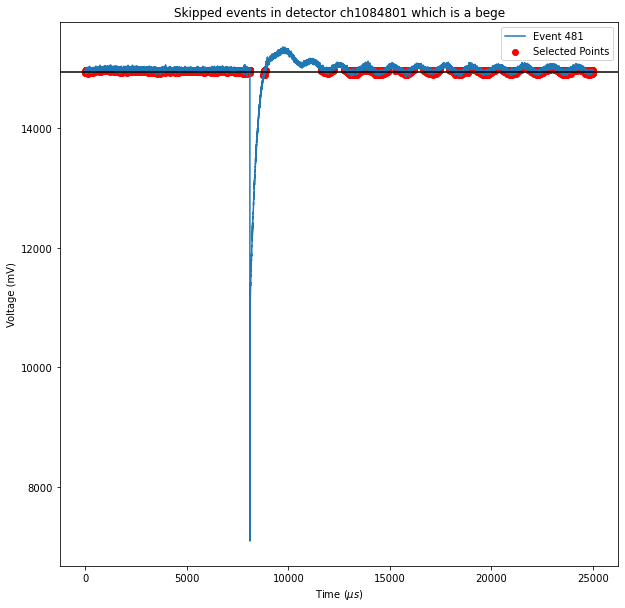

MICRODISCHARGE
Maximum difference: 164.0, 851.2
Next Maximum difference: 5104.8, 5663.200000000001


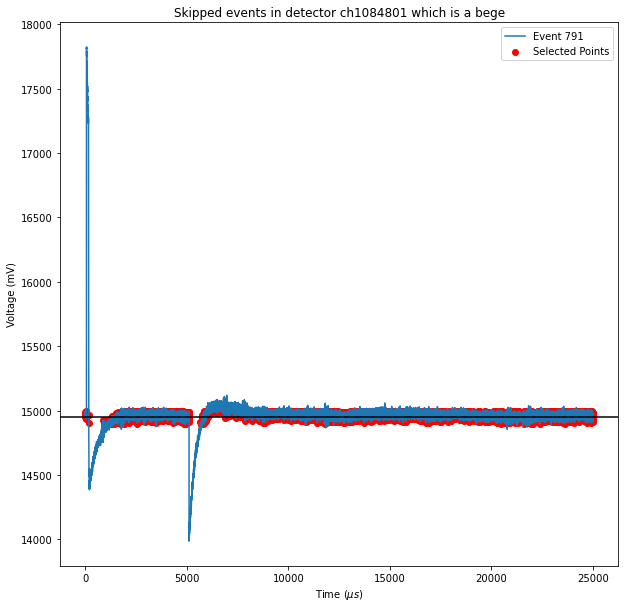

DISCHARGE
Maximum difference: 516.0, 4957.6
Next maximum difference: 4979.200000000001, 4998.400000000001


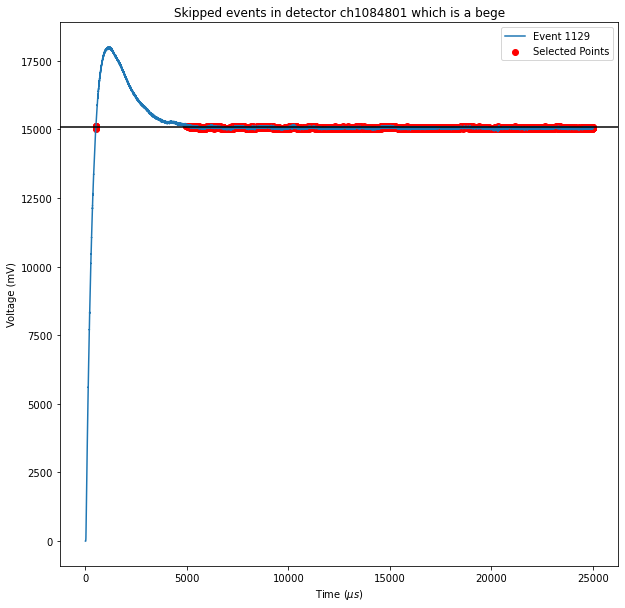

MICRODISCHARGE
Maximum difference: 8606.4, 8609.6
Next Maximum difference: 8583.2, 8586.4


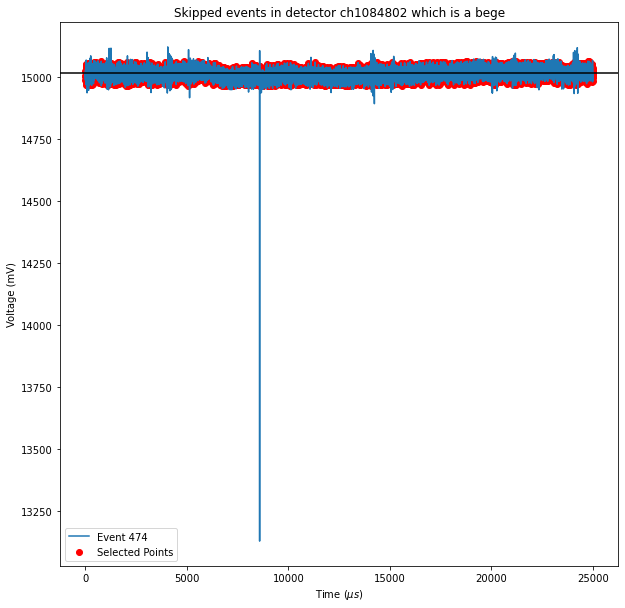

MICRODISCHARGE
Maximum difference: 453.6, 2544.8
Next Maximum difference: 2544.8, 2734.4


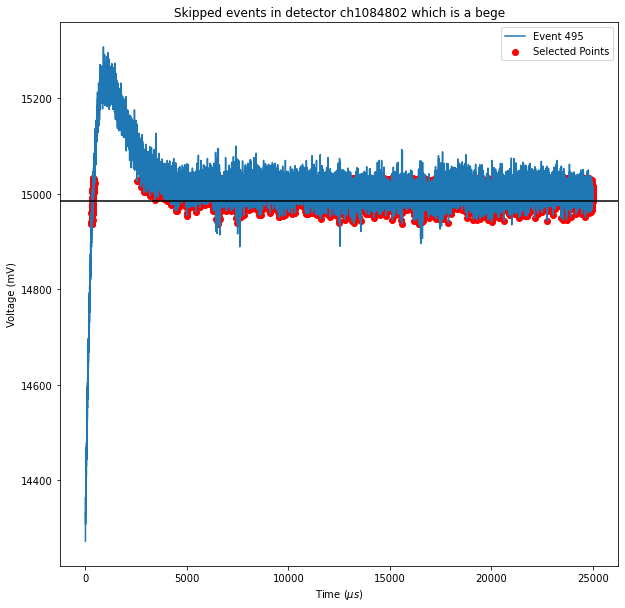

MICRODISCHARGE
Maximum difference: 23593.600000000002, 24643.2
Next Maximum difference: 24672.800000000003, 24707.2


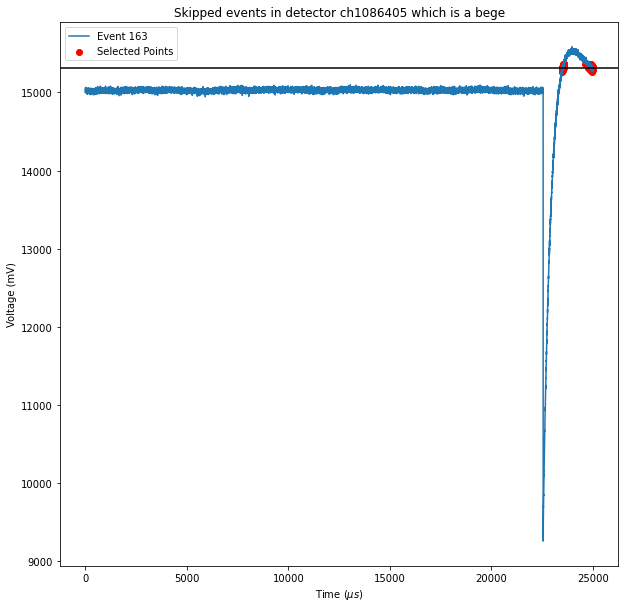

In [16]:
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0)
            #print(f"normal standard deviation{np.std(wf0)}")
            
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
            
            non_zero_weights = [weight for weight in all_weight if weight != 0]
            length1 = len(non_zero_weights)
            
            tops = []
            for k in wf0:
                weight = abs(1/(k-mean_y))
                top = weight*(k-weighted_average)**2
                tops.append(top)
            
            std_weight = np.sqrt(np.sum(tops)/((length1-1)*np.sum(all_weight)/length1))
            
            
                
            #print(f" weighted standard deviation{std_weight}")
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            #print(f"The mean y values is {mean_y}")
            #print(f"The weighted mean y values is {weighted_average}")
            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform
            
            for_append = []
            for_x = []
            # x values within the baseline range 
            # y values within the baseline range 
            for t, q in zip(ts, wf0):
                if weighted_average-50 < q < weighted_average+50:
                    for_x.append(t)
                    for_append.append(q)       
            
            # Plot the x values
            
            plt.scatter(for_x, for_append, color='r', label='Selected Points')
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:
                # Determine the index for the maximum difference
                max_diff_index = np.argmax(x_diff)

                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))

                next_max_index = np.argmax(masked_data)

                # Use the index to get the corresponding x values
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]

                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
                if np.any(wf0[:]==0):
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                else:
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
            else:
                print("NO DISCHARGE")
            
            
            # Customize plot
            plt.axhline(y=weighted_average,color='k')
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

discharge


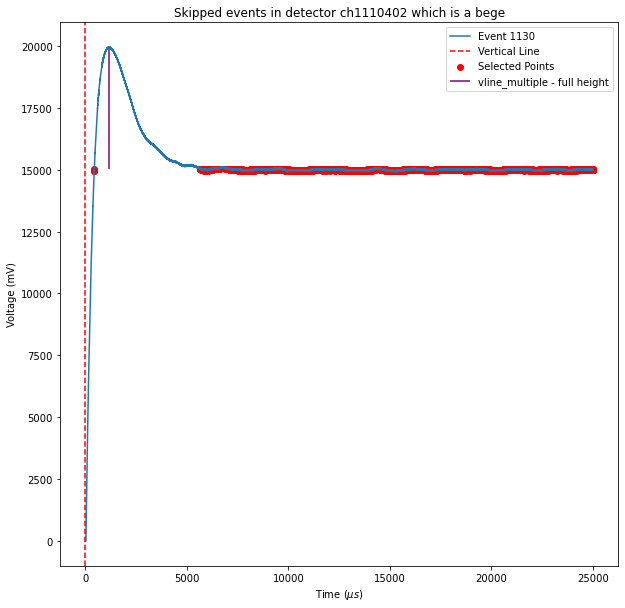

discharge


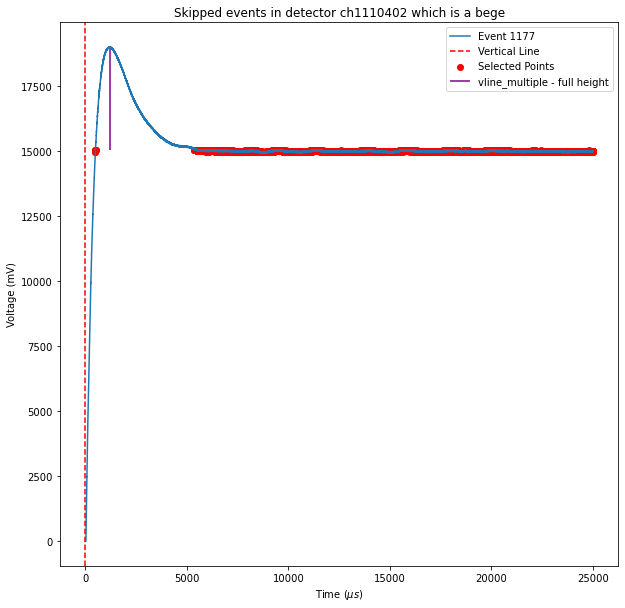

microdischarge


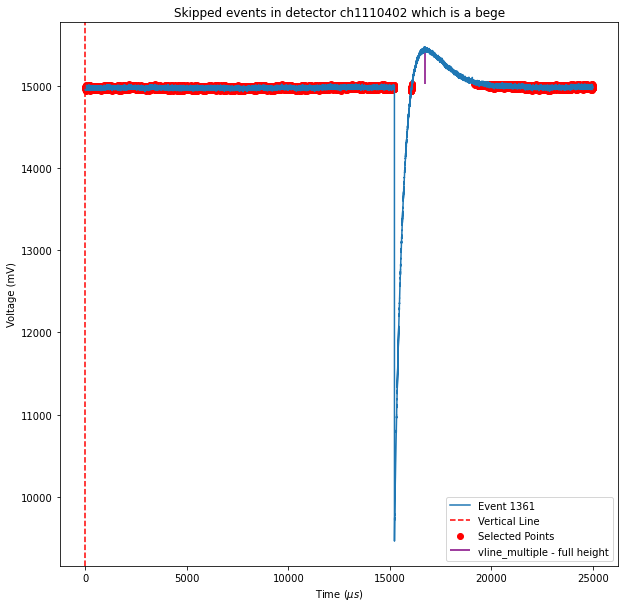

microdischarge


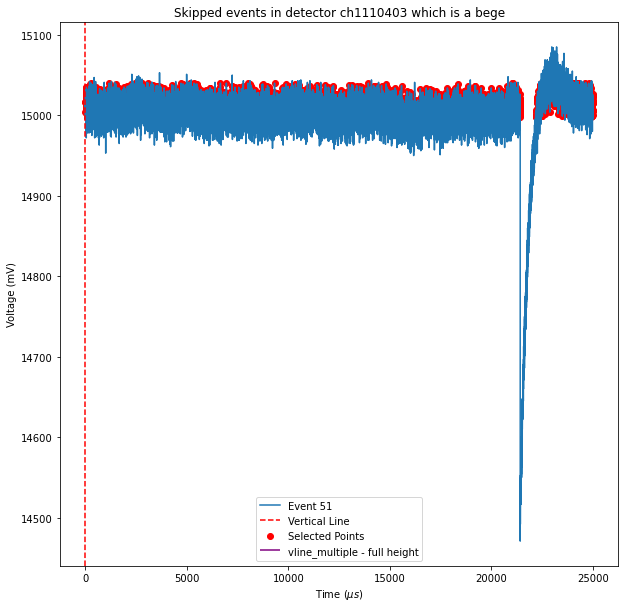

microdischarge


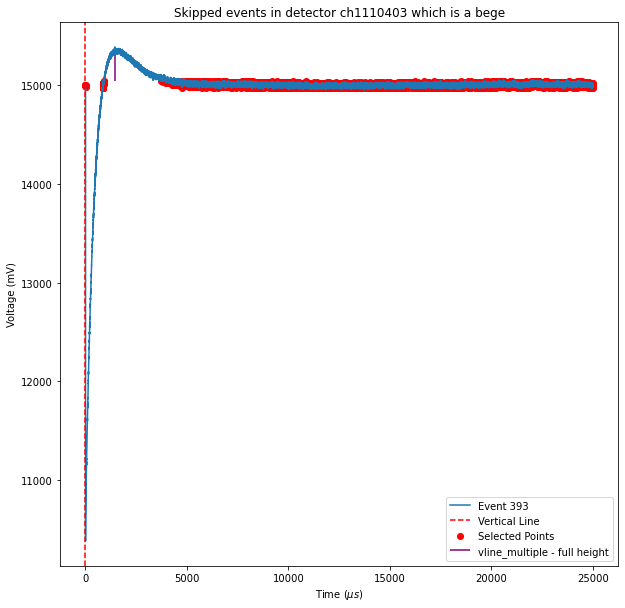

microdischarge


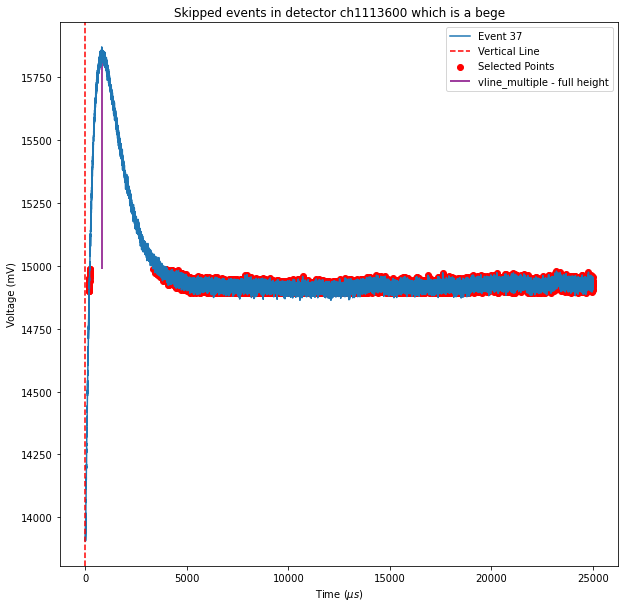

microdischarge


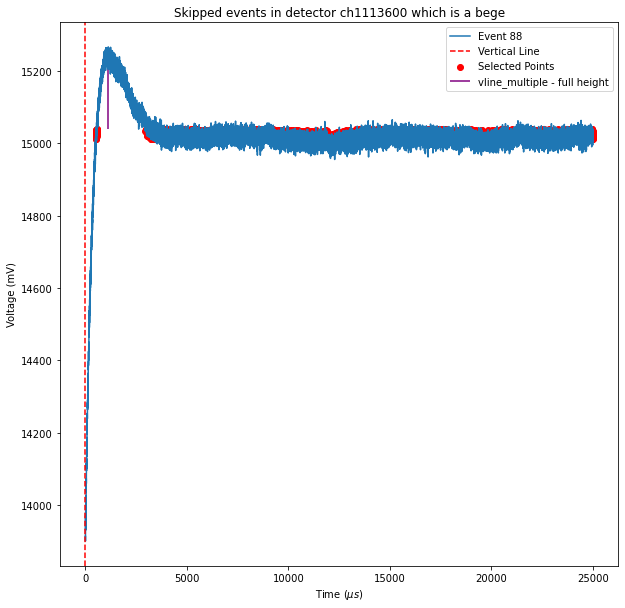

microdischarge


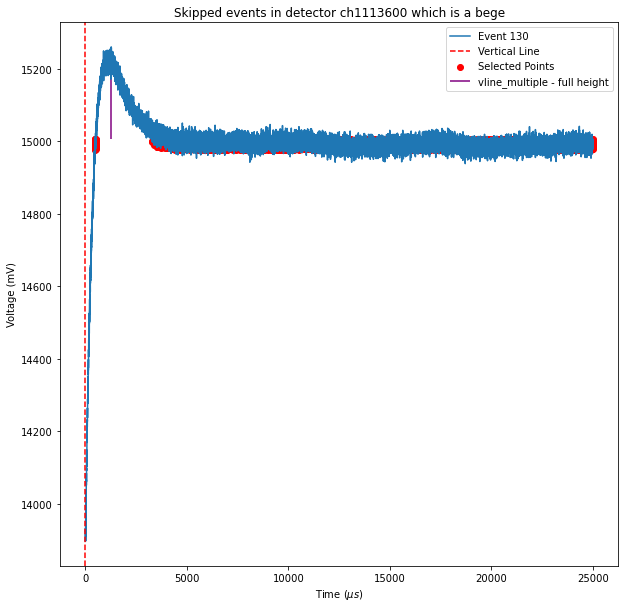

microdischarge


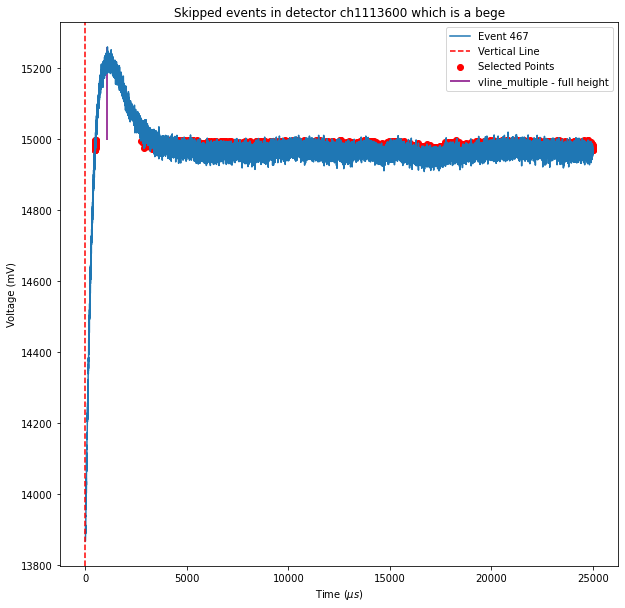

microdischarge


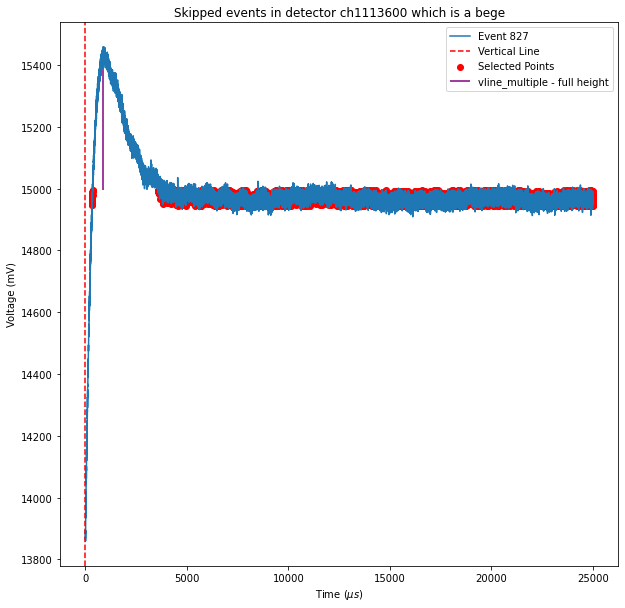

microdischarge


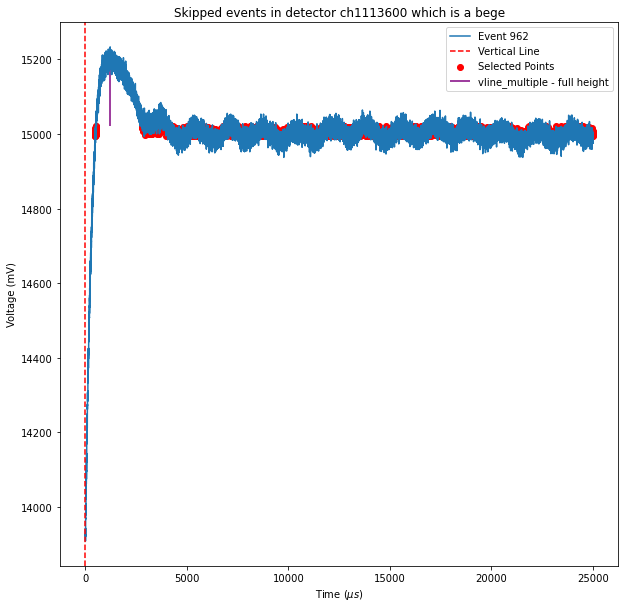

microdischarge


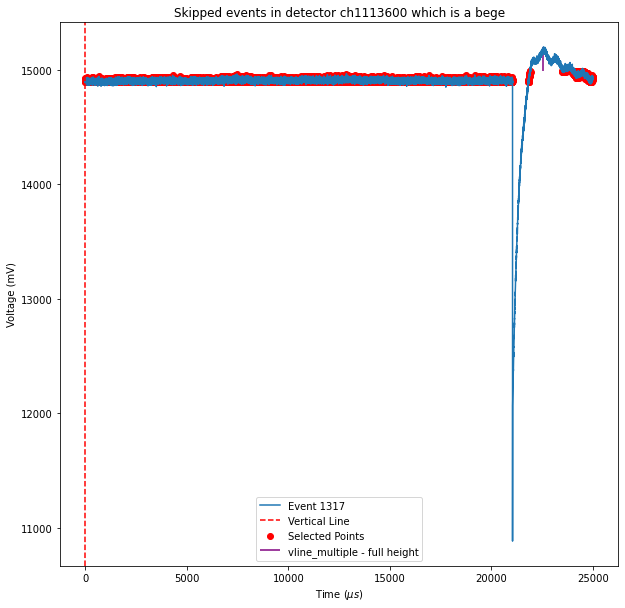

discharge


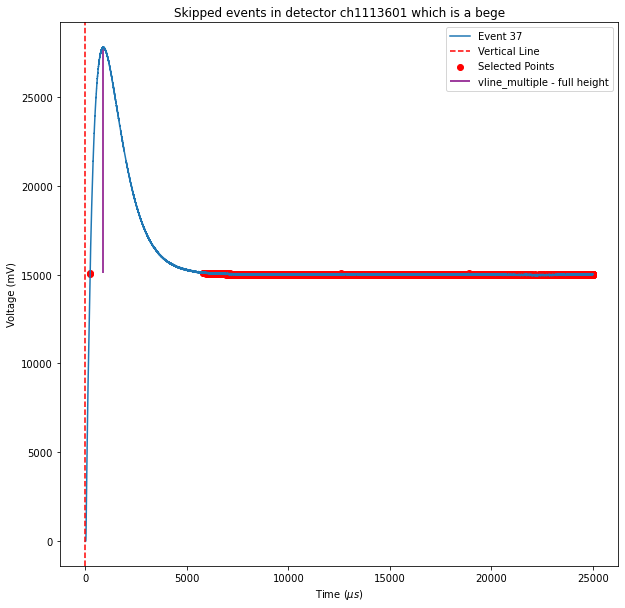

discharge


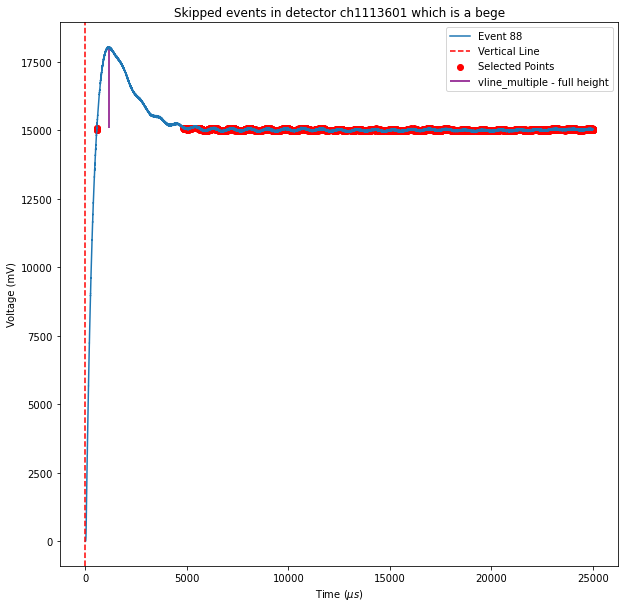

discharge


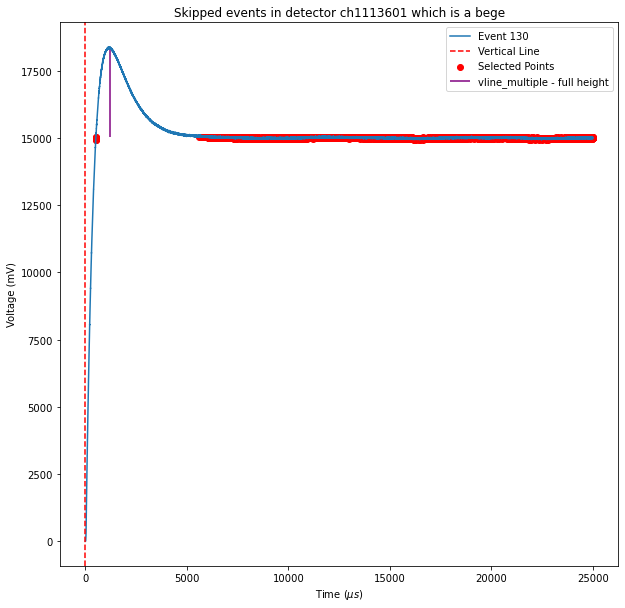

discharge


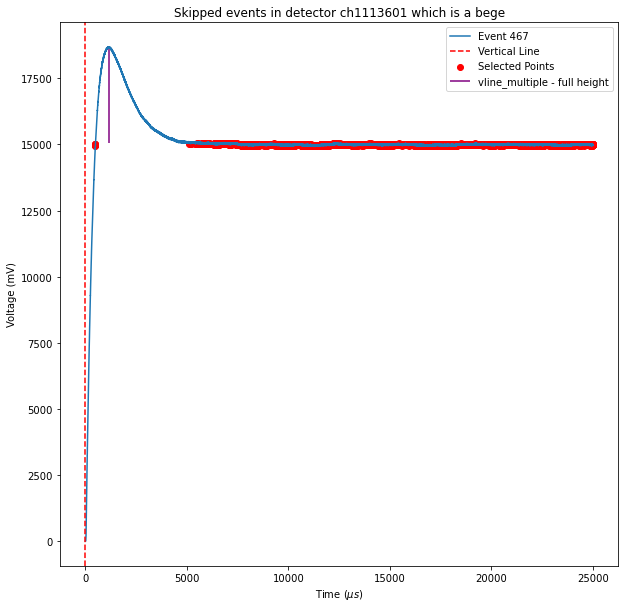

microdischarge


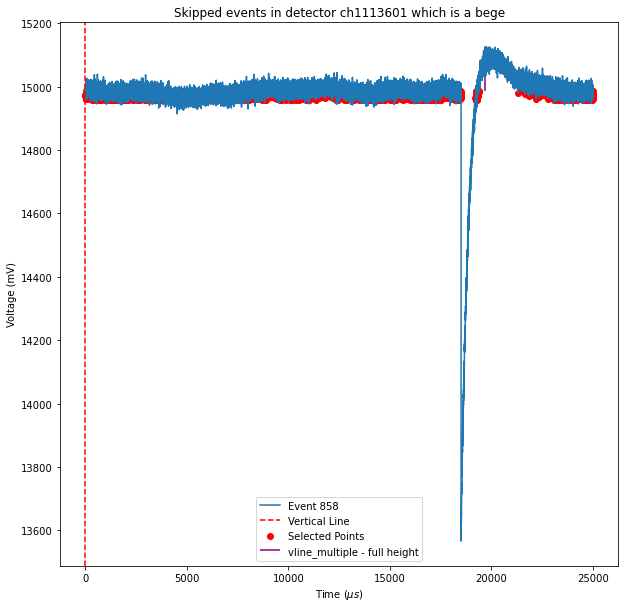

discharge


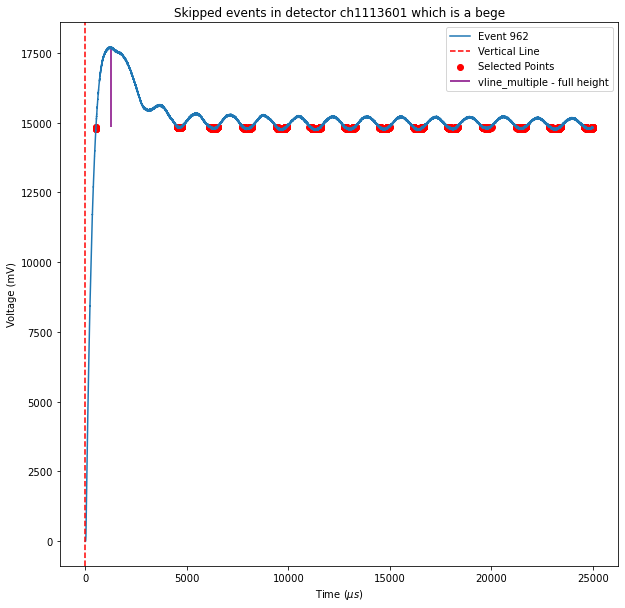

microdischarge


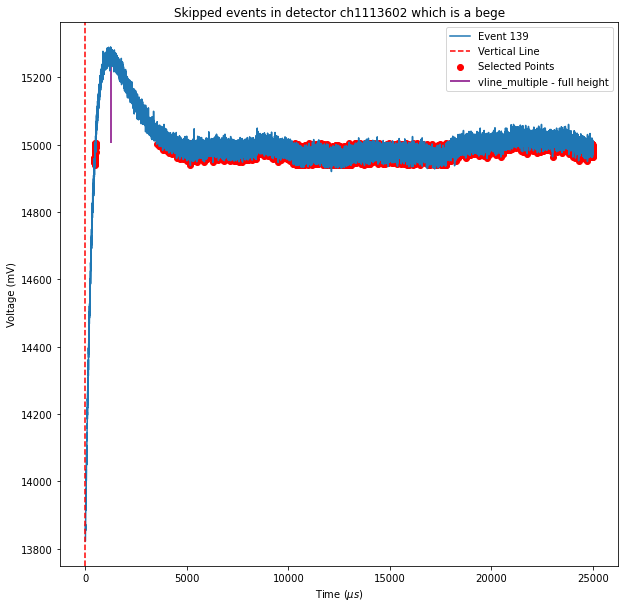

discharge


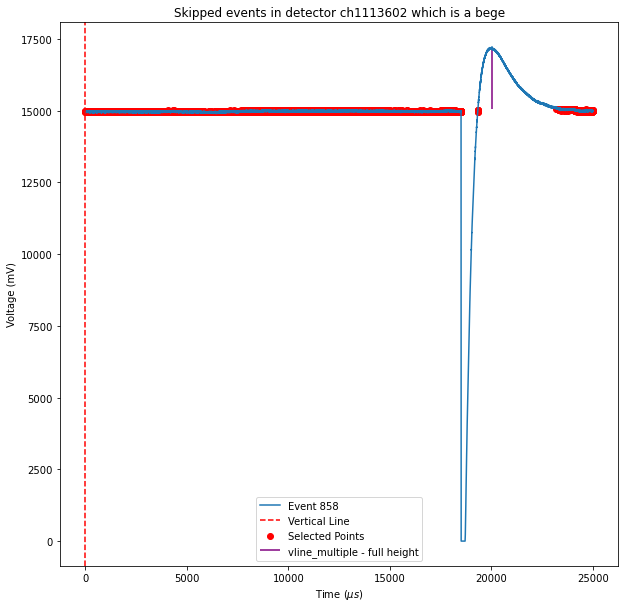

microdischarge


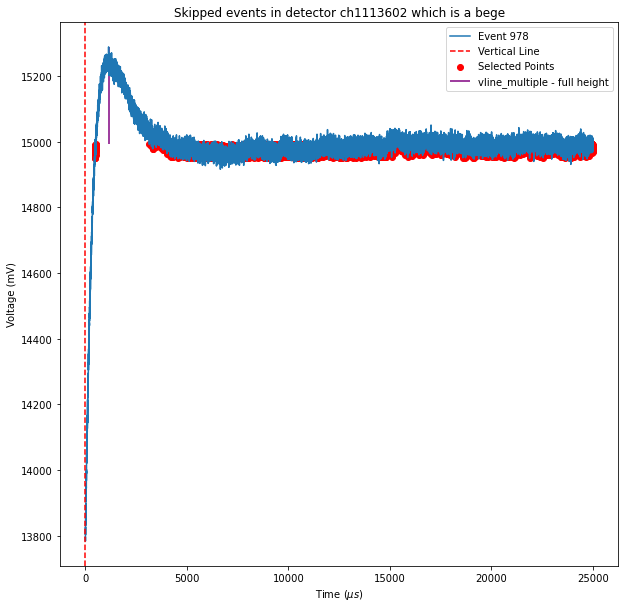

microdischarge


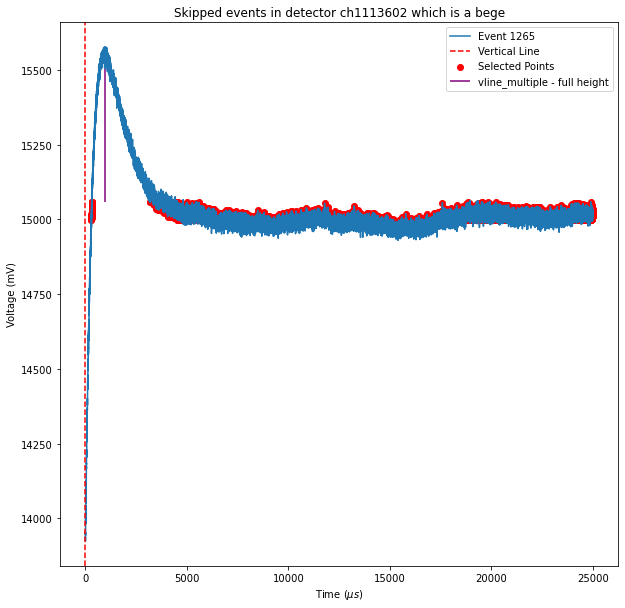

discharge


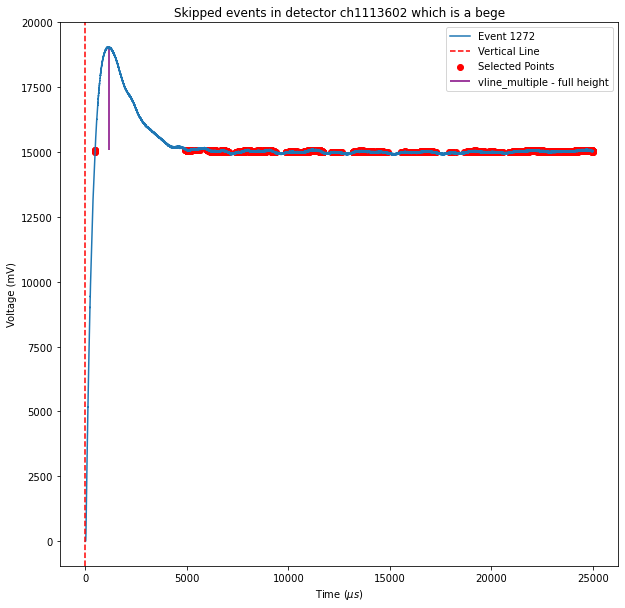

microdischarge


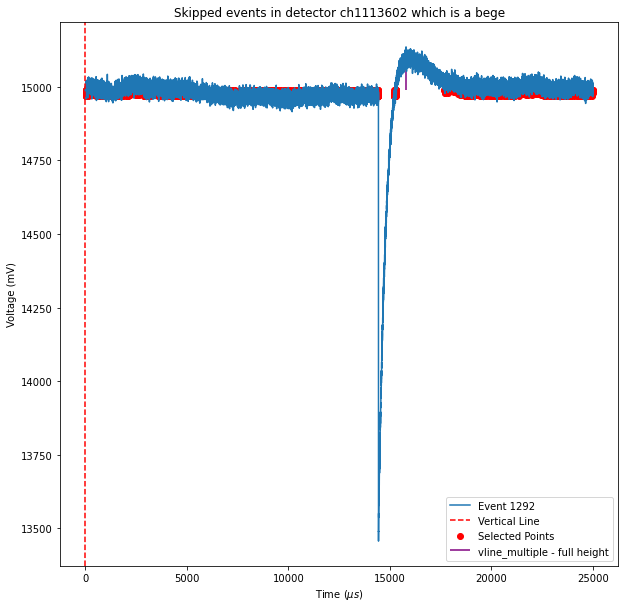

discharge


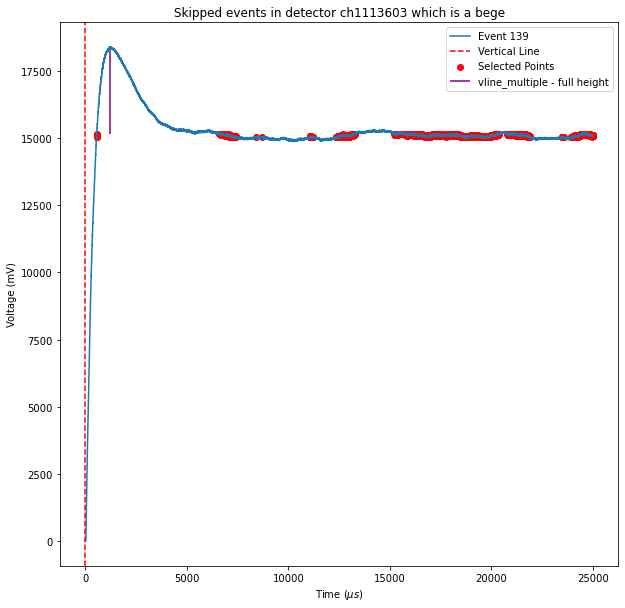

discharge


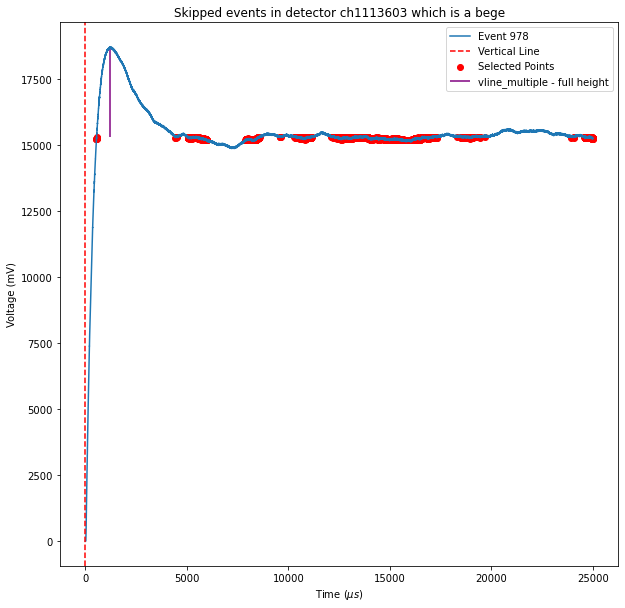

microdischarge


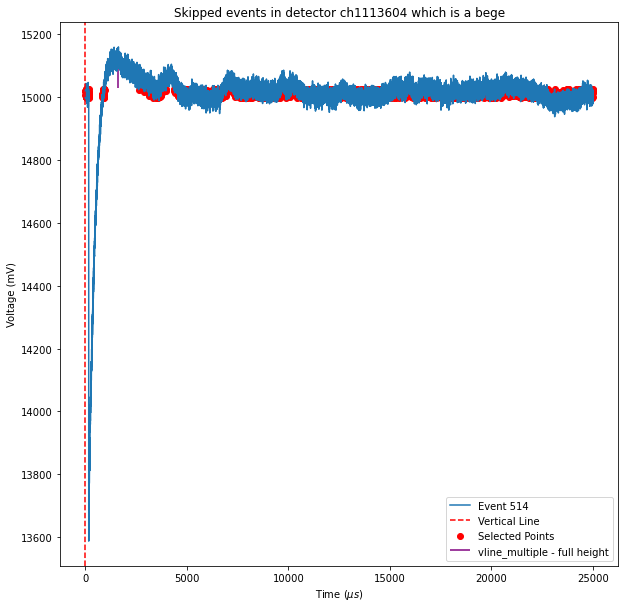

discharge


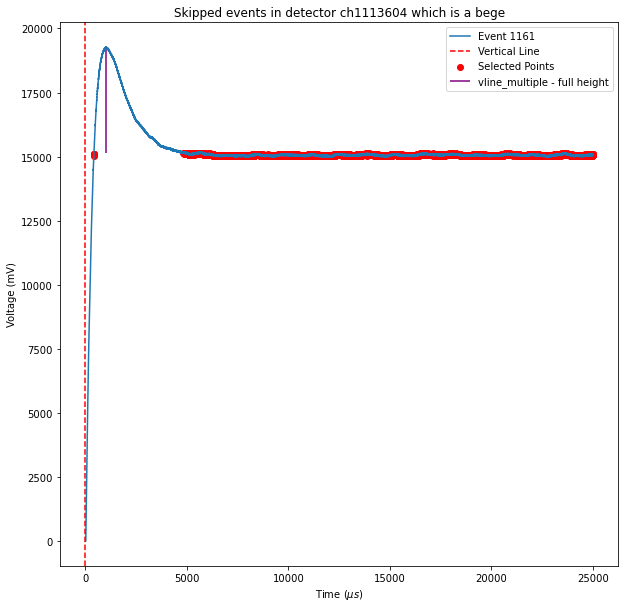

discharge


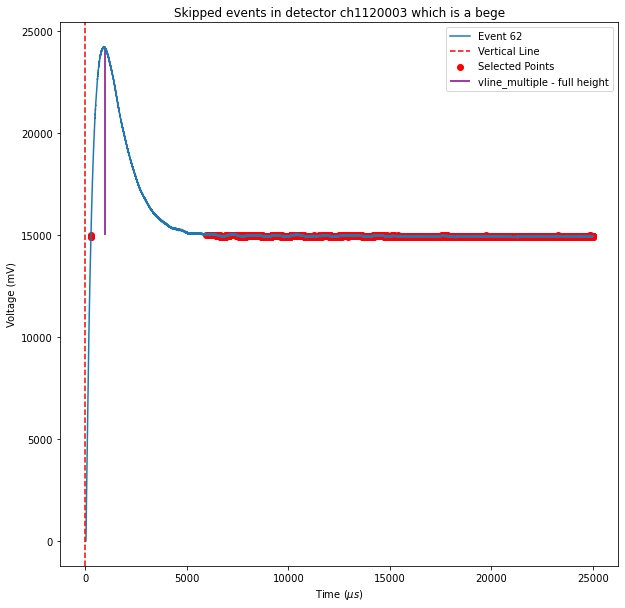

discharge


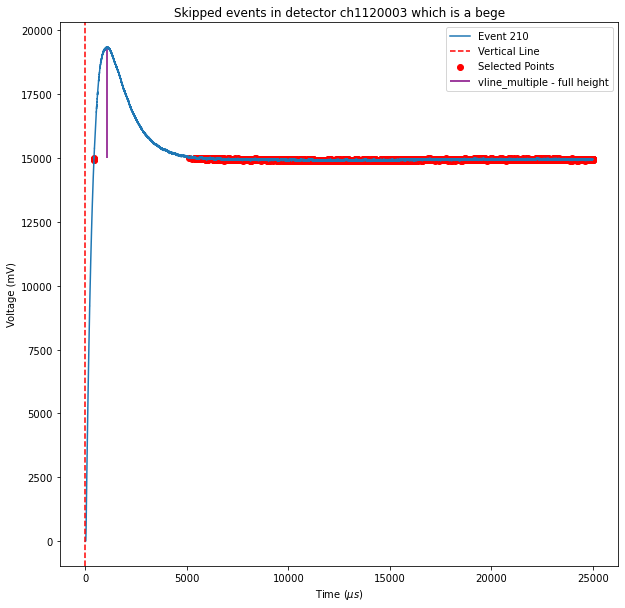

discharge


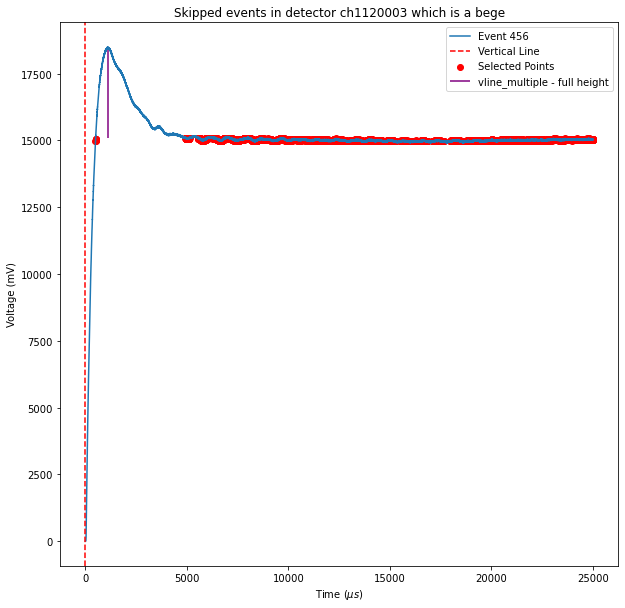

microdischarge


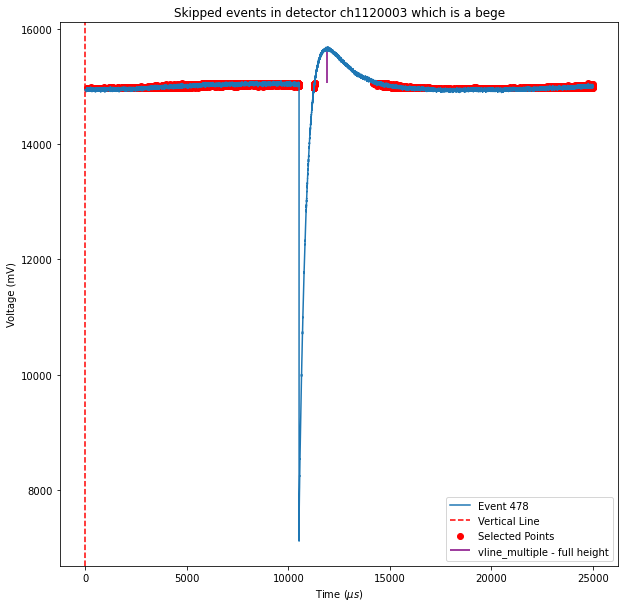

discharge


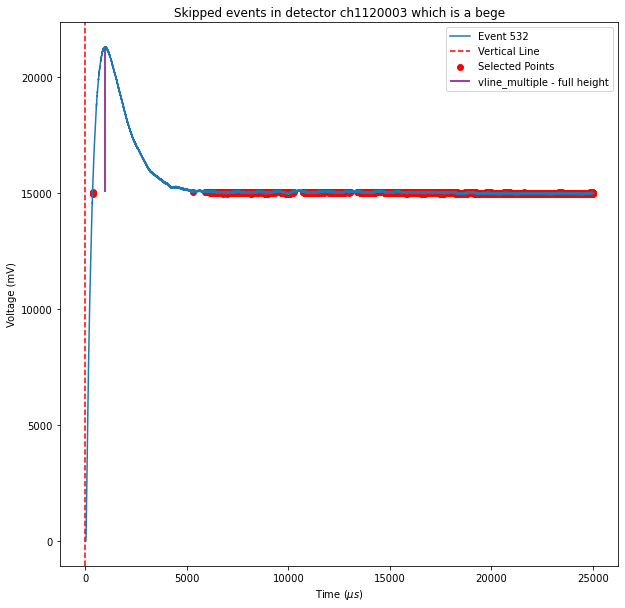

discharge


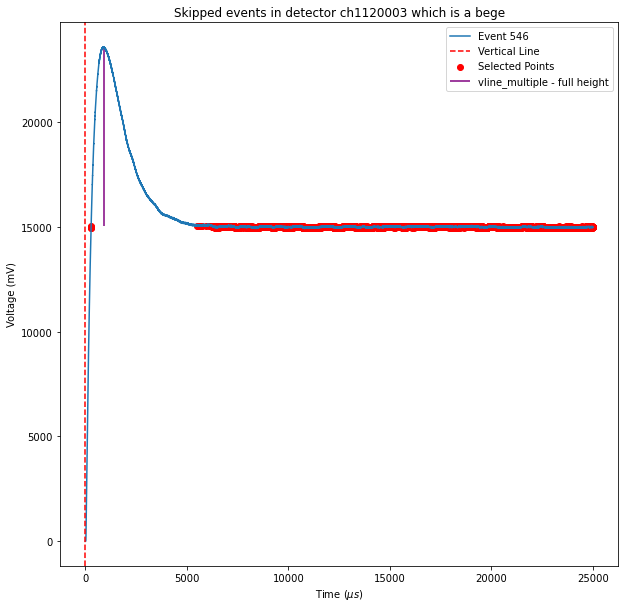

discharge


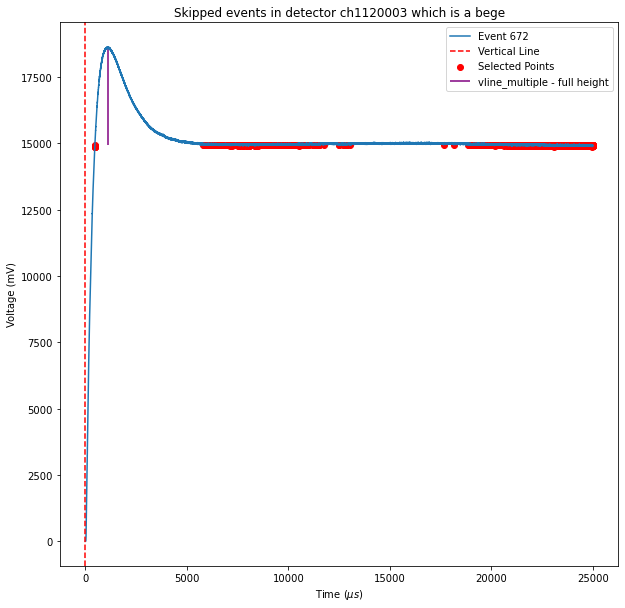

discharge


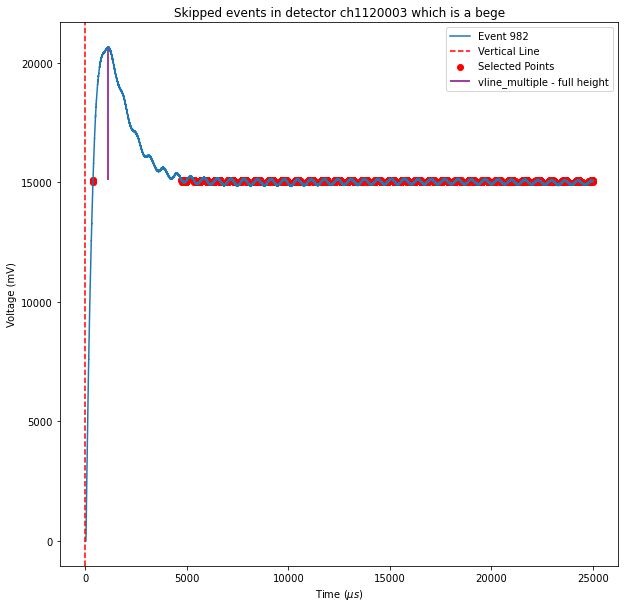

discharge


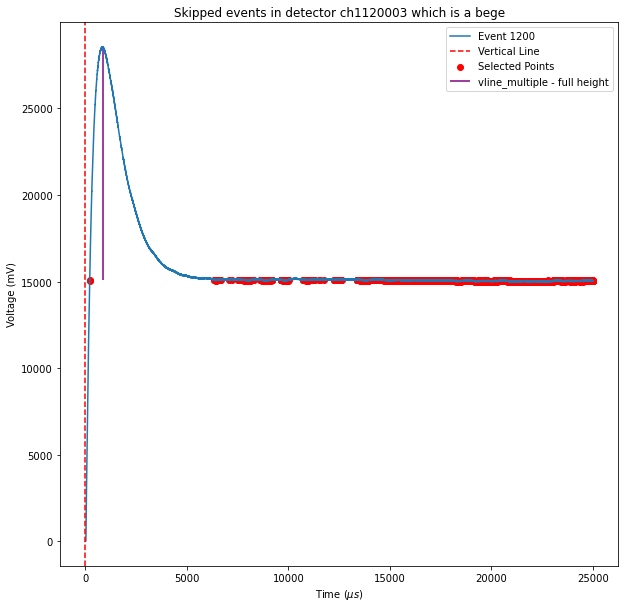

discharge


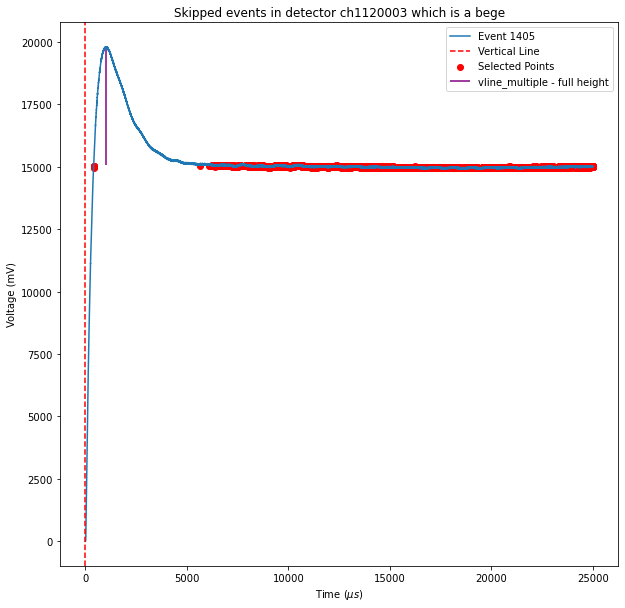

microdischarge


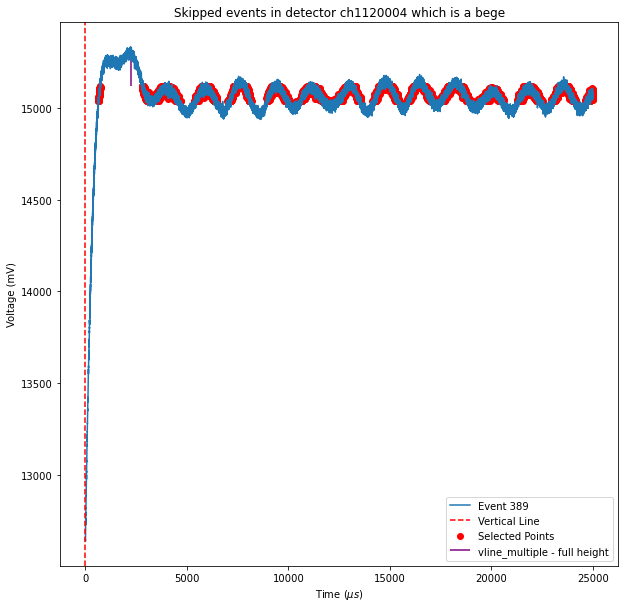

microdischarge


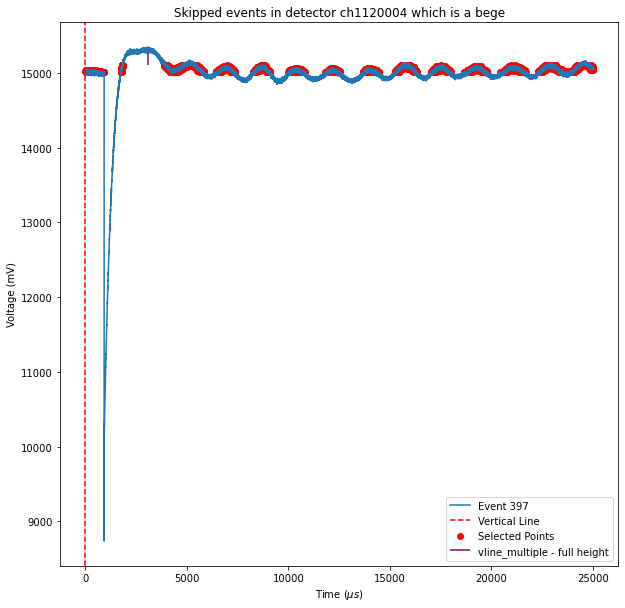

microdischarge


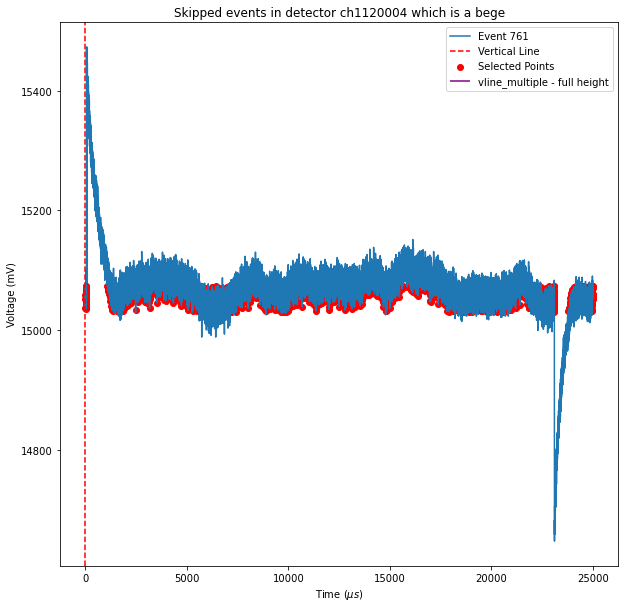

microdischarge


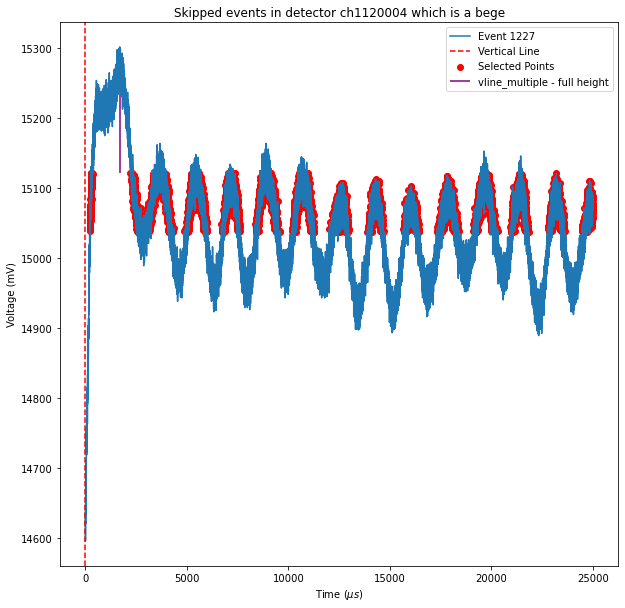

microdischarge


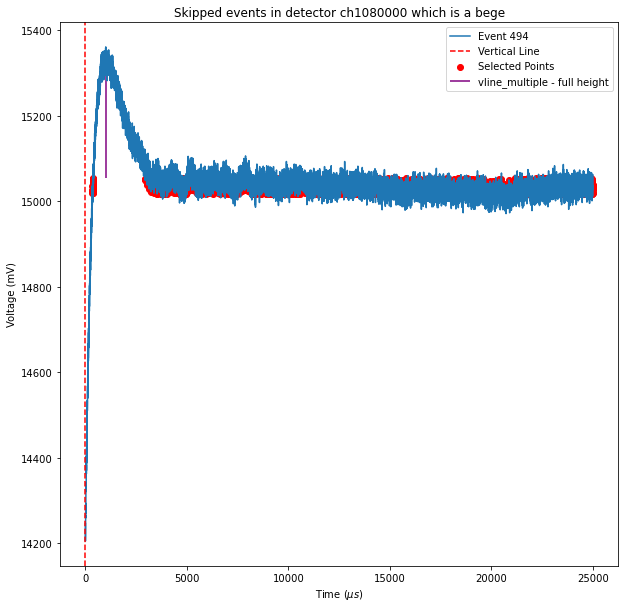

microdischarge


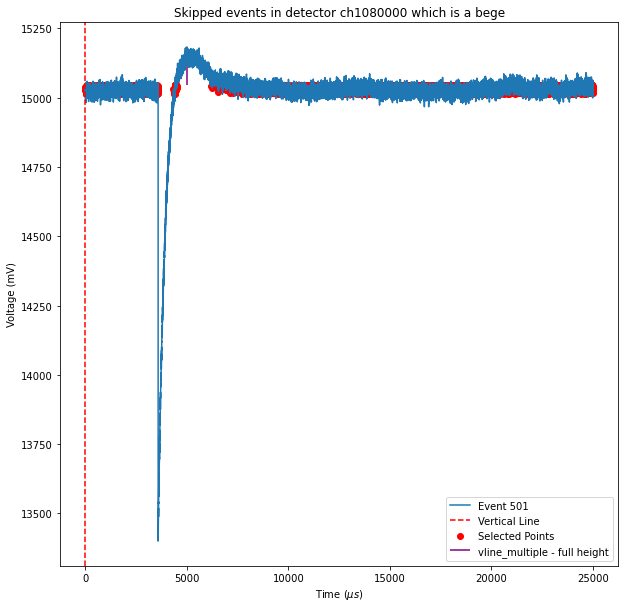

microdischarge


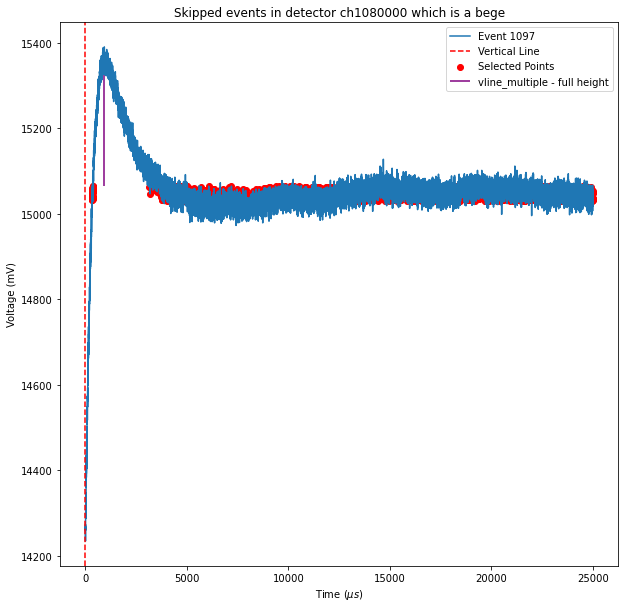

microdischarge


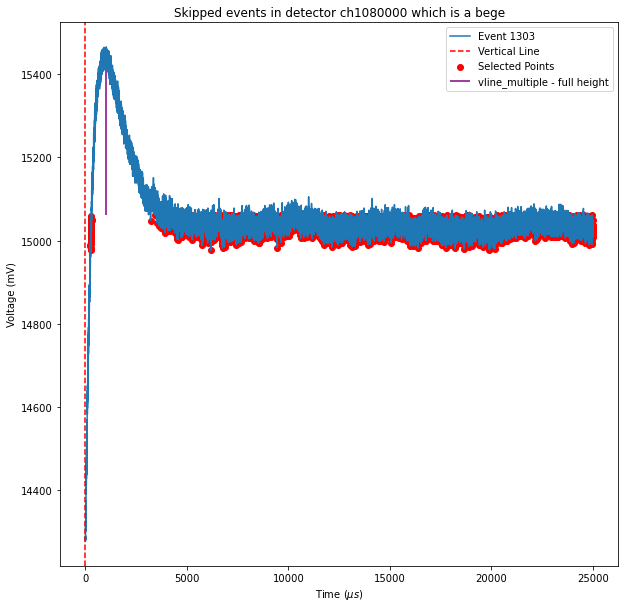

discharge


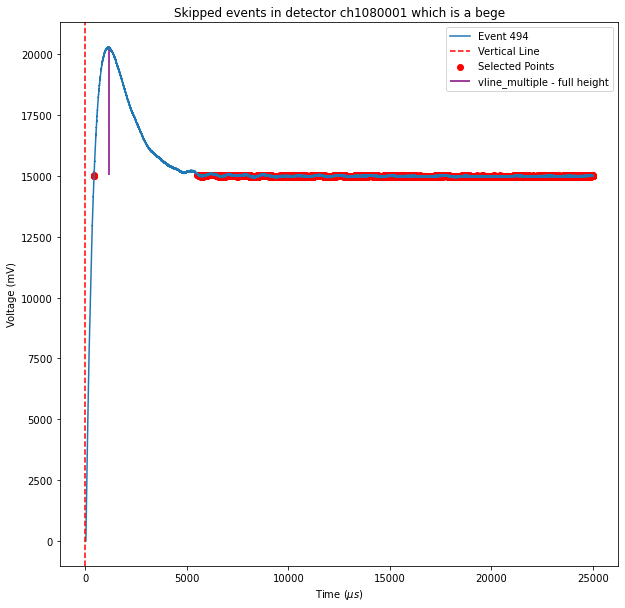

discharge


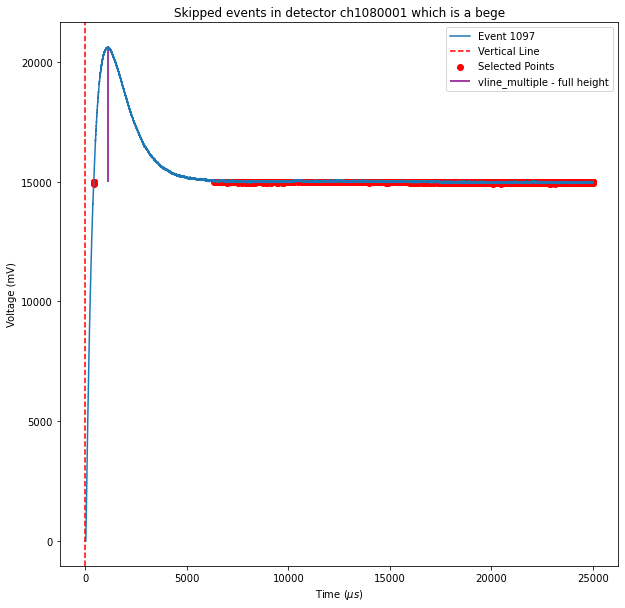

discharge


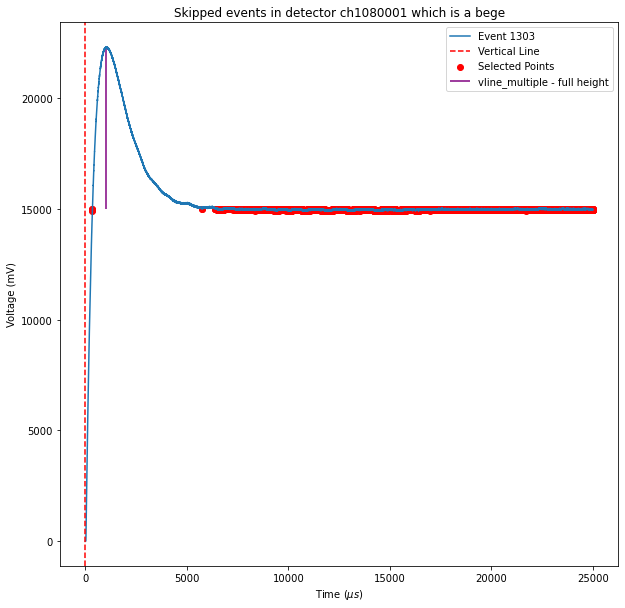

MESSY DISCHARGE


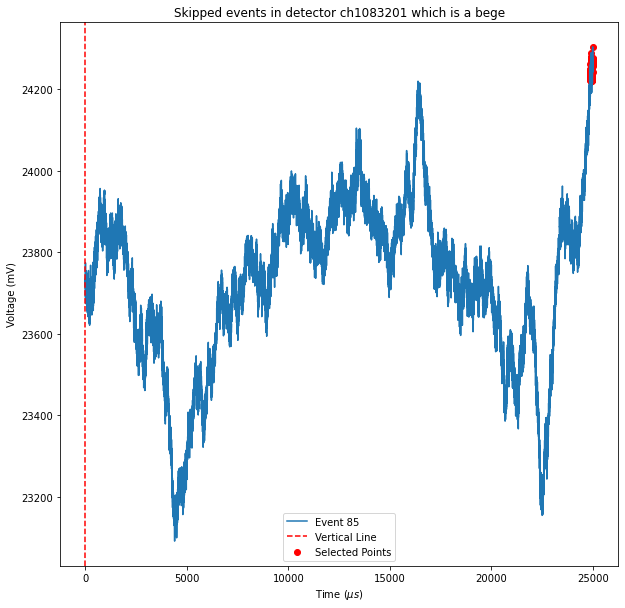

MESSY DISCHARGE


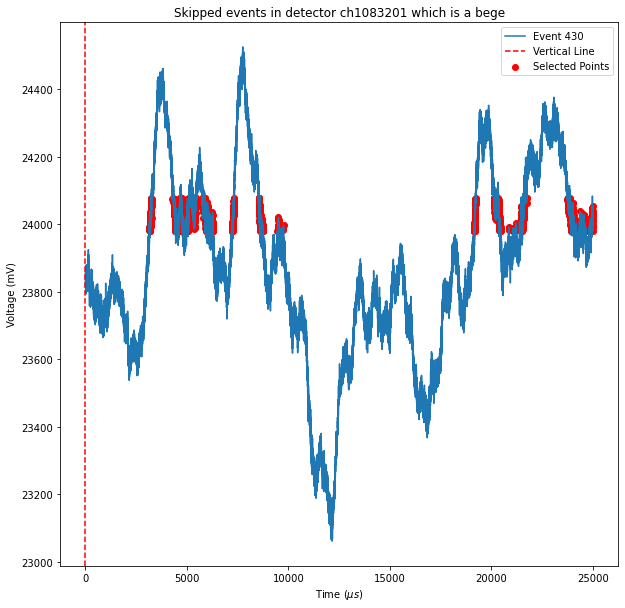

MESSY DISCHARGE


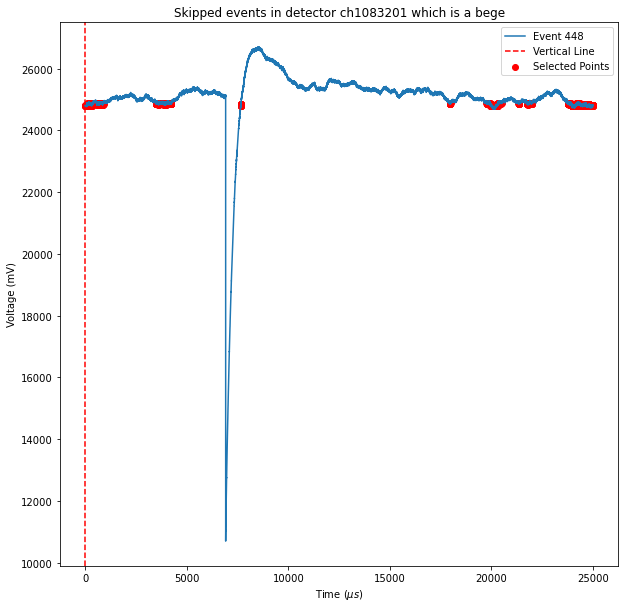

MESSY DISCHARGE


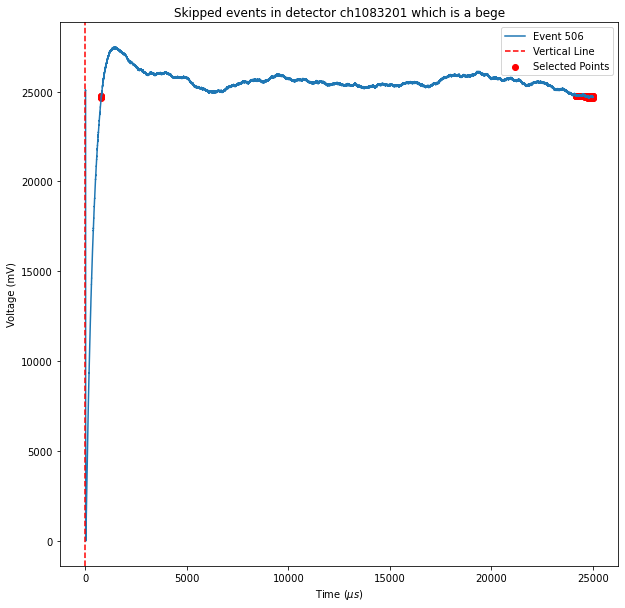

MESSY DISCHARGE


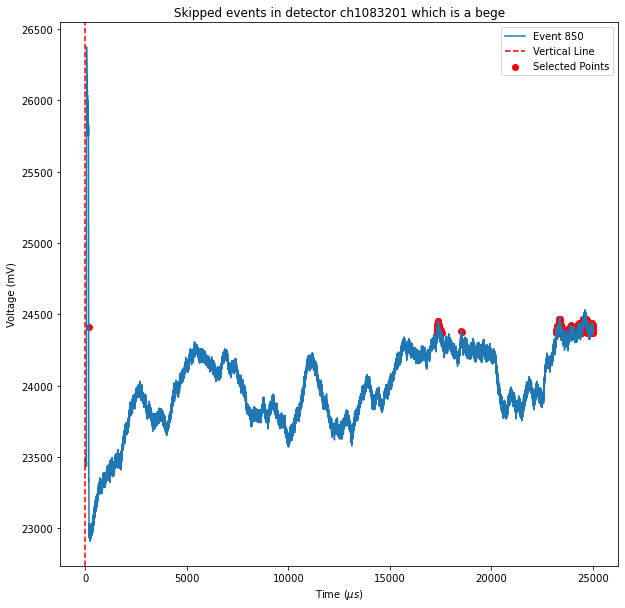

MESSY DISCHARGE


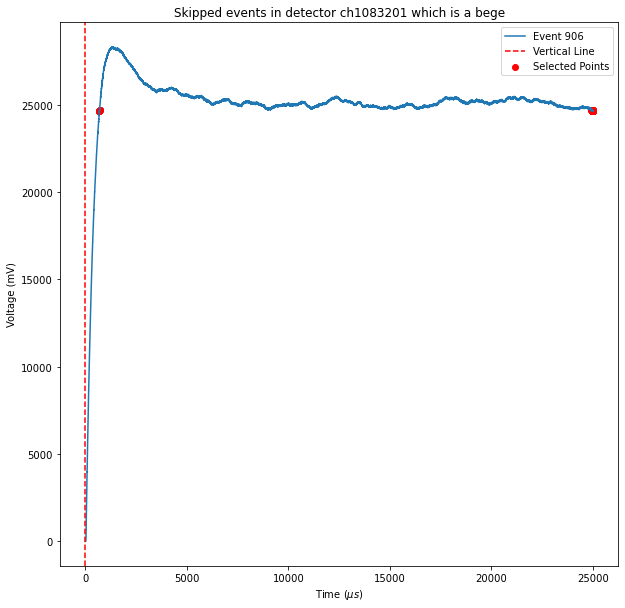

MESSY DISCHARGE


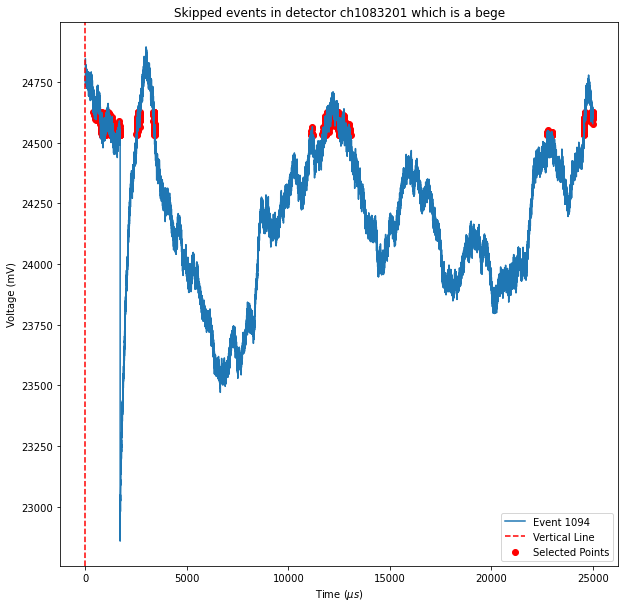

microdischarge


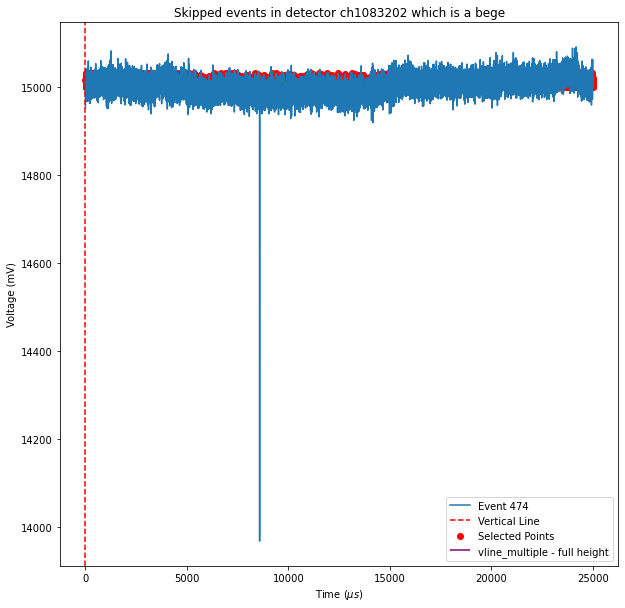

microdischarge


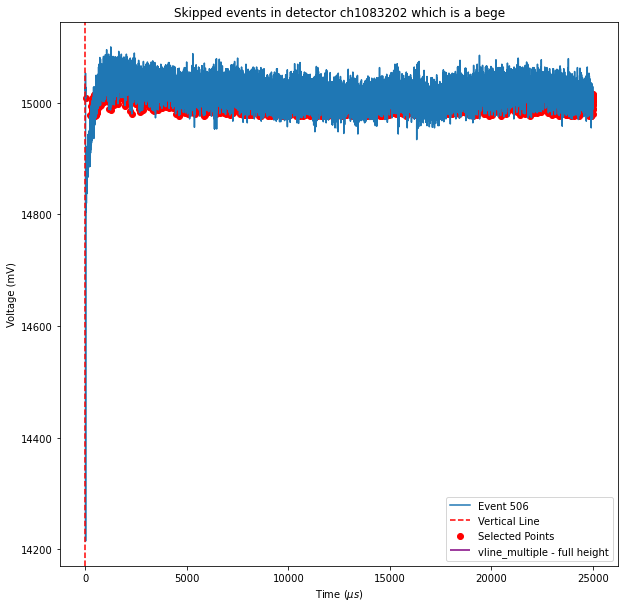

microdischarge


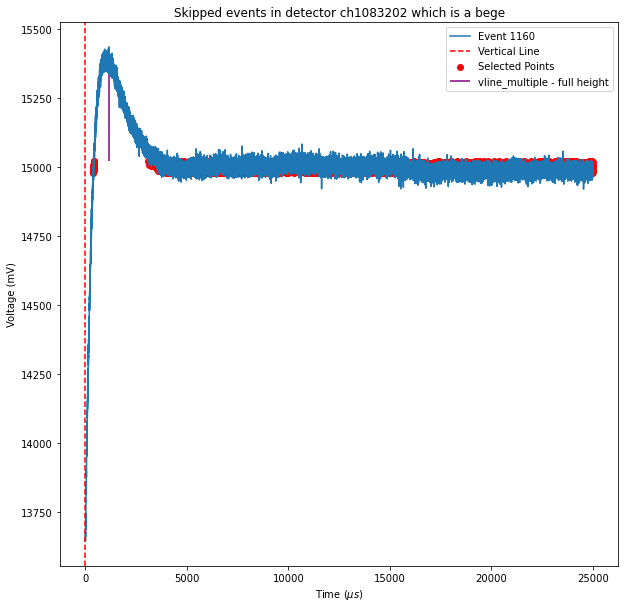

microdischarge


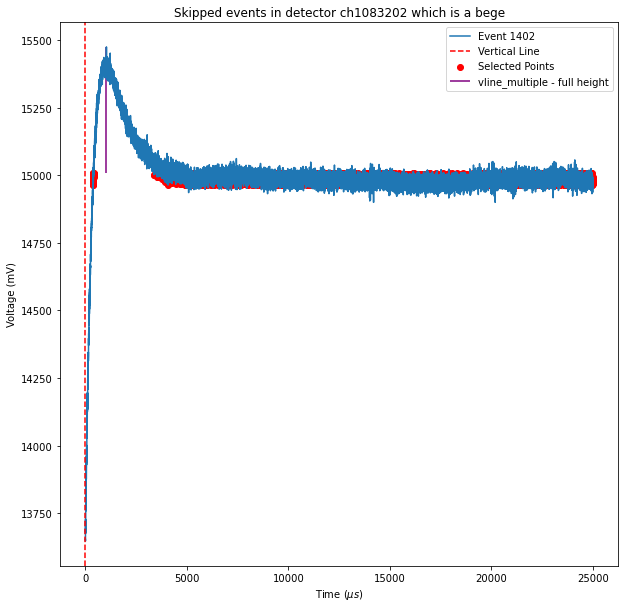

microdischarge


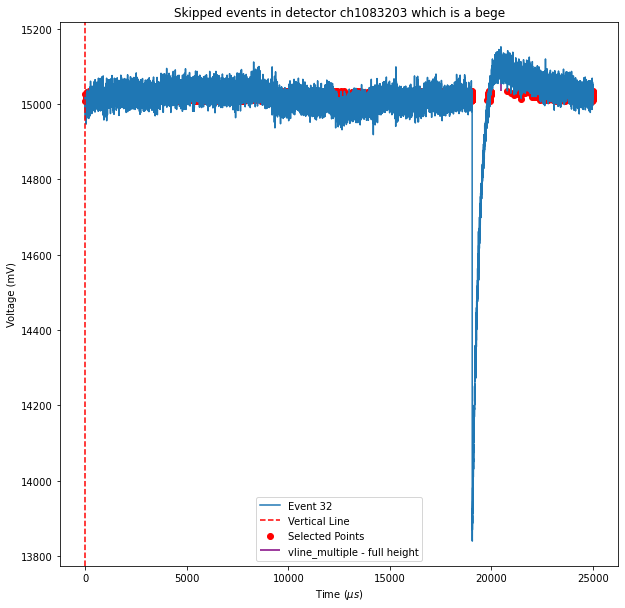

microdischarge


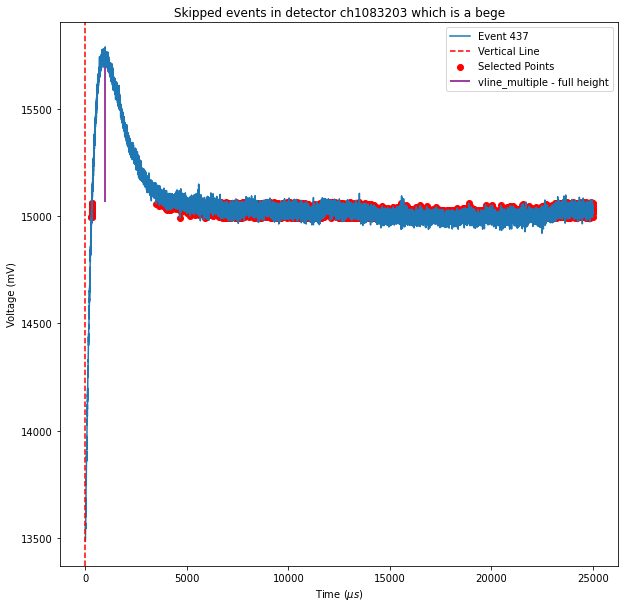

MESSY DISCHARGE


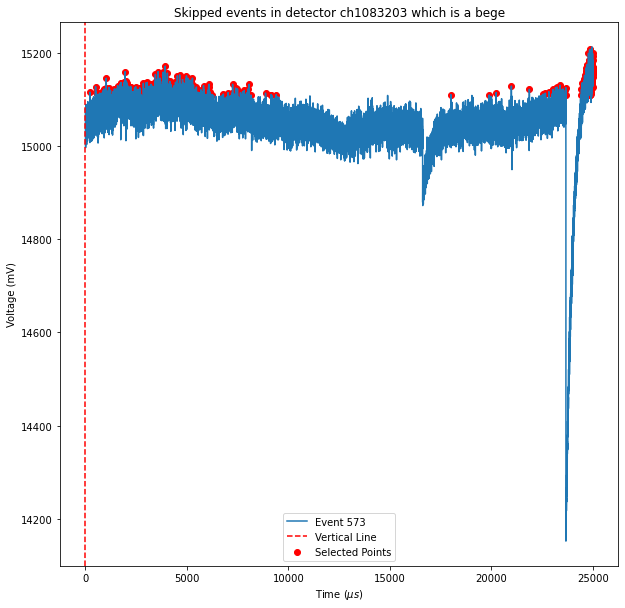

discharge


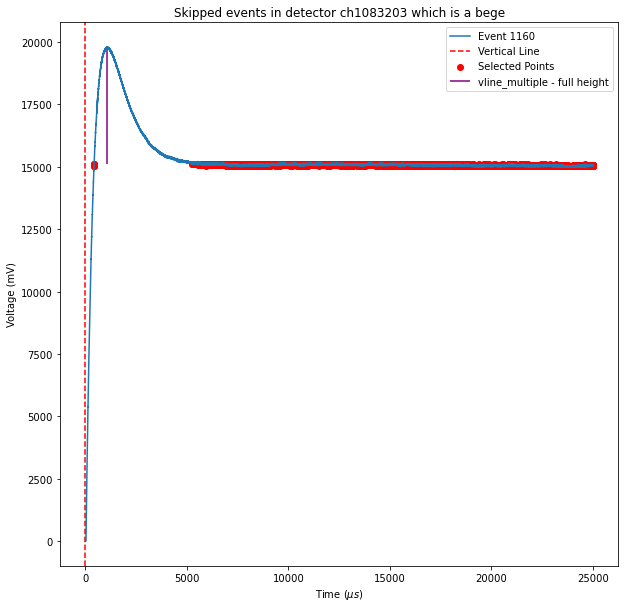

microdischarge


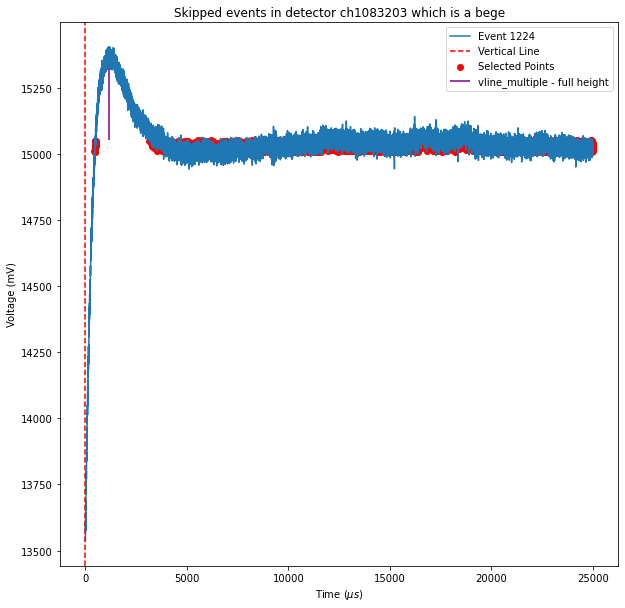

discharge


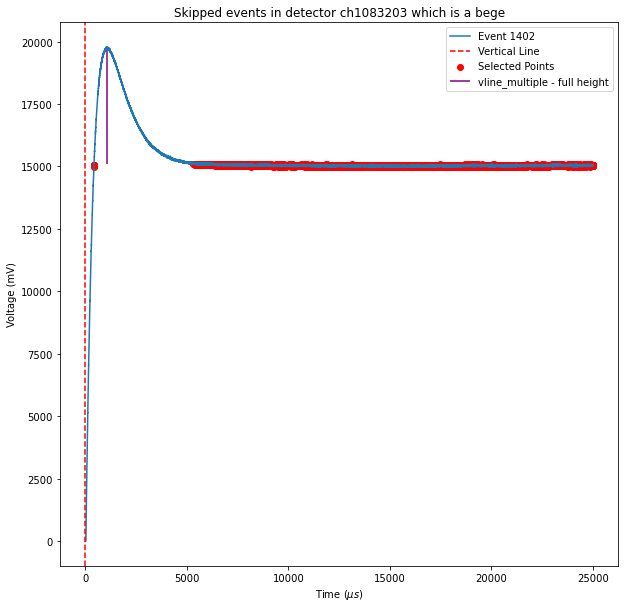

discharge


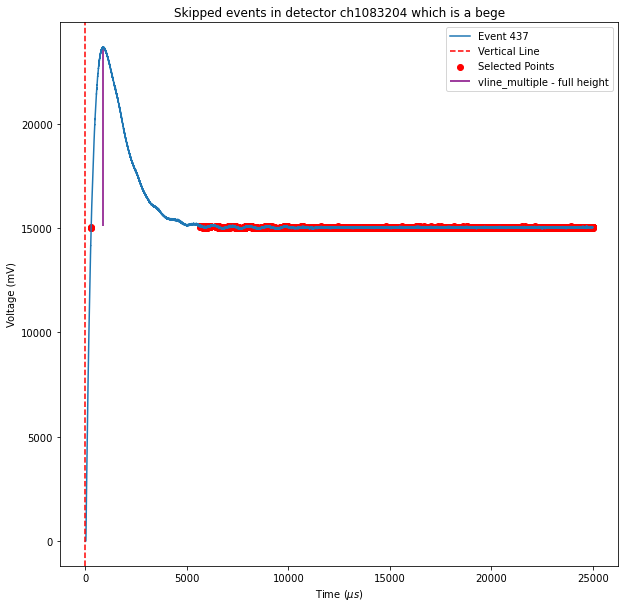

microdischarge


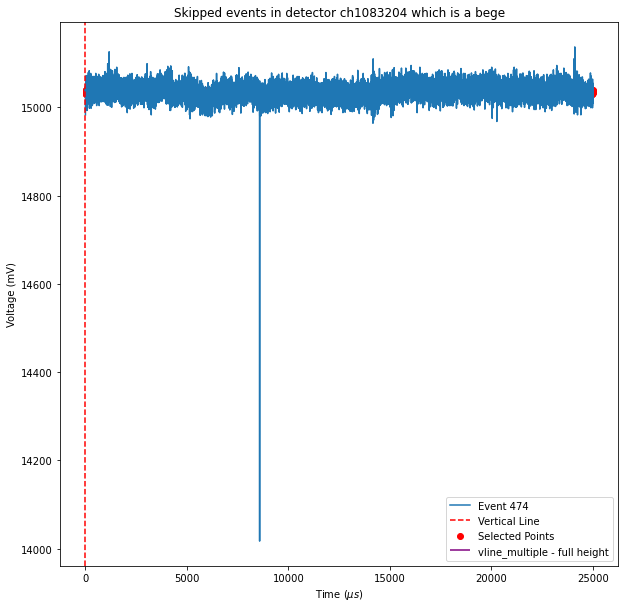

discharge


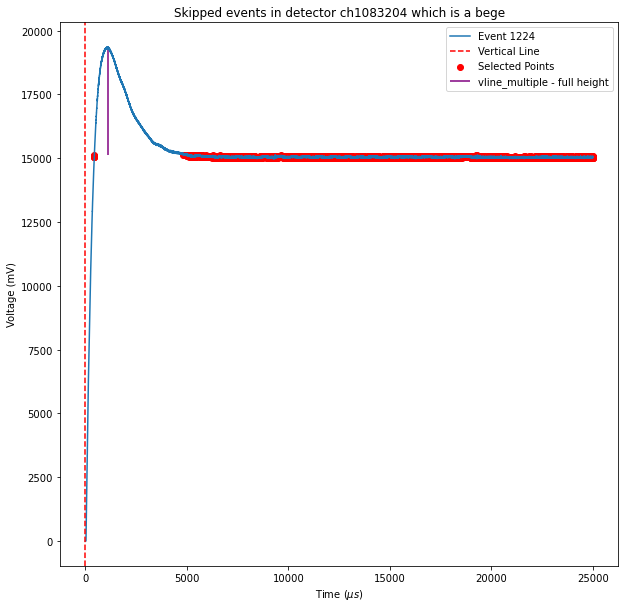

microdischarge


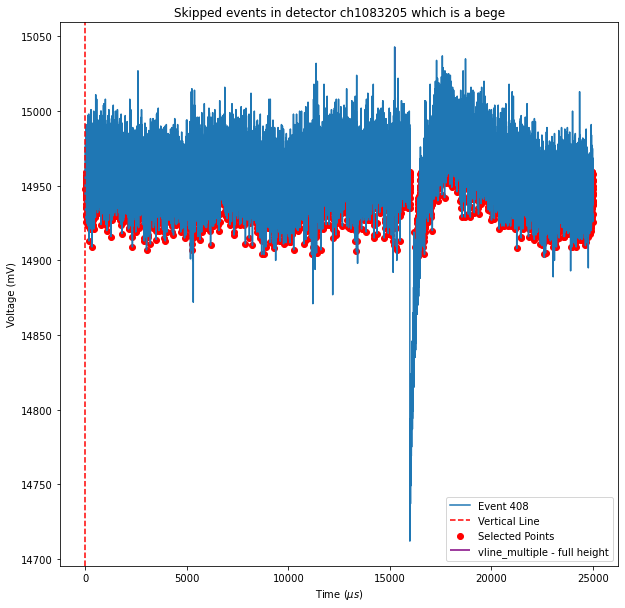

microdischarge


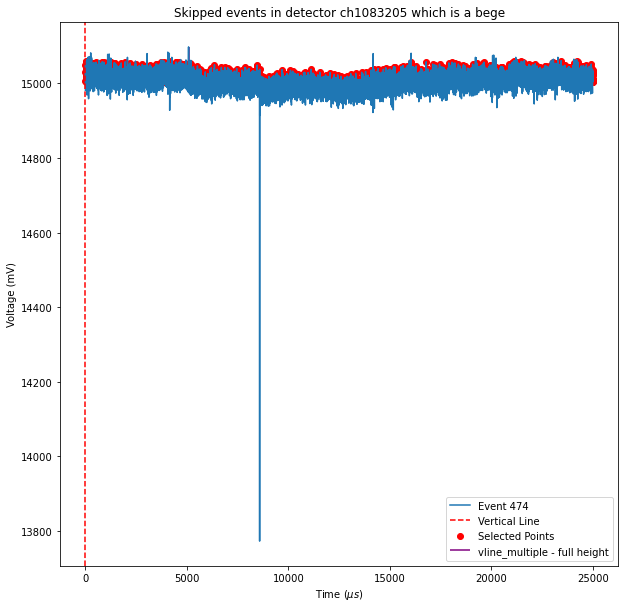

microdischarge


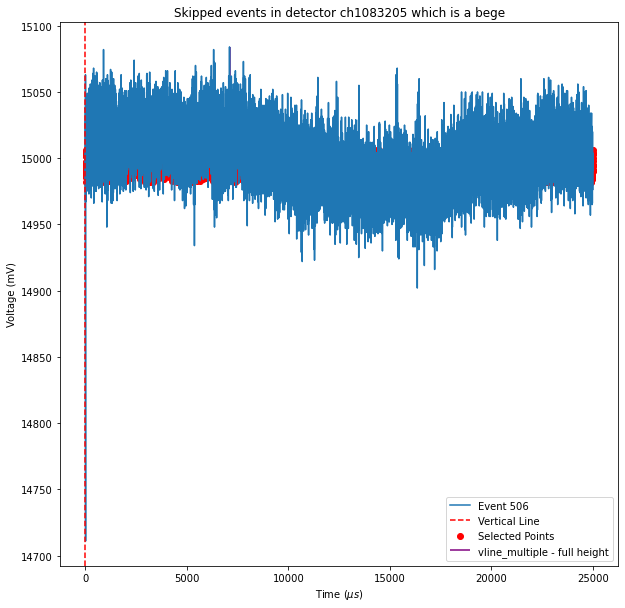

microdischarge


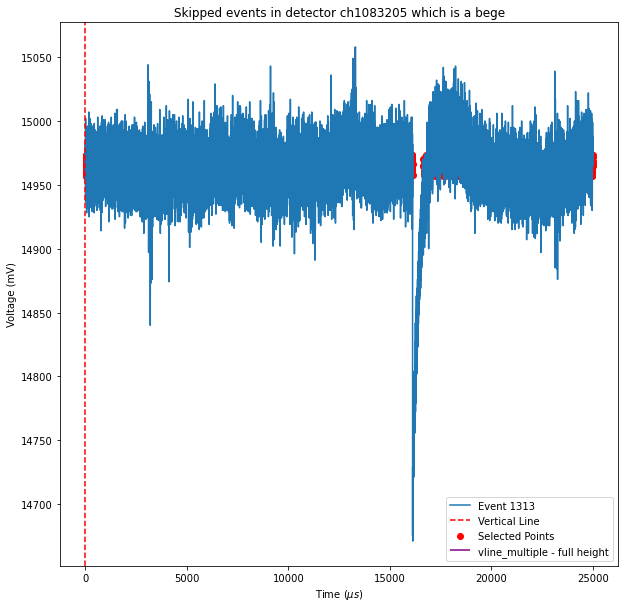

microdischarge


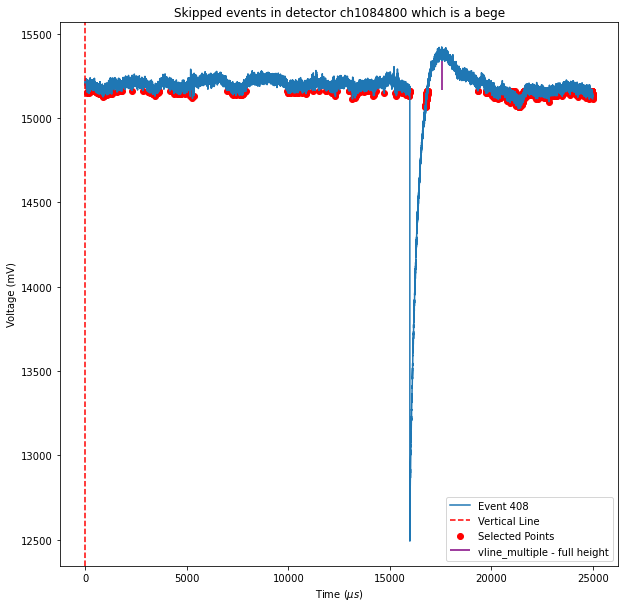

microdischarge


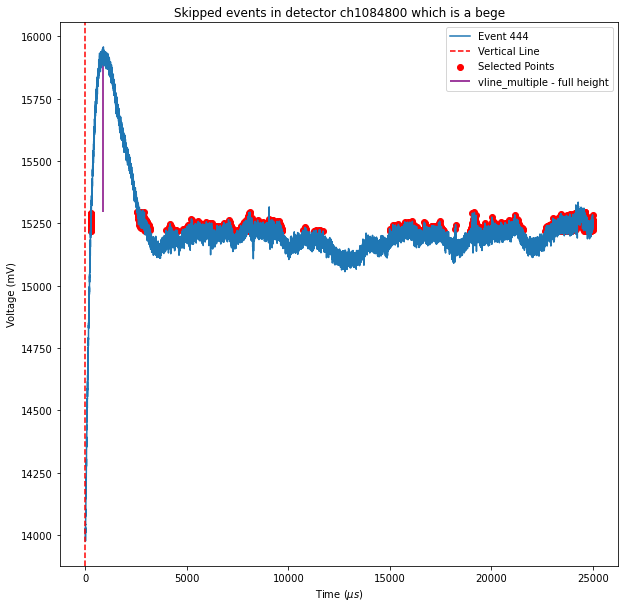

microdischarge


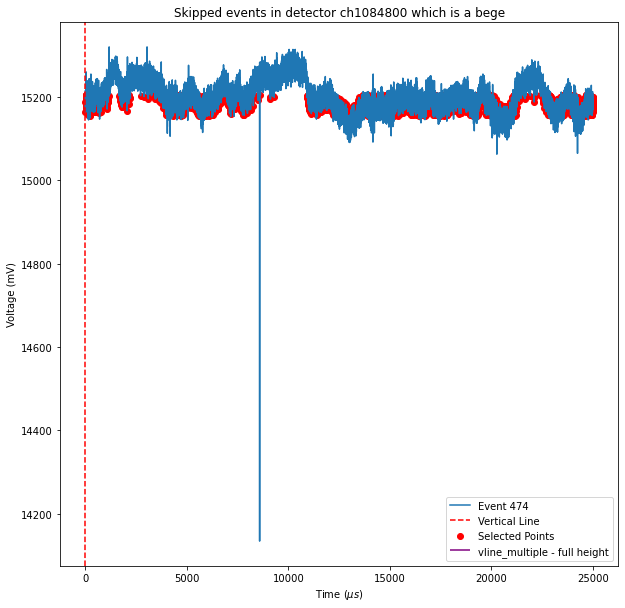

microdischarge


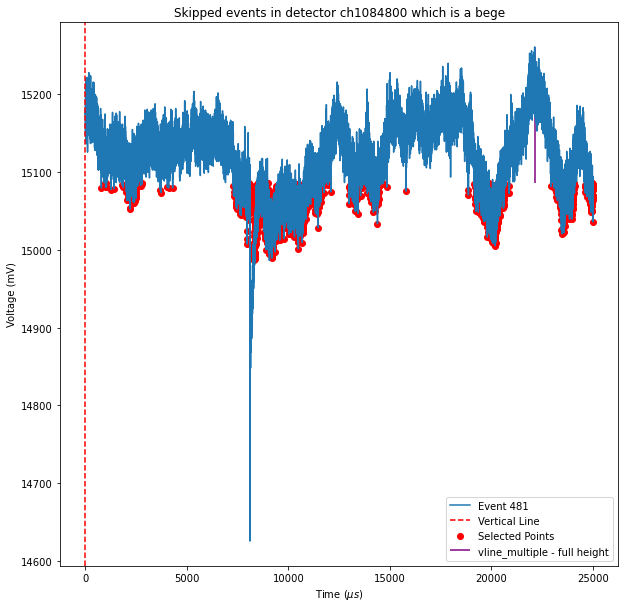

microdischarge


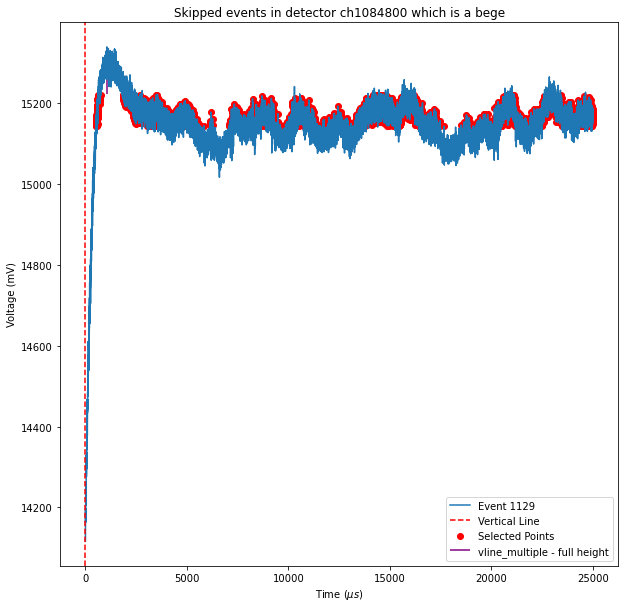

discharge


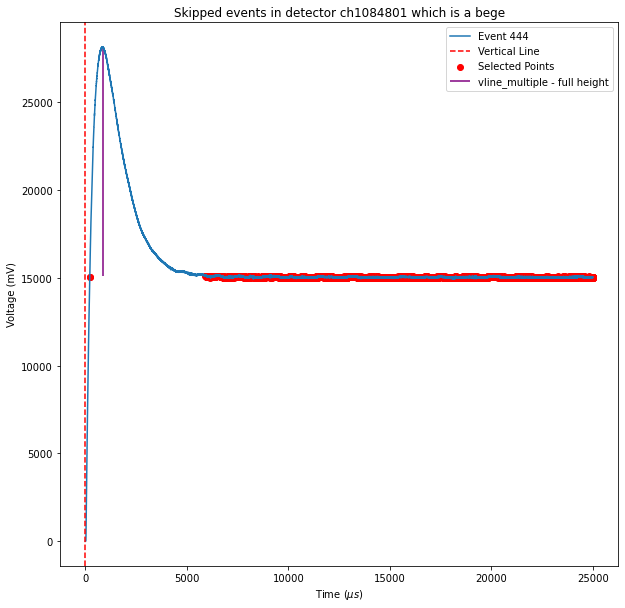

microdischarge


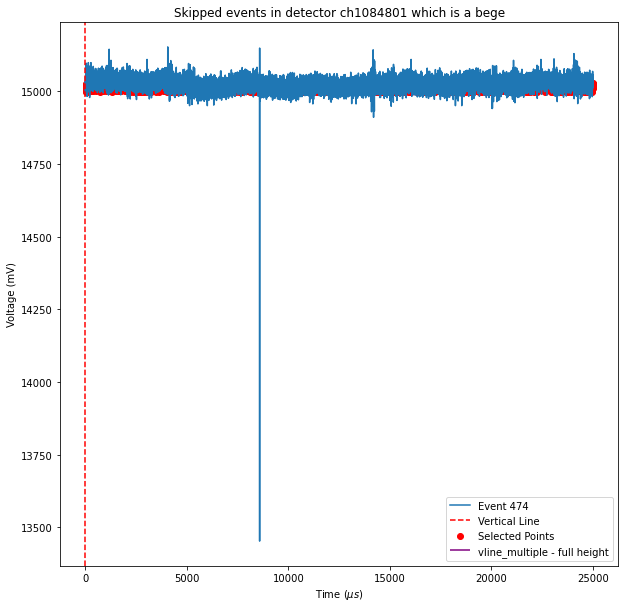

microdischarge


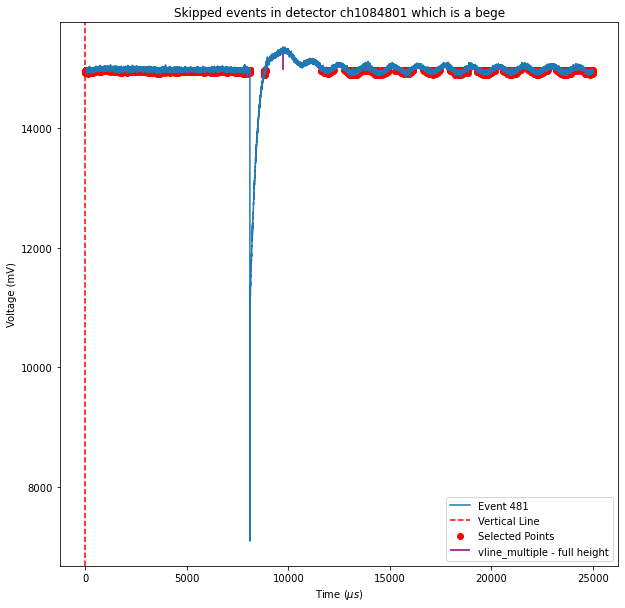

microdischarge


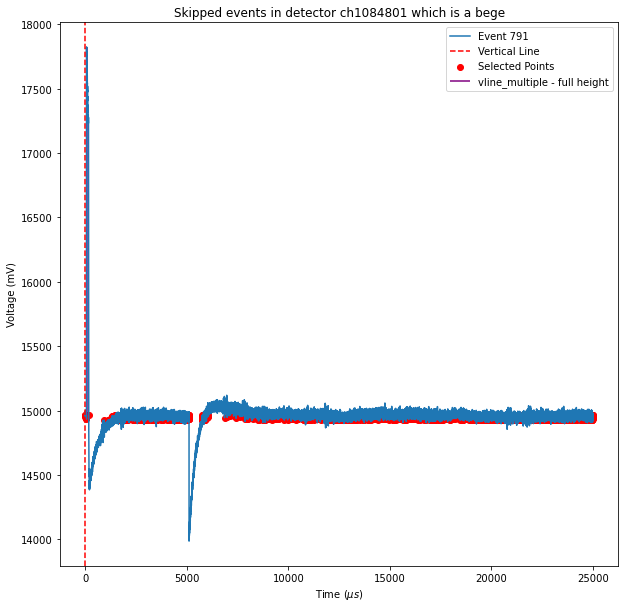

discharge


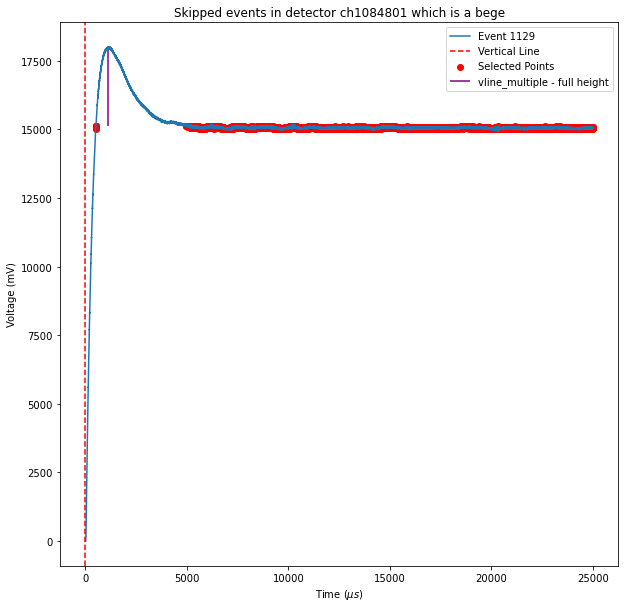

microdischarge


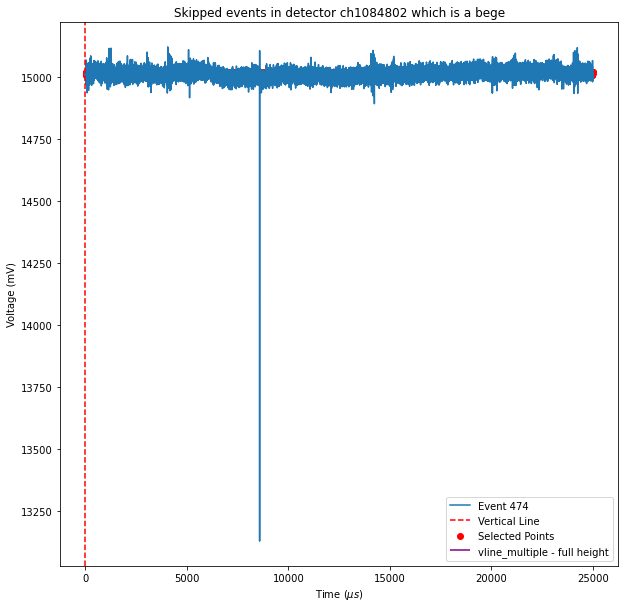

microdischarge


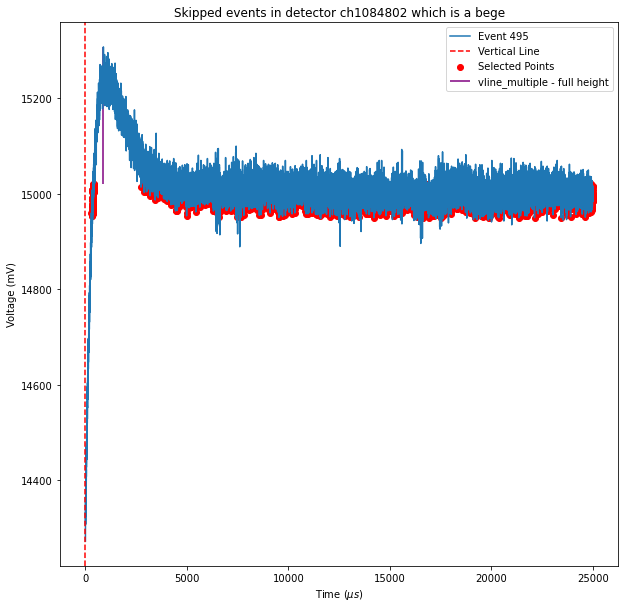

MESSY DISCHARGE


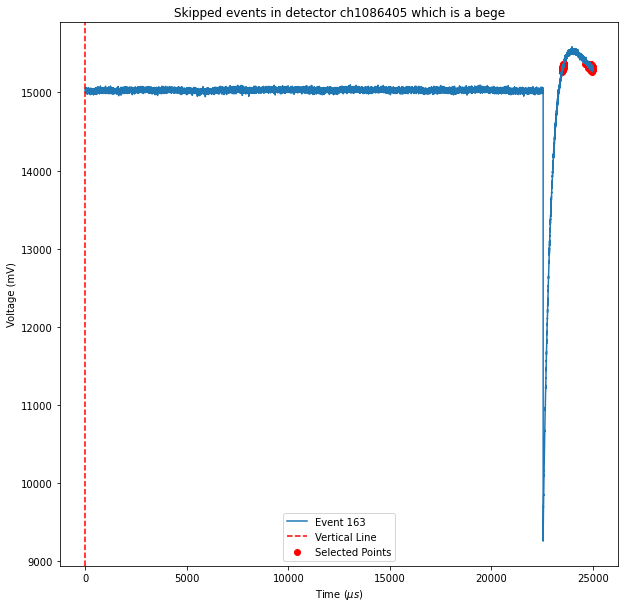

In [26]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event', 'Maximum magnitude','Minimum magnitude'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event', 'Maximum magnitude','Minimum magnitude'])

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0)
            max_value = np.max(wf0)
            
            max_index = np.argmax(wf0)
            time_of_max_value = ts[max_index]
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
            
            #weighted standard deviation
            non_zero_weights = [weight for weight in all_weight if weight != 0]
            length1 = len(non_zero_weights)
            
            tops = []
            for k in wf0:
                weight = abs(1/(k-mean_y))
                top = weight*(k-weighted_average)**2
                tops.append(top)
            
            std_weight = np.sqrt(np.sum(tops)/((length1-1)*np.sum(all_weight)/length1))
            
            
                
            #print(std_weight)
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            #print(f"The mean y values is {mean_y}")
            #print(f"The weighted mean y values is {weighted_average}")
            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform
            
            for_append = []
            for_x = []
            if std_weight<50:
                # x values within the baseline range 
                # y values within the baseline range 
                for t, q in zip(ts, wf0):
                    if weighted_average-std_weight < q < weighted_average+std_weight:
                        for_x.append(t)
                        for_append.append(q)
            else:
                for t, q in zip(ts, wf0):
                    if weighted_average-50 < q < weighted_average+50:
                        for_x.append(t)
                        for_append.append(q)
                
            
            # Plot the x values
            size = len(for_x)
            plt.scatter(for_x, for_append, color='r', label='Selected Points')
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:
                if size>4000:
                    if std_weight<50:
                        top_val = max_value - weighted_average +std_weight
                        bot_val = max_value - weighted_average -std_weight
                        plt.vlines(x = time_of_max_value, ymin = weighted_average+std_weight, ymax =max_value,colors = 'purple',label = 'vline_multiple - full height')
                    else:
                        top_val = max_value - weighted_average +50
                        bot_val = max_value - weighted_average -50
                        plt.vlines(x = time_of_max_value, ymin = weighted_average+50, ymax =max_value,colors = 'purple',label = 'vline_multiple - full height')
                    
                    if np.any(wf0[:]==0):
                        discharge_type = "discharge"
                        print("discharge")
                        df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Minimum magnitude': bot_val,
                        'Maximum magnitude': top_val,
                    }, ignore_index=True)
                    else:
                        discharge_type = "microdischarge"
                        print("microdischarge")
                        df1 = df1.append({
                            'Detector Name': j,
                            'Event':i,
                            'Type': discharge_type,
                            'Minimum magnitude': bot_val,
                            'Maximum magnitude': top_val,
                        }, ignore_index=True)
                else:
                    print("MESSY DISCHARGE")
            else:
                print("NO DISCHARGE")
                
            #plt.vlines(x = time_of_max_value, ymin = weighted_average+50, ymax =max_value,colors = 'purple',label = 'vline_multiple - full height')
            
            # Add a vertical line for the range (average_weight ± 50) to max_value
            plt.axvline(x=0.5, ymin=0, ymax=1, color='red', linestyle='--', label='Vertical Line')
            # Customize plot
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [27]:
excel_filename = 'magnitude_discharge_bege.xlsx'
df.to_excel(excel_filename, index=False)
excel_filename = 'magnitude_microdischarge_bege.xlsx'
df1.to_excel(excel_filename, index=False)